In [1]:
from err import err

# Importing Python modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from time import perf_counter
from loguru import logger
import os
import mat73
from bispectrum_real_data_analysis.scripts.utils import seconds_to_formatted_time
import matplotlib 
from numpy.linalg import inv
from high_order_spectra_analysis.hosa.hosa import Tdhosa, tdqs
from pathos.multiprocessing import ProcessingPool as Pool
import pickle


fontsize = 15
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': fontsize})

%matplotlib inline

In [2]:
generate_hosa: bool = True

In [3]:
replace_hosa: bool = False

In [4]:
replace_err: bool = False

In [5]:
id_file: str = "narx_only_ic"

In [6]:
full_dict_inputs = {
    0: "CS_modulating",
    1: "Inferior_colliculus_1",
    2: "Inferior_colliculus_3",
    3: "Inferior_colliculus_4",
    4: "Amygdala_lateral_1",
    5: "Amygdala_lateral_2",
    6: "Amygdala_basolateral_1",
    7: "Amygdala_basolateral_2"
}

dict_inputs = {
    0: "CS_modulating",
    1: "Inferior_colliculus_1",
    2: "Inferior_colliculus_3",
    3: "Inferior_colliculus_4",
}
# Only amygdala lateral
inputs = [0, 1, 2, 3]

In [7]:
use_y_as_regressor: bool = True

degree_of_non_linearity: int = 2
max_delays: int = 4
max_y_delays: int = max_delays*use_y_as_regressor
max_u_delays: int = np.array([max_delays] * len(inputs))

# Methods

In [8]:
# Method to extract events from dataframe

def select_event_window(
    df: pd.DataFrame, 
    event_name: str, 
    samples_before: int = 0, 
    samples_after: int = 0
) -> pd.DataFrame:
    """
    Method to extract the slice of the dataframe which contais the event, with some data before and after, 
    given number of samples to add to the begin and end, respectively.
    """

    window_index = np.argwhere(df.event.to_numpy() == event_name).flatten()
    begin_index = window_index[0] - samples_before
    end_index = window_index[-1] + samples_after
    return df[begin_index:end_index]

In [9]:
def decimate(data: pd.DataFrame, desired_frequency_sampling: float, filter: bool = False, time=None):
    if time is None:
        time = data.Time.to_numpy()
    TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The time sampling is {TimeSampling} seconds and the frequency is "
        f"{FrequencySampling/float(1000**(FrequencySampling<=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")

    newTimeSampling = 1.0/desired_frequency_sampling
    decimation_rate = np.ceil(newTimeSampling/TimeSampling).astype(int)
    logger.info(f"The data will be decimated by the rate 1:{decimation_rate}")

    if filter:
        matrix = data.iloc[:, 1:-2].to_numpy()
        decimated_matrix = signal.decimate(matrix, decimation_rate, axis=0, ftype='fir', zero_phase=True)
        new_data = data.copy()[::decimation_rate]
        new_data.iloc[:, 1:-2] = decimated_matrix
    else:
        new_data = data[::decimation_rate]

    TimeSampling = TimeSampling*decimation_rate
    
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The new time sampling is {np.round(TimeSampling, 5)} s and the new frequency is "
    f"{FrequencySampling/float(1000**(FrequencySampling>=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")
    
    return new_data, TimeSampling, FrequencySampling

In [10]:
def moving_average(x, N):
    return np.convolve(x, np.ones(N), 'same') / N

In [11]:
def get_events(data, threshold, window_size, time_sampling):
    
    x = data.CS_modulating.to_numpy()
    N = len(x)
    index = np.arange(N)
    plt.figure(figsize=(16,14))
    plt.subplot(321)
    plt.plot(index, x)
    plt.ylabel("x")

    x = x - np.mean(x[:10])
    plt.subplot(322)
    plt.plot(index, x)
    plt.ylabel("x - mean(x)")

    x = x**2
    plt.subplot(323)
    plt.plot(index, x)
    plt.ylabel("(x - mean(x))^2")

    x = moving_average(x, window_size)
    plt.subplot(324)
    plt.plot(index, x)
    plt.axhline(threshold, color="red", label="threshold")
    plt.legend(loc='upper right')
    plt.ylabel("moving_average_10_(x - mean(x))^2")

    x[x>threshold] = 1
    x[x<threshold] = 0

    plt.subplot(325)
    plt.plot(index, x)
    plt.ylabel("threshold(moving_average_10_(x - mean(x))^2)")

    indices = index[np.append(False, x[1:] - x[:-1]) != 0]

    for event, s, e in zip(range(1, 6), indices[0::2], indices[1::2]):
        print(f"\nEvent: {event}")
        print(f"start: {s}\nend: {e}") 
        print(f"time duration: {(e-s)*time_sampling}")

    print(f"\nlen(indices) = {len(indices)}")

    data = data.assign(event=np.empty(len(data), dtype=str))
    data.loc[:, "event"] = "base"

    for i, event in zip(range(0, len(indices), 2), np.arange(1, 6)):
        start = indices[i]
        end = indices[i+1]
        data.loc[start:end, "event"] = f"event_{event}"

    data.event.unique()

    plt.subplot(326)
    for event in data.event.unique():
        plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)

    plt.ylabel("events")

    plt.show()
    return data

In [12]:
def AIC(n_theta, N, var_xi):
    """
    AIC(n_theta) = N ln[var(Xi(n_theta))] + 2 n_theta
    """
    return N*np.log(var_xi) + 2*n_theta

In [13]:
def MQ(Psi, y):
    theta = inv(Psi.T@Psi)@Psi.T@y
    residuos = y - Psi@theta
    return theta, residuos

In [14]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

In [15]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filtfilt=False):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if filtfilt:
        return signal.filtfilt(b, a, data)
    return signal.lfilter(b, a, data)

## Algoritmo do estimador recursivo de Mínimos Quadrados Estendido (REMQ):

The algorithm calculates $\theta$ for each sample, and uses a crossvariance matrix to adjust the parameters, just like the Kalman filter does.

$$
\left\{
\begin{array}{l}
    K_k = P_{k-1} \psi_k \left[ \psi_k^T P_{k-1} \psi_k +1 \right]^{-1}; \\
    \mathbf{\hat{\theta}}_k = \mathbf{\hat{\theta}}_{k-1} + K_k \left[ y(k) - \psi_k^T \mathbf{\hat{\theta}}_{k-1}\right];\\
    P_k = P_{k-1} - K_k \psi_k^T P_{k-1};\\
    \xi(k) = y(k) - \psi_k^T \mathbf{\hat{\theta}}_k.
\end{array}
\right.
$$

In [16]:
def REMQ(u, y, numero_regressores=5, gain_P=10e6, all_thetas=True):
    P=np.eye(numero_regressores)*gain_P
    ini=2
    theta = np.empty(shape=(numero_regressores,len(u)))
    xi = np.zeros(len(u))
    theta[:,0] = np.zeros(numero_regressores)
    theta[:,1] = np.zeros(numero_regressores)
    # Algoritmo recursivo
    for k in range(ini,len(y)):
        # Calcula Psi(k)
        psi_k = np.vstack([y[k-1], y[k-2], u[k-1], u[k-2], xi[k-1]])
        # Calcula K(k)
        K_k = (P@psi_k)/(psi_k.T@P@psi_k+1)
        # Calcula Theta(k)
        theta[:,k] = theta[:,k-1] + K_k@(y[k]-psi_k.T@theta[:,k-1])
        # calcula P(k)
        P = P - K_k@psi_k.T@P
        xi[k] = y[k] - psi_k.T@theta[:,k]
    return theta if all_thetas else theta[:,-1]

In [17]:
def filter_function(column): 
    return butter_bandpass_filter(
        data=column, 
        lowcut=low_cut_hz, 
        highcut=high_cut_hz,
        fs=fs,
        order=filter_order, 
        filtfilt=True
    )

In [18]:
def NARX(u, theta, y0=None):
    y = np.zeros(len(u))
    if y0 is not None:
        y0 = y0 if isinstance(y0, np.ndarray) else np.array([y0])
        y[:len(y0)] = y0
    else:
        y0 = [0]
    for k in range(len(y0),len(u)):
        y[k] =  (
            theta[0] * y[k-1] 
          + theta[1] * (u[k-1]*u[k-2])
          + theta[2] * y[k-2]
          + theta[3] * u[k-2]
          + theta[4] * np.power(u[k-3], 2)
          + theta[4] * np.power(u[k-1], 2)
        )
    return y

In [19]:
def save_err(err_out, termos, psi):

    pickle_file = f"err_model_{id_file}_{id_results}"

    logger.info("saving err...")
    with open(f"{pickle_file}_err.pkl", 'wb') as f:  # open a text file    
        pickle.dump(err_out, f) # serialize the list
        
    logger.info("saving termos...")
    with open(f"{pickle_file}_termos.pkl", 'wb') as f:  # open a text file
        pickle.dump(termos, f) # serialize the list
        
    logger.info("saving psi...")
    with open(f"{pickle_file}_psi.pkl", 'wb') as f:  # open a text file
        pickle.dump(psi, f) # serialize the list
        
    logger.success("Done saving err data!")

In [20]:
def load_err():
    # These variables below are global in the notebook
    pickle_file = f"err_model_{id_file}_{id_results}"

    logger.info("loading err...")
    with open(f"{pickle_file}_err.pkl", 'rb') as f:  # open a text file
        err_out_temp = pickle.load(f) # serialize the list
        
    logger.info("loading termos...")
    with open(f"{pickle_file}_termos.pkl", 'rb') as f:  # open a text file
        termos_temp = pickle.load(f) # serialize the list
        
    logger.info("loading psi...")
    with open(f"{pickle_file}_psi.pkl", 'rb') as f:  # open a text file
        psi_temp = pickle.load(f) # serialize the list
        
    logger.success("Done loading err data!")
    
    return err_out_temp, termos_temp, psi_temp

In [21]:
def eval_model_SISO_NARX(
    model: list[str] | np.ndarray[str],
    theta: list[float|int] | np.ndarray[float|int],
    u: list[float|int] | np.ndarray[float|int],
    y: list[float|int] | np.ndarray[float|int],
    y0: int | float | list[float|int] | np.ndarray[float|int]
) -> np.ndarray[float]:
    """ Method to evaluate model using free simulation.
    The model must contain 'u' as input, 'y' as output and must be parsable using eval.
    
    returns (np.ndarray[float]): output of free simulation
    """
    N = np.max(u.shape)
    y = np.zeros(N)
    y0 = y0 if isinstance(y0, np.ndarray) or isinstance(y0, list) else np.array([y0])
    y[:len(y0)] = y0
    for k in range(len(y0),N):
        for gain, term in zip(theta, model):
            y[k] += gain*eval(term)
            
    return y

In [22]:
# Método para calcular o desvio RMS (RMSD)
def RMSD(y, y0):
    error = y-y0
    error = np.square(error)
    error = np.sum(error)
    error = error/len(y)
    error = np.sqrt(error)
    return error

In [23]:
# Método que calcula a FFT unilateral e retorna um plot,
# o vetor de frequências em Hertz e os ganhos
def fft(x, fs):
    N = len(x)
    FFT = np.fft.fft(x)
    P2 = np.abs(FFT/N)
    intensity = P2[0:N//2]
    intensity[1:-1] = 2*intensity[1:-1]
    frequency = fs*np.arange(0,N//2)/N
    angle = np.angle(FFT)
    angle = angle[0:N//2]
    return frequency, intensity, angle

In [24]:
class TDQS(Tdhosa):

    def run_td4spectrum(self, signal_dict: np.ndarray | pd.Series): 
        event, signal = list(signal_dict.items())[0]
        print(f"Running tdqs for event {event} and signal of len {len(signal)}")
        return {
            event: self.run_tdqs(
                signal
            )
        }

In [25]:
def get_time_given_time_sampling_and_N(time_sampling: float, N: int, start_in_seconds: float = 0):
    end_time = (N)*time_sampling + start_in_seconds
    return np.arange(start_in_seconds, end_time, time_sampling)

# Loading files

In [26]:
BASE_PATH = "/home/matheus/Documents/repositories/bispectrum_real_data_analysis/bispectrum_real_data_analysis/data/"    

In [27]:
list_of_files: list[str] = os.listdir(BASE_PATH)
[(i, file) for i, file in enumerate(list_of_files)]

[(0, 'rats'),
 (1, '1_Etapa_paper_Simoes-20230328T020230Z-001.zip'),
 (2, 'only_rats'),
 (3, '.gitkeep'),
 (4, 'rats_simoes'),
 (5, 'F04__T_data.mat'),
 (6, 'html')]

In [28]:
file_to_load: str = list_of_files[5]
file_to_load

'F04__T_data.mat'

In [29]:
# Loading and creating the data matrix

logger.info(f"Loading .mat file...")

complete_path: str = f"{BASE_PATH}/{file_to_load}"

complete_data = mat73.loadmat(complete_path)

logger.success("Loaded!")

2023-07-02 18:41:19.789 | INFO     | __main__:<module>:3 - Loading .mat file...
2023-07-02 18:41:20.487 | SUCCESS  | __main__:<module>:9 - Loaded!


In [30]:
data = complete_data["data"]["data"][0]

In [31]:
FrequencySampling = complete_data["parameters"]["srate"].item()
TimeSampling = 1.0/FrequencySampling

In [32]:
TimeSampling

0.001

In [33]:
FrequencySampling

1000.0

In [34]:
data.shape

(17, 990311)

In [35]:
columns = [
    "CS_modulating",
    "mPFC_pre_limbic_1",
    "mPFC_pre_limbic_2",
    "mPFC_infra_limbic_1" ,
    "mPFC_infra_limbic_2" ,
    "Hippocampus_CA1" ,
    "Hippocampus_MOL_layer" ,
    "Hippocampus_GD_1" ,
    "Hippocampus_GD_2" ,
    "Amygdala_lateral_1" ,
    "Amygdala_lateral_2" ,
    "Amygdala_basolateral_1",
    "Amygdala_basolateral_2" ,
    "Inferior_colliculus_1" ,
    "Inferior_colliculus_2" ,
    "Inferior_colliculus_3" ,
    "Inferior_colliculus_4"
]

In [36]:
data = pd.DataFrame(data=data.T, columns=columns)

In [37]:
time = get_time_given_time_sampling_and_N(
    time_sampling=TimeSampling,
    N=data.shape[0],
    start_in_seconds=10
)

data = data.assign(Time=time)

In [38]:
data.shape

(990311, 18)

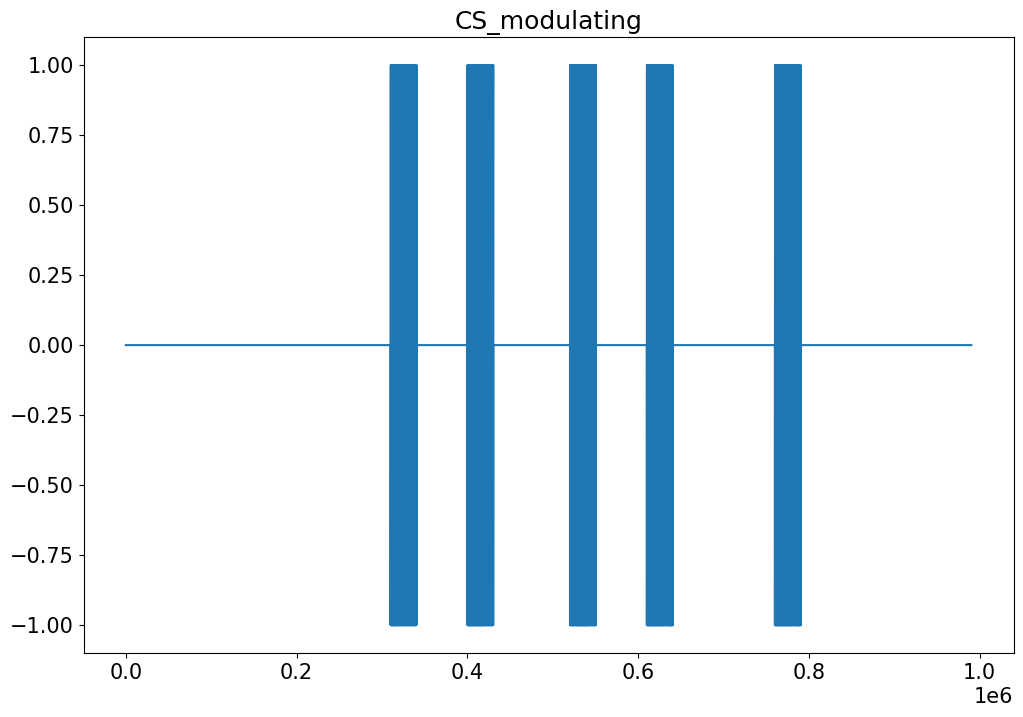

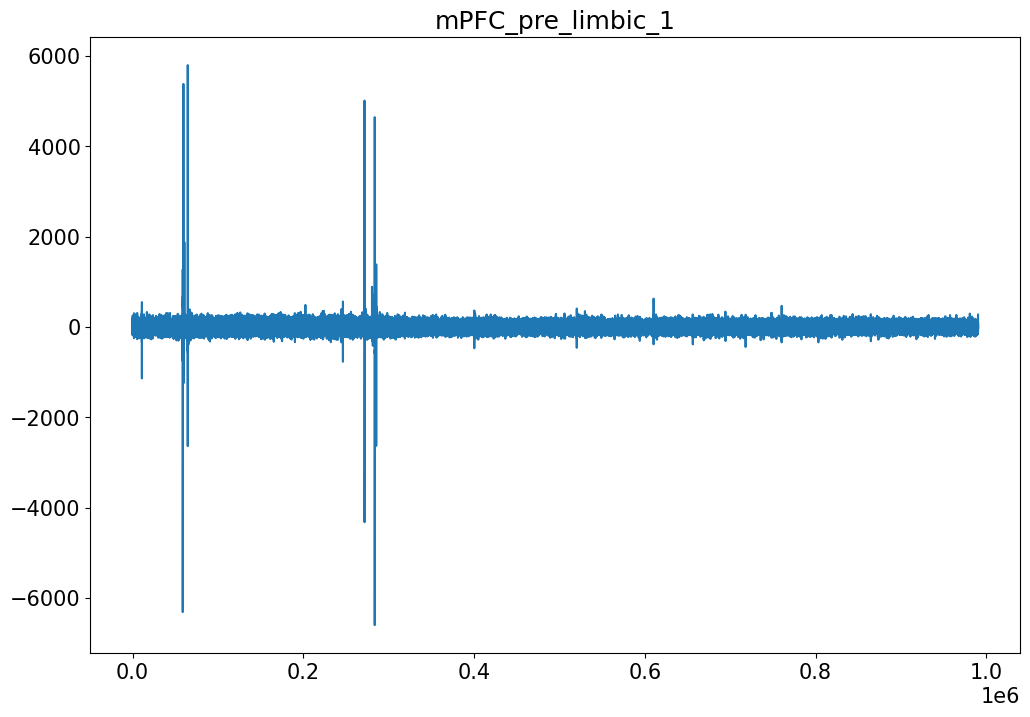

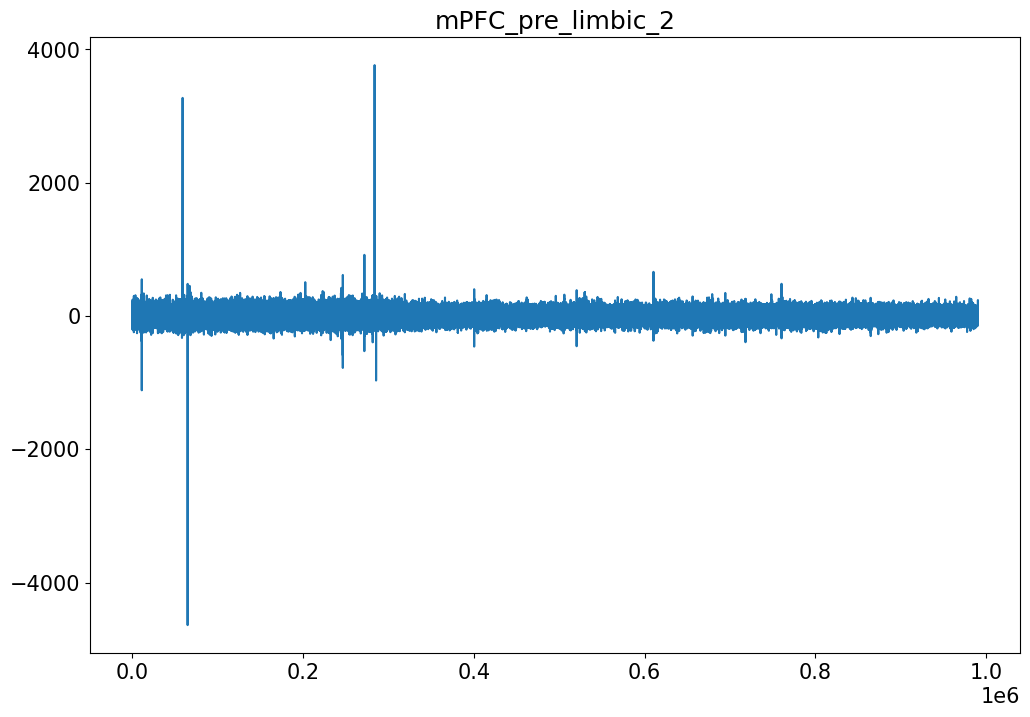

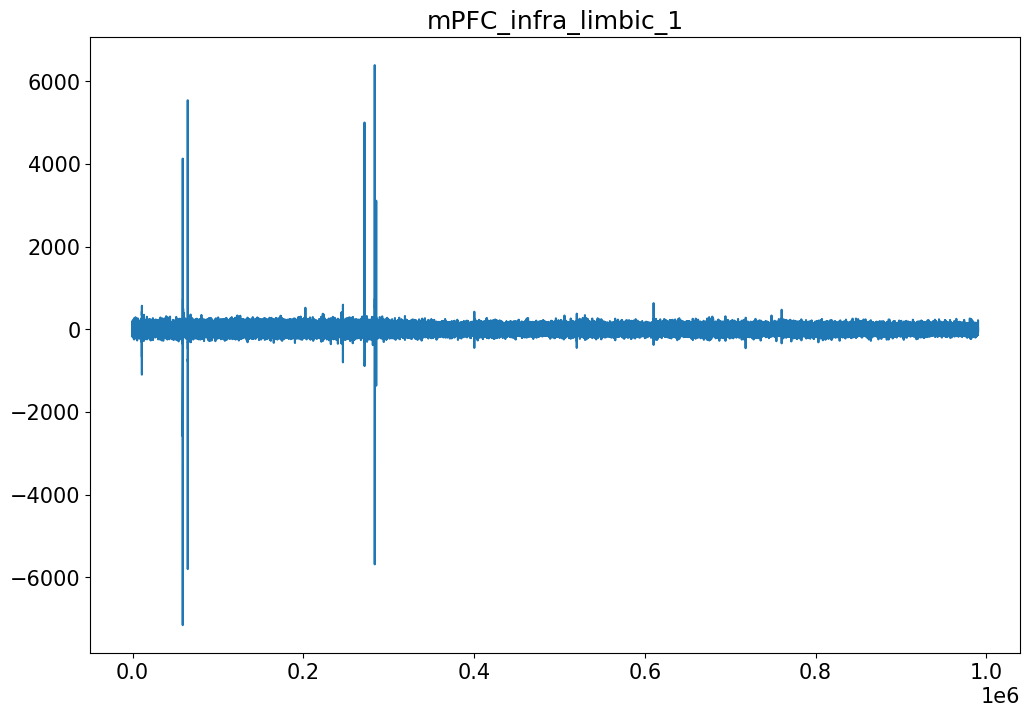

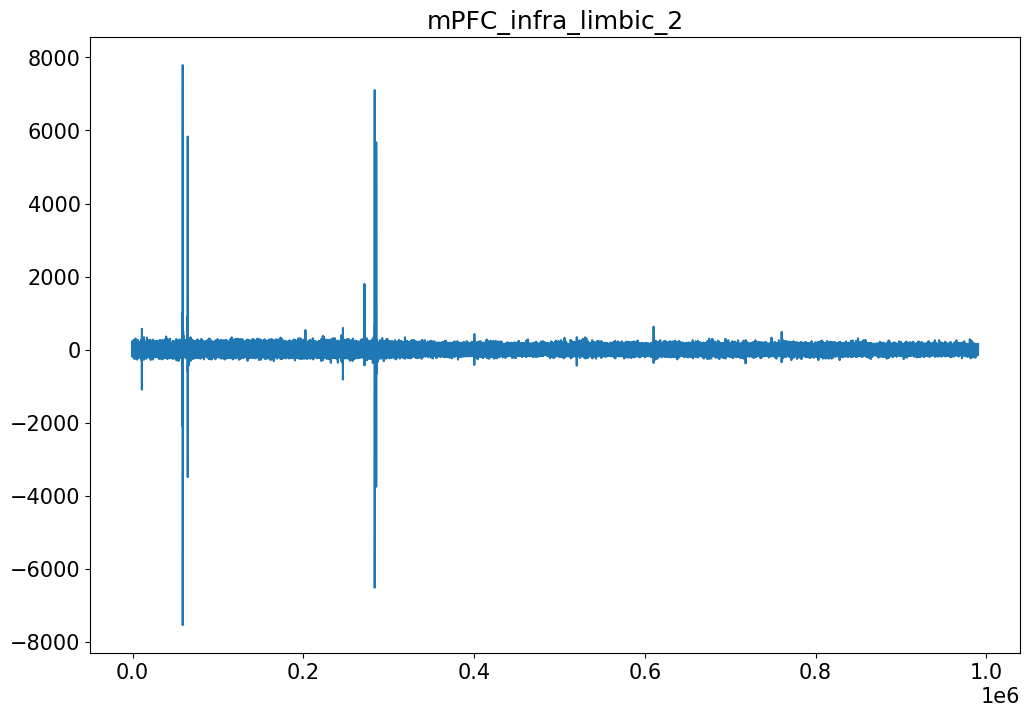

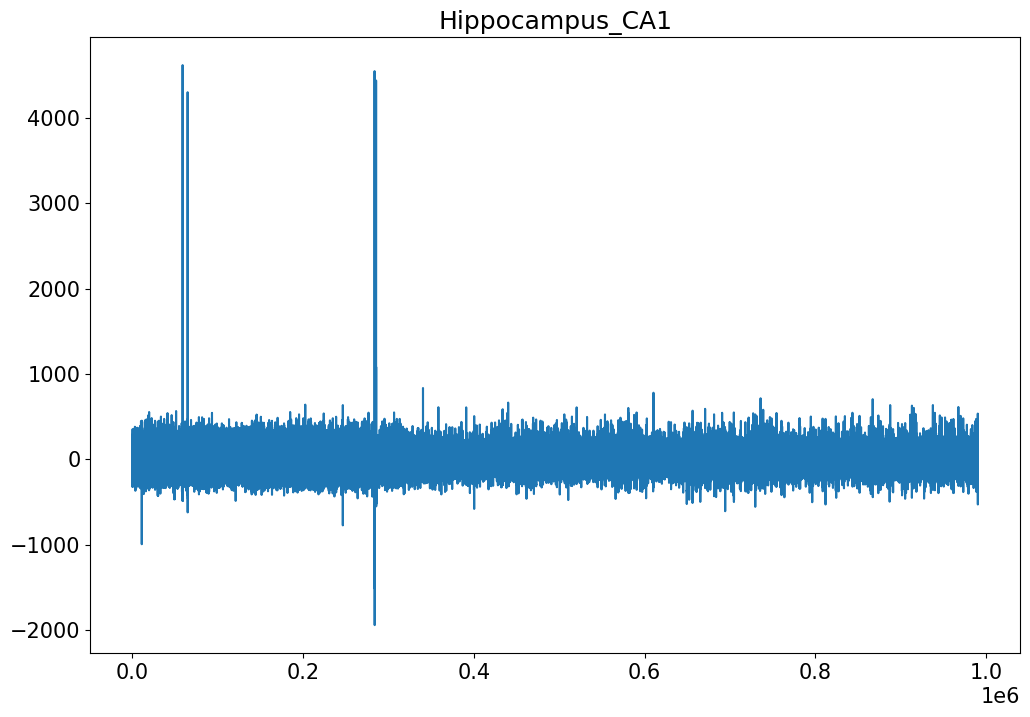

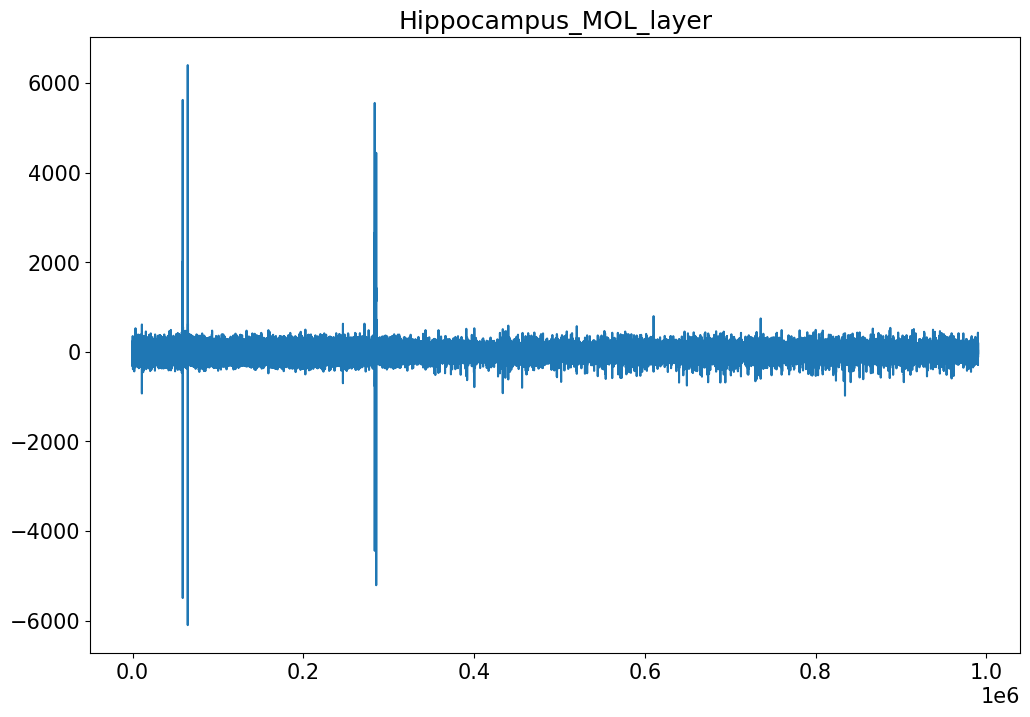

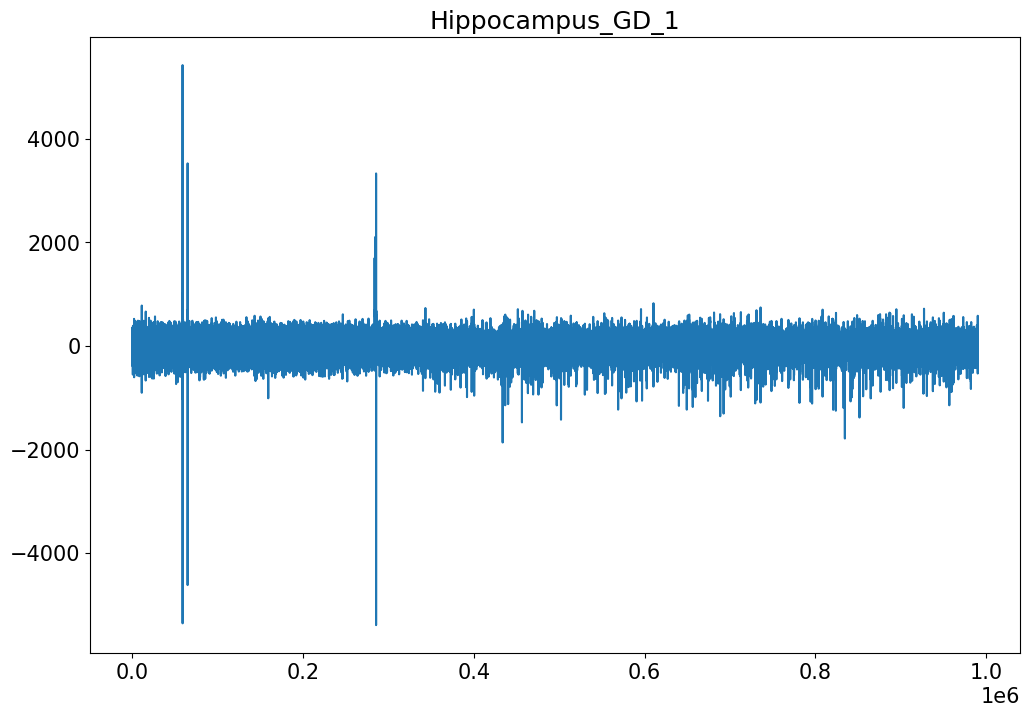

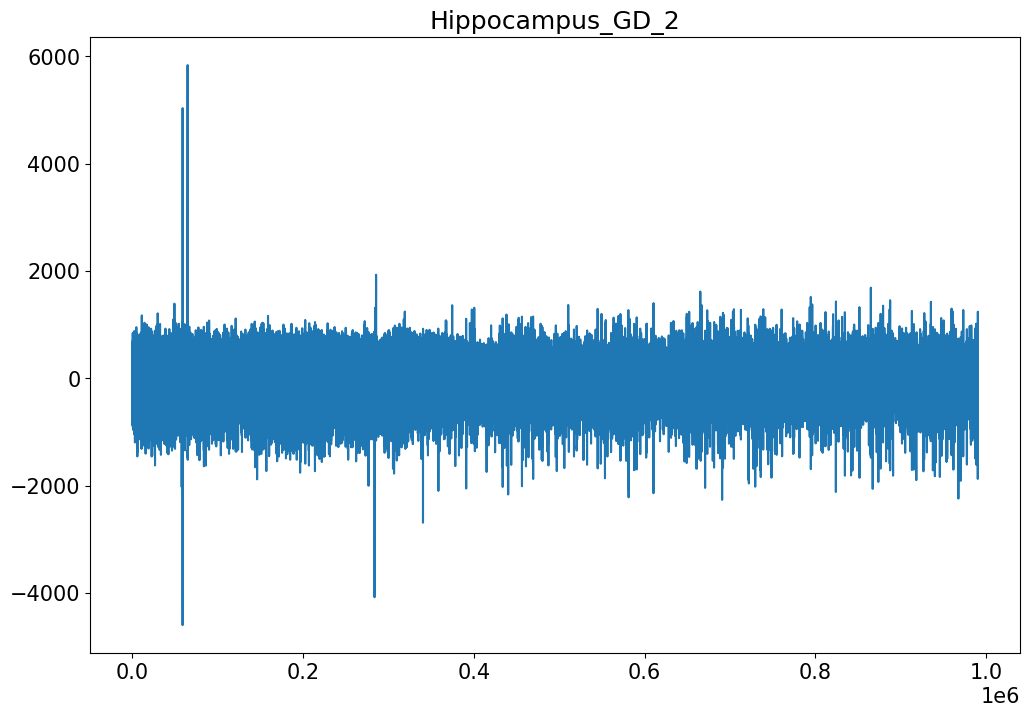

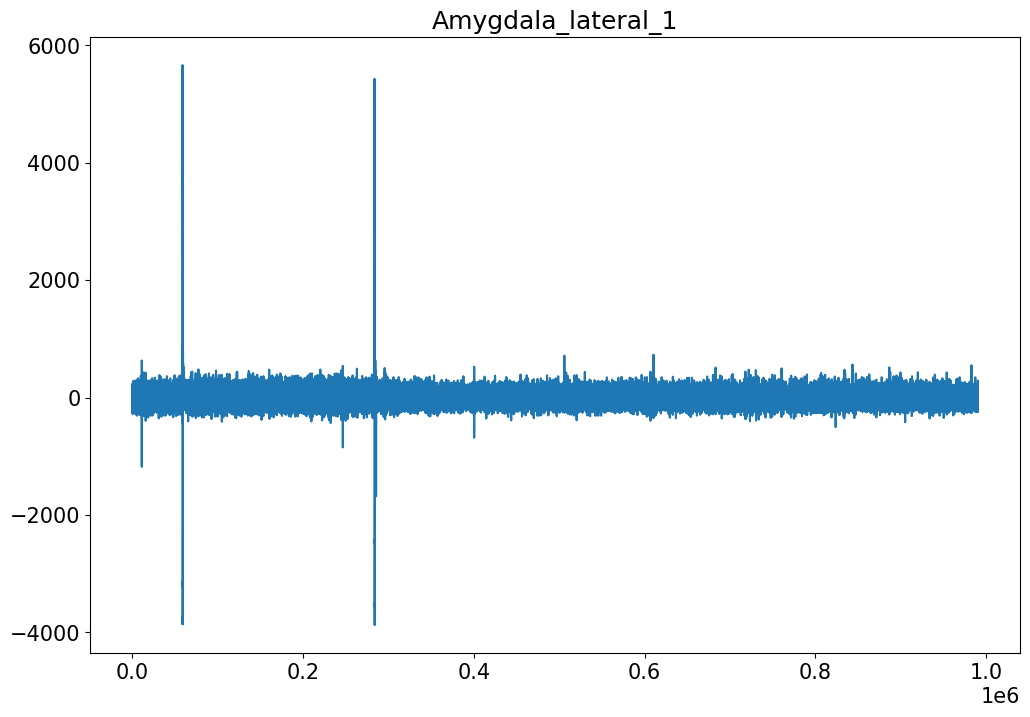

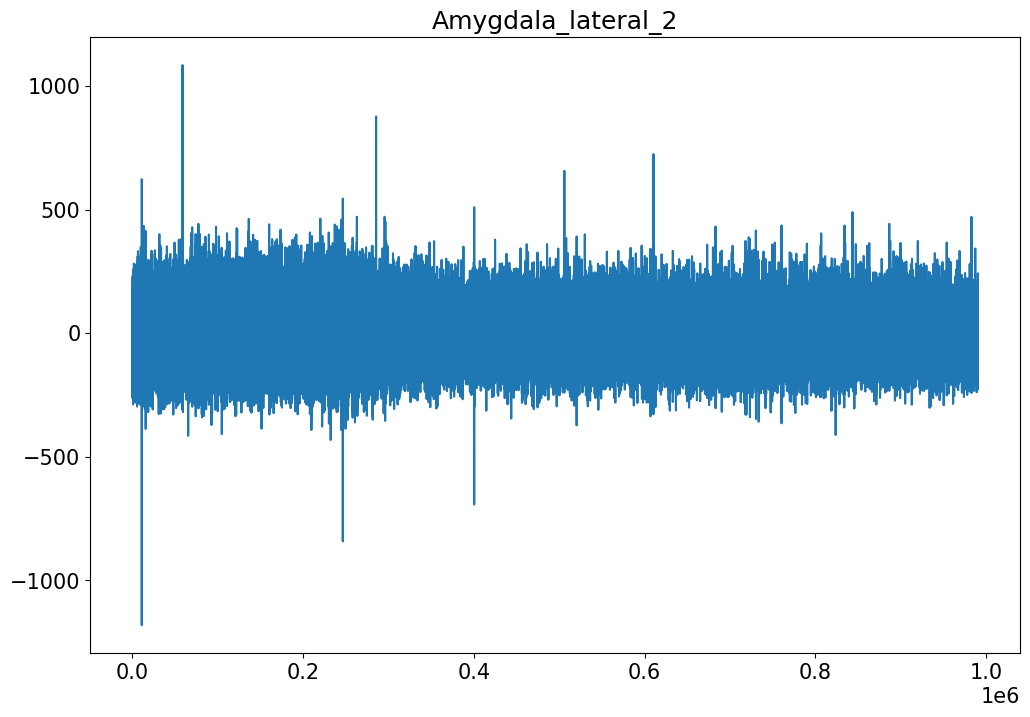

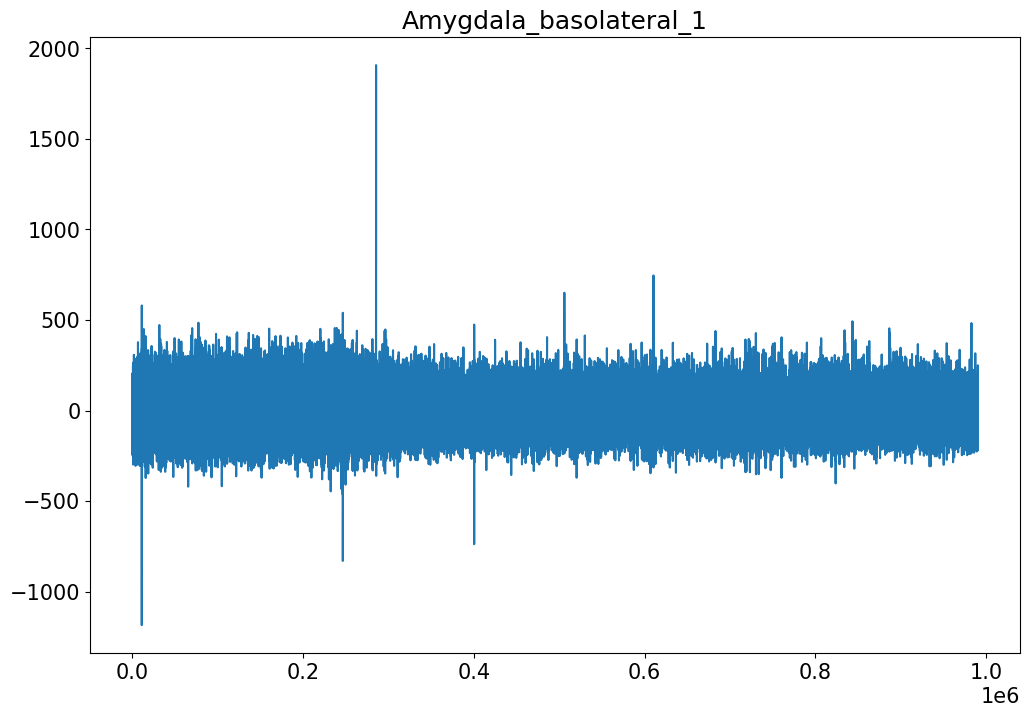

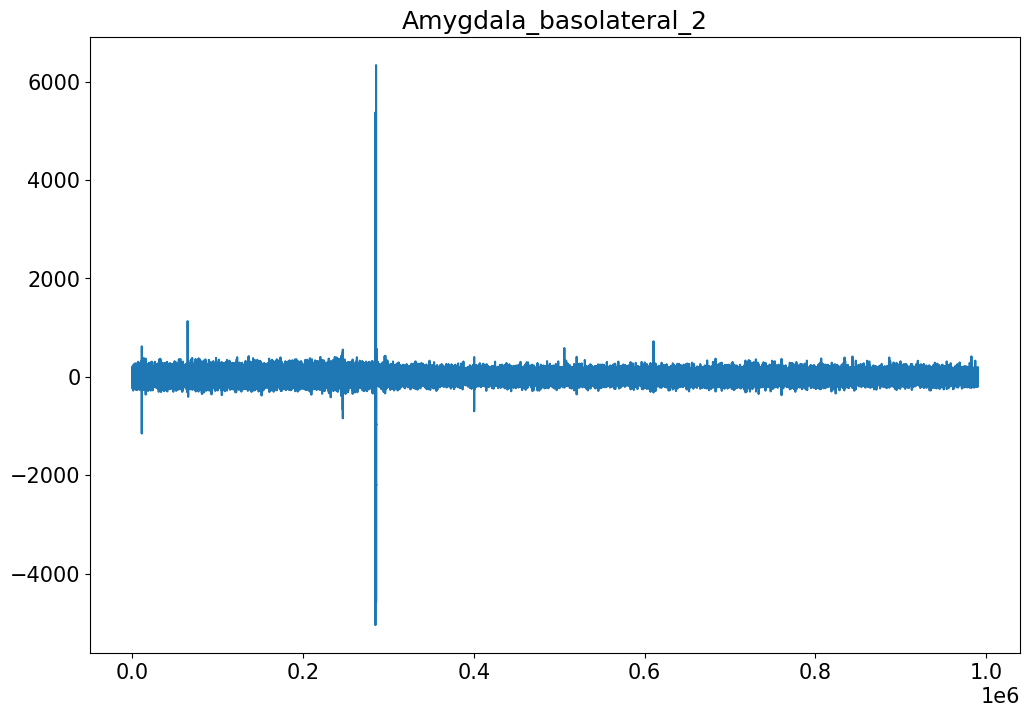

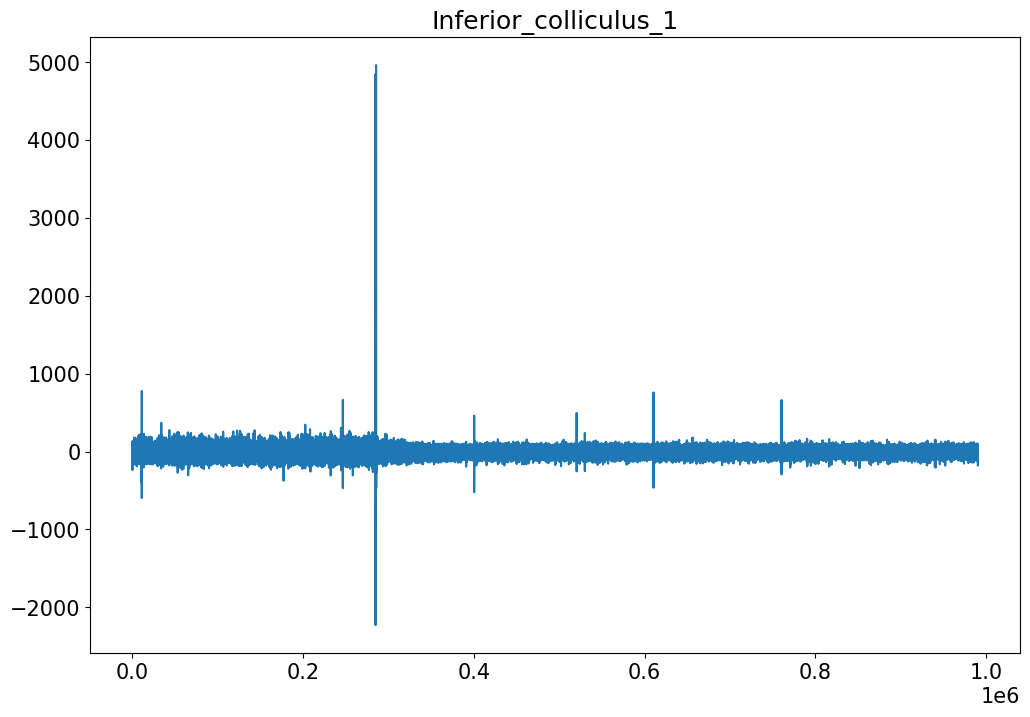

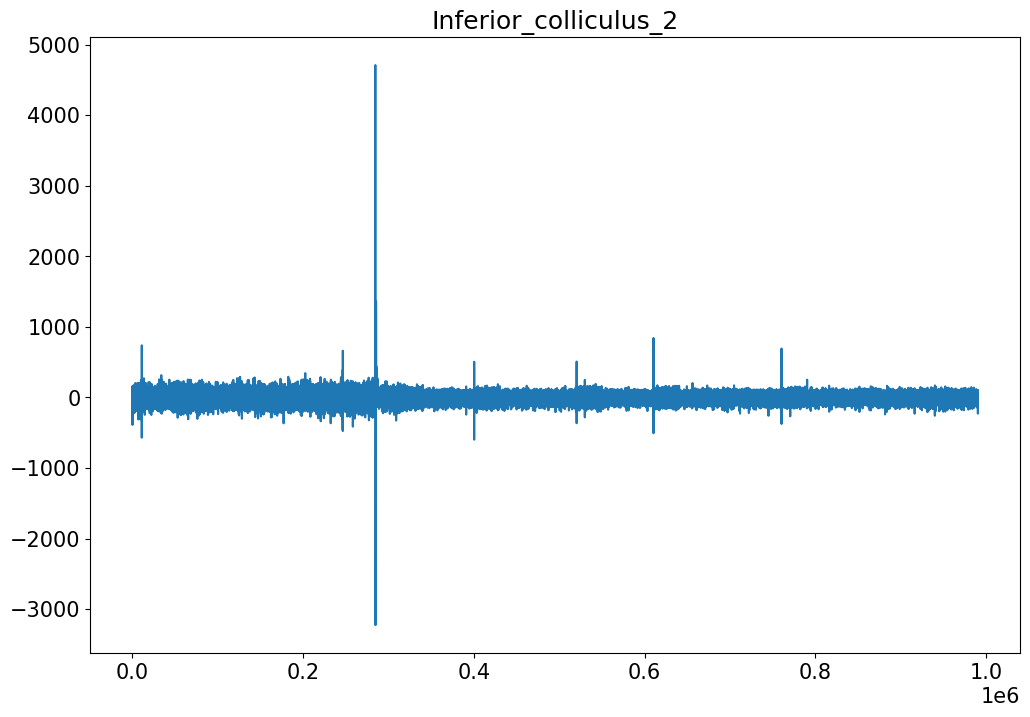

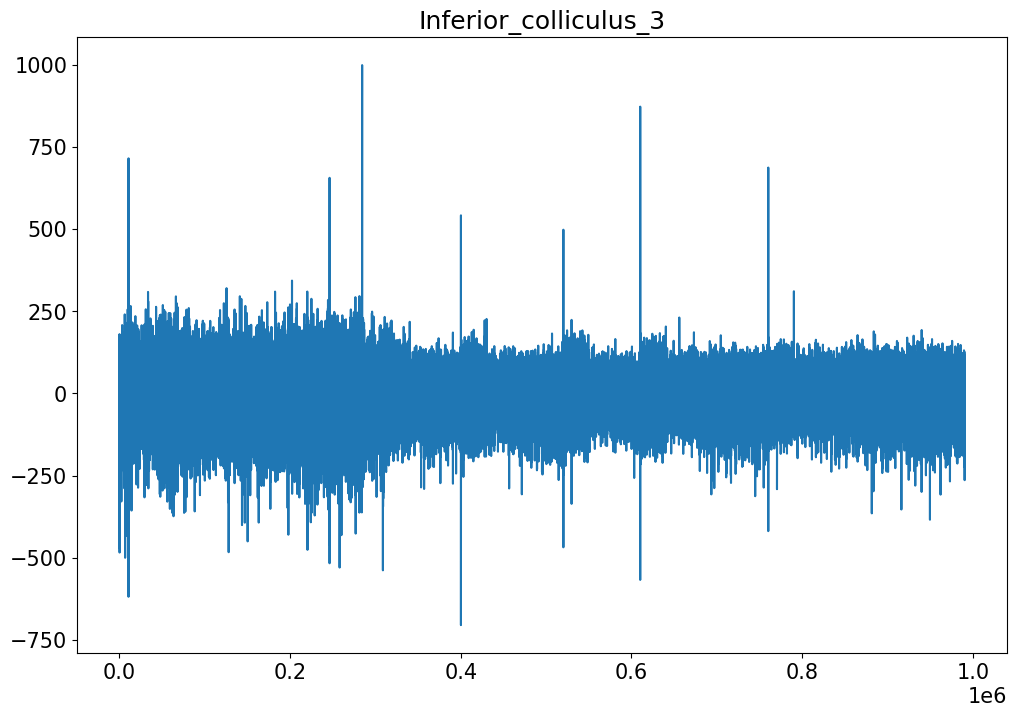

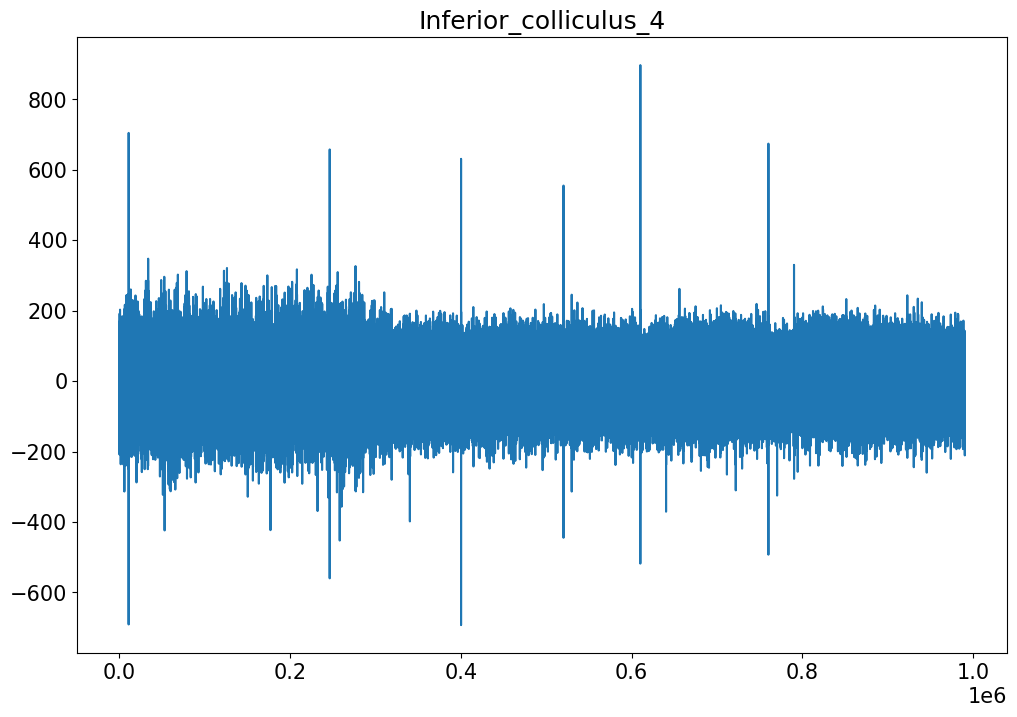

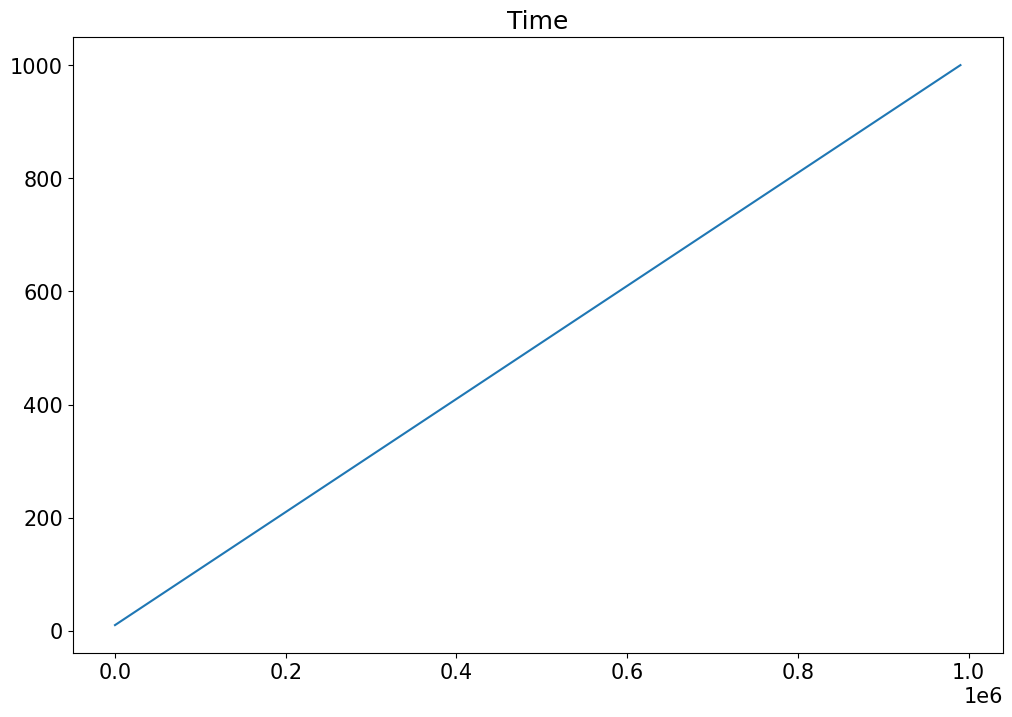

In [39]:
for column in data.columns:
    data.loc[:, column].plot()
    plt.title(column)
    plt.show()


Event: 1
start: 310187
end: 340268
time duration: 30.081

Event: 2
start: 400188
end: 430269
time duration: 30.081

Event: 3
start: 520189
end: 550270
time duration: 30.081

Event: 4
start: 610190
end: 640271
time duration: 30.081

Event: 5
start: 760191
end: 790271
time duration: 30.080000000000002

len(indices) = 10


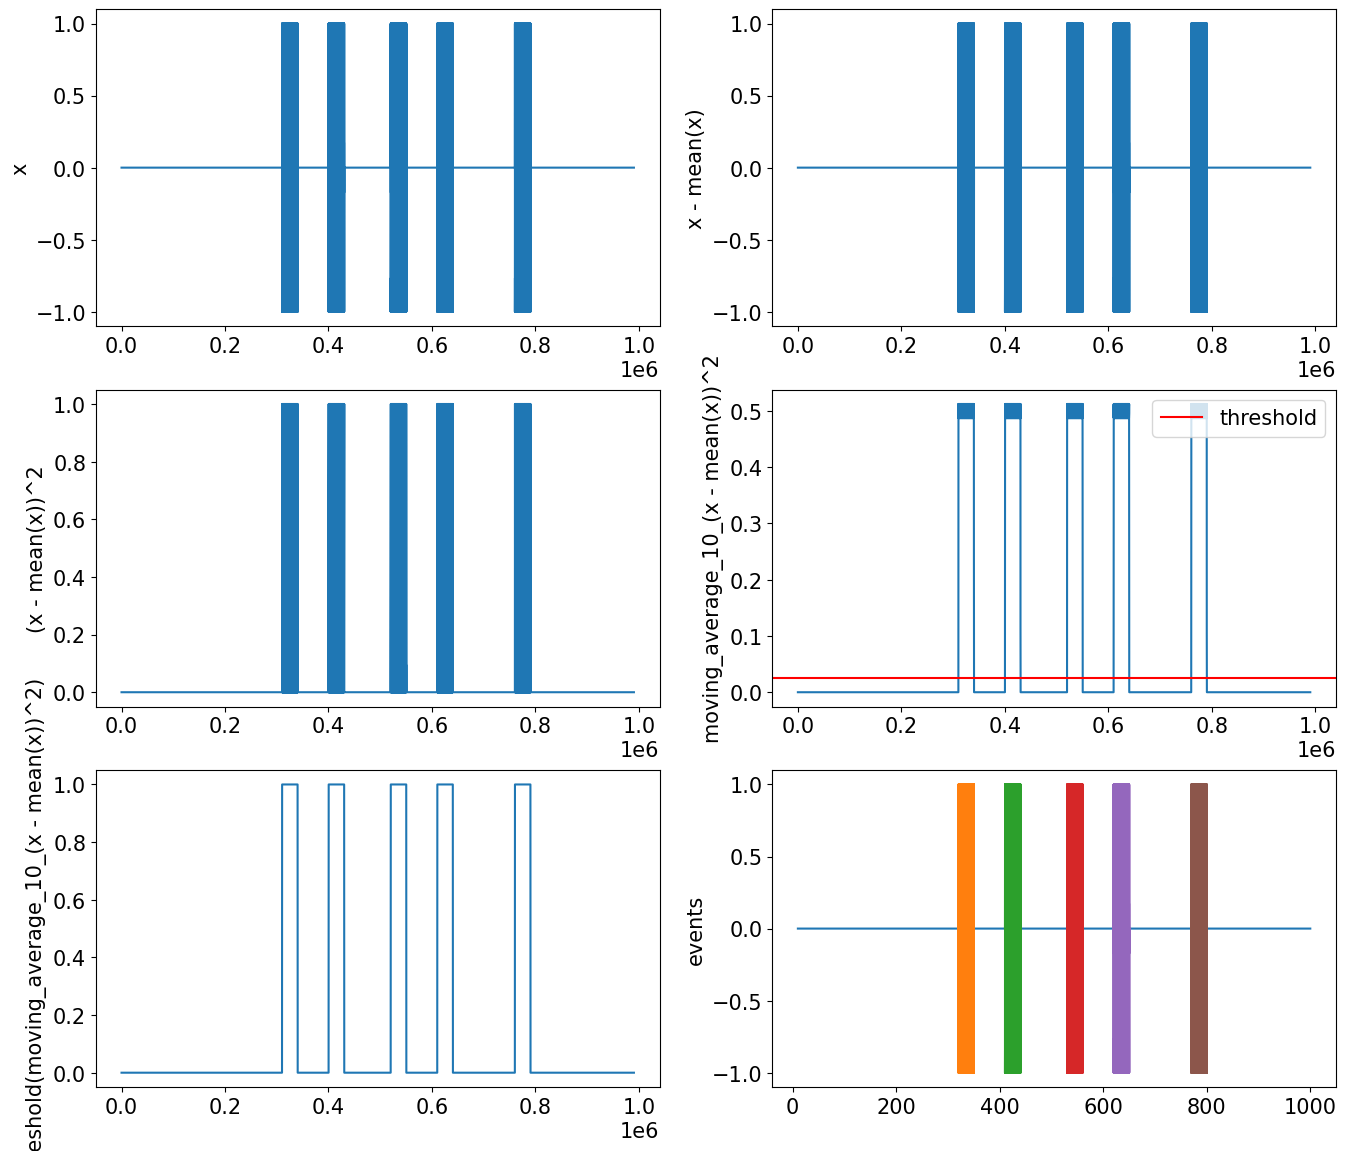

In [40]:
threshold = 0.025
window_size = 100

data = get_events(
    data=data, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSampling
)

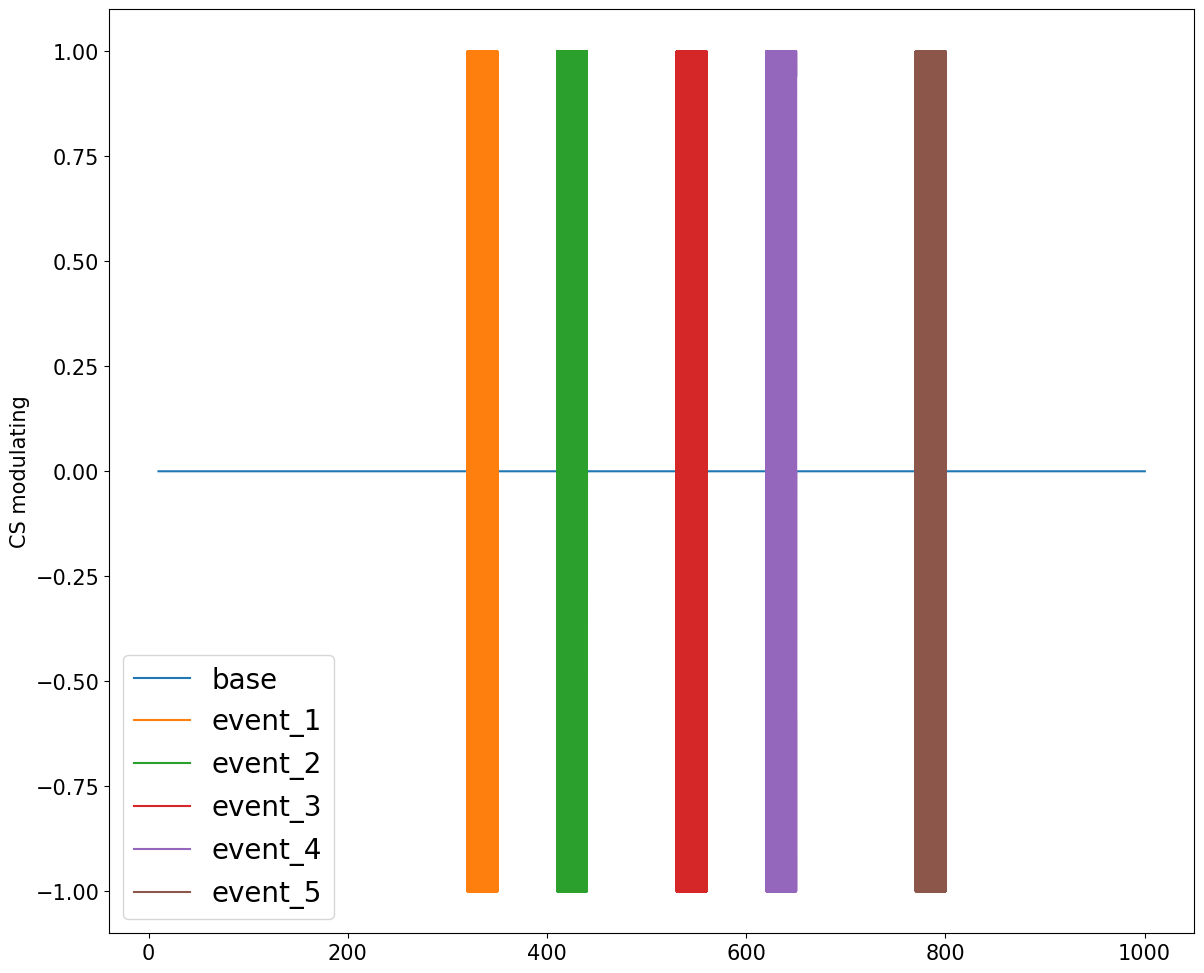

In [41]:
plt.figure(figsize=(14,12))

for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)
plt.legend(loc='lower left', prop={'size': 20})
plt.ylabel("CS modulating")

plt.show()

# Data filtering

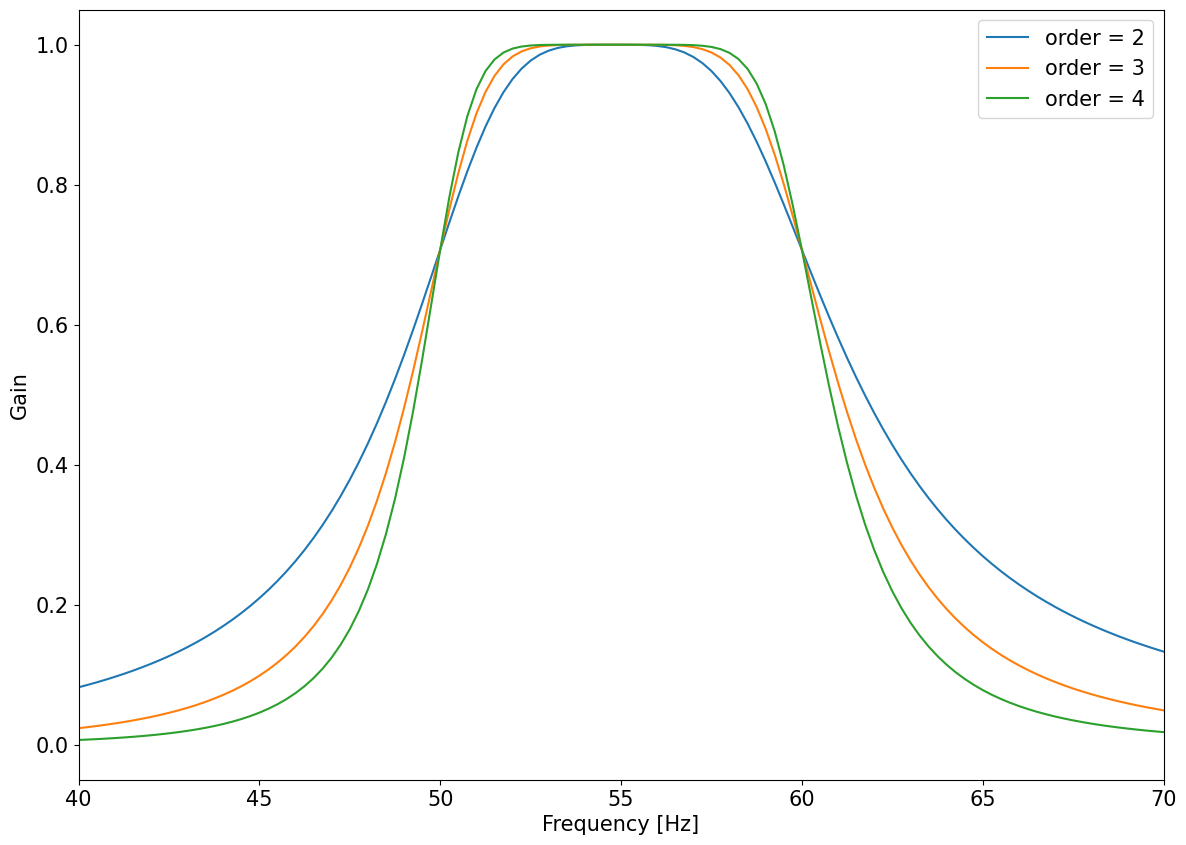

In [42]:
low_cut_hz = 50
high_cut_hz = 60
fs = 1.0/TimeSampling

plt.figure(figsize=(14,10))
plt.clf()

for order in range(2,5):
    b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs, order=order)
    w, h = signal.freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)


plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend()
plt.xlim([low_cut_hz-10, high_cut_hz+10])
plt.show()

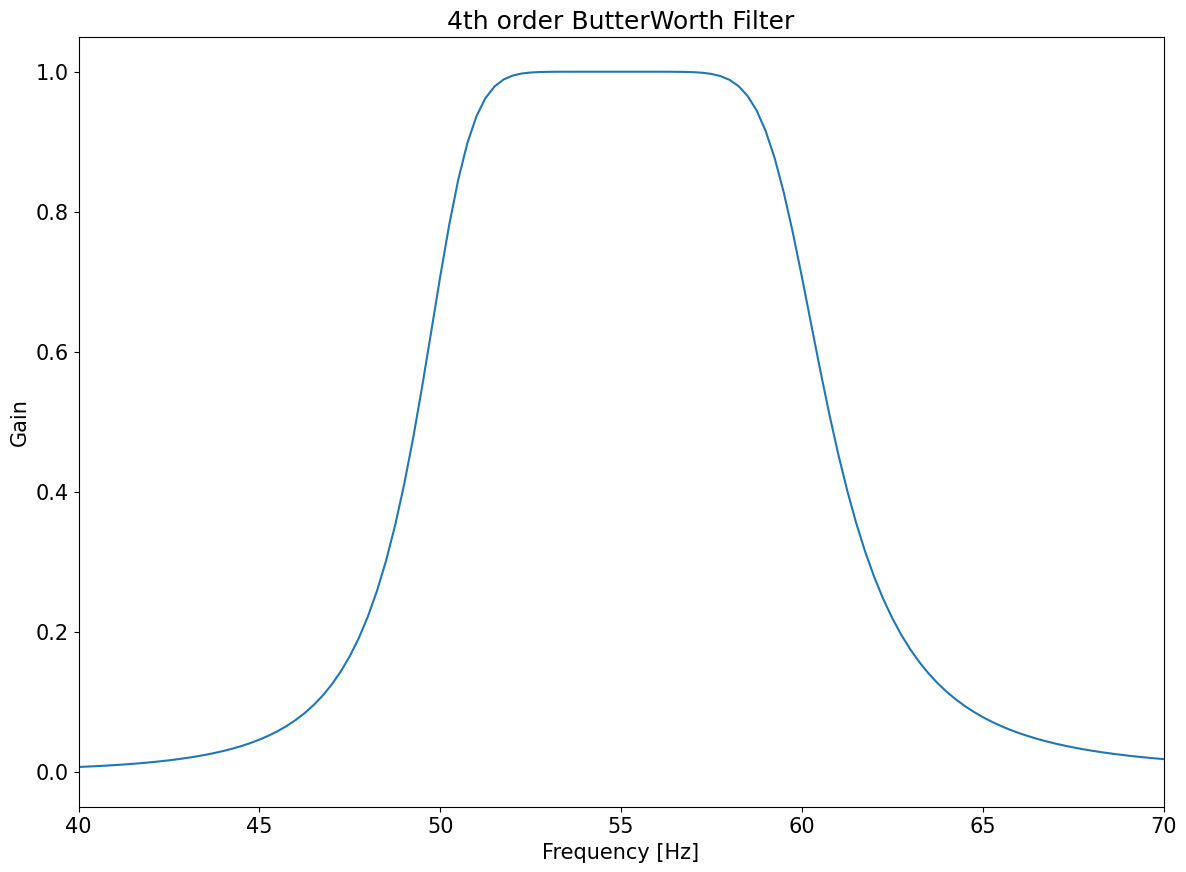

In [43]:
filter_order = 4
b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs=fs, order=filter_order)

plt.figure(figsize=(14,10))
plt.clf()
w, h = signal.freqz(b, a, fs=fs, worN=2000)
plt.plot(w, abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.xlim([low_cut_hz-10, high_cut_hz+10])
plt.title(f"{filter_order}th order ButterWorth Filter")
plt.show()

## Filtering using filtfilt to avoid phase changes

## Filtering data

In [44]:
data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event'],
      dtype='object')

In [45]:
for channel_number in range(1, 5):
    logger.info(f"Filtering the Inferior colliculus {channel_number}")
    data = data.assign(
        **{
            f"filtered_Inferior_colliculus_{channel_number}": filter_function(data.loc[:, f"Inferior_colliculus_{channel_number}"].to_numpy())
        }
    )
    
for channel_number in range(1, 3):
    
    logger.info(f"Filtering the Amygdala lateral {channel_number}")
    data = data.assign(
        **{
            f"filtered_Amygdala_lateral_{channel_number}": filter_function(data.loc[:, f"Amygdala_lateral_{channel_number}"].to_numpy())
        }
    )
    
    logger.info(f"Filtering the Amygdala basolateral {channel_number}")
    data = data.assign(
        **{
            f"filtered_Amygdala_basolateral_{channel_number}": filter_function(data.loc[:, f"Amygdala_basolateral_{channel_number}"].to_numpy())
        }
    )

logger.success(f"Done filtering!")

2023-07-02 18:41:28.050 | INFO     | __main__:<module>:2 - Filtering the Inferior colliculus 1
2023-07-02 18:41:28.089 | INFO     | __main__:<module>:2 - Filtering the Inferior colliculus 2
2023-07-02 18:41:28.181 | INFO     | __main__:<module>:2 - Filtering the Inferior colliculus 3
2023-07-02 18:41:28.266 | INFO     | __main__:<module>:2 - Filtering the Inferior colliculus 4
2023-07-02 18:41:28.358 | INFO     | __main__:<module>:11 - Filtering the Amygdala lateral 1
2023-07-02 18:41:28.448 | INFO     | __main__:<module>:18 - Filtering the Amygdala basolateral 1
2023-07-02 18:41:28.540 | INFO     | __main__:<module>:11 - Filtering the Amygdala lateral 2
2023-07-02 18:41:28.636 | INFO     | __main__:<module>:18 - Filtering the Amygdala basolateral 2
2023-07-02 18:41:28.735 | SUCCESS  | __main__:<module>:25 - Done filtering!


In [46]:
data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event',
       'filtered_Inferior_colliculus_1', 'filtered_Inferior_colliculus_2',
       'filtered_Inferior_colliculus_3', 'filtered_Inferior_colliculus_4',
       'filtered_Amygdala_lateral_1', 'filtered_Amygdala_basolateral_1',
       'filtered_Amygdala_lateral_2', 'filtered_Amygdala_basolateral_2'],
      dtype='object')

## Decimation

In [47]:
desired_frequency_sampling = 150

data, TimeSampling, FrequencySampling = decimate(data, desired_frequency_sampling=desired_frequency_sampling)

data_backup = data

2023-07-02 18:41:28.751 | INFO     | __main__:decimate:6 - The time sampling is 0.001 seconds and the frequency is 1.0 kHz
2023-07-02 18:41:28.751 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:7
2023-07-02 18:41:28.752 | INFO     | __main__:decimate:24 - The new time sampling is 0.007 s and the new frequency is 142.85714285714286 Hz


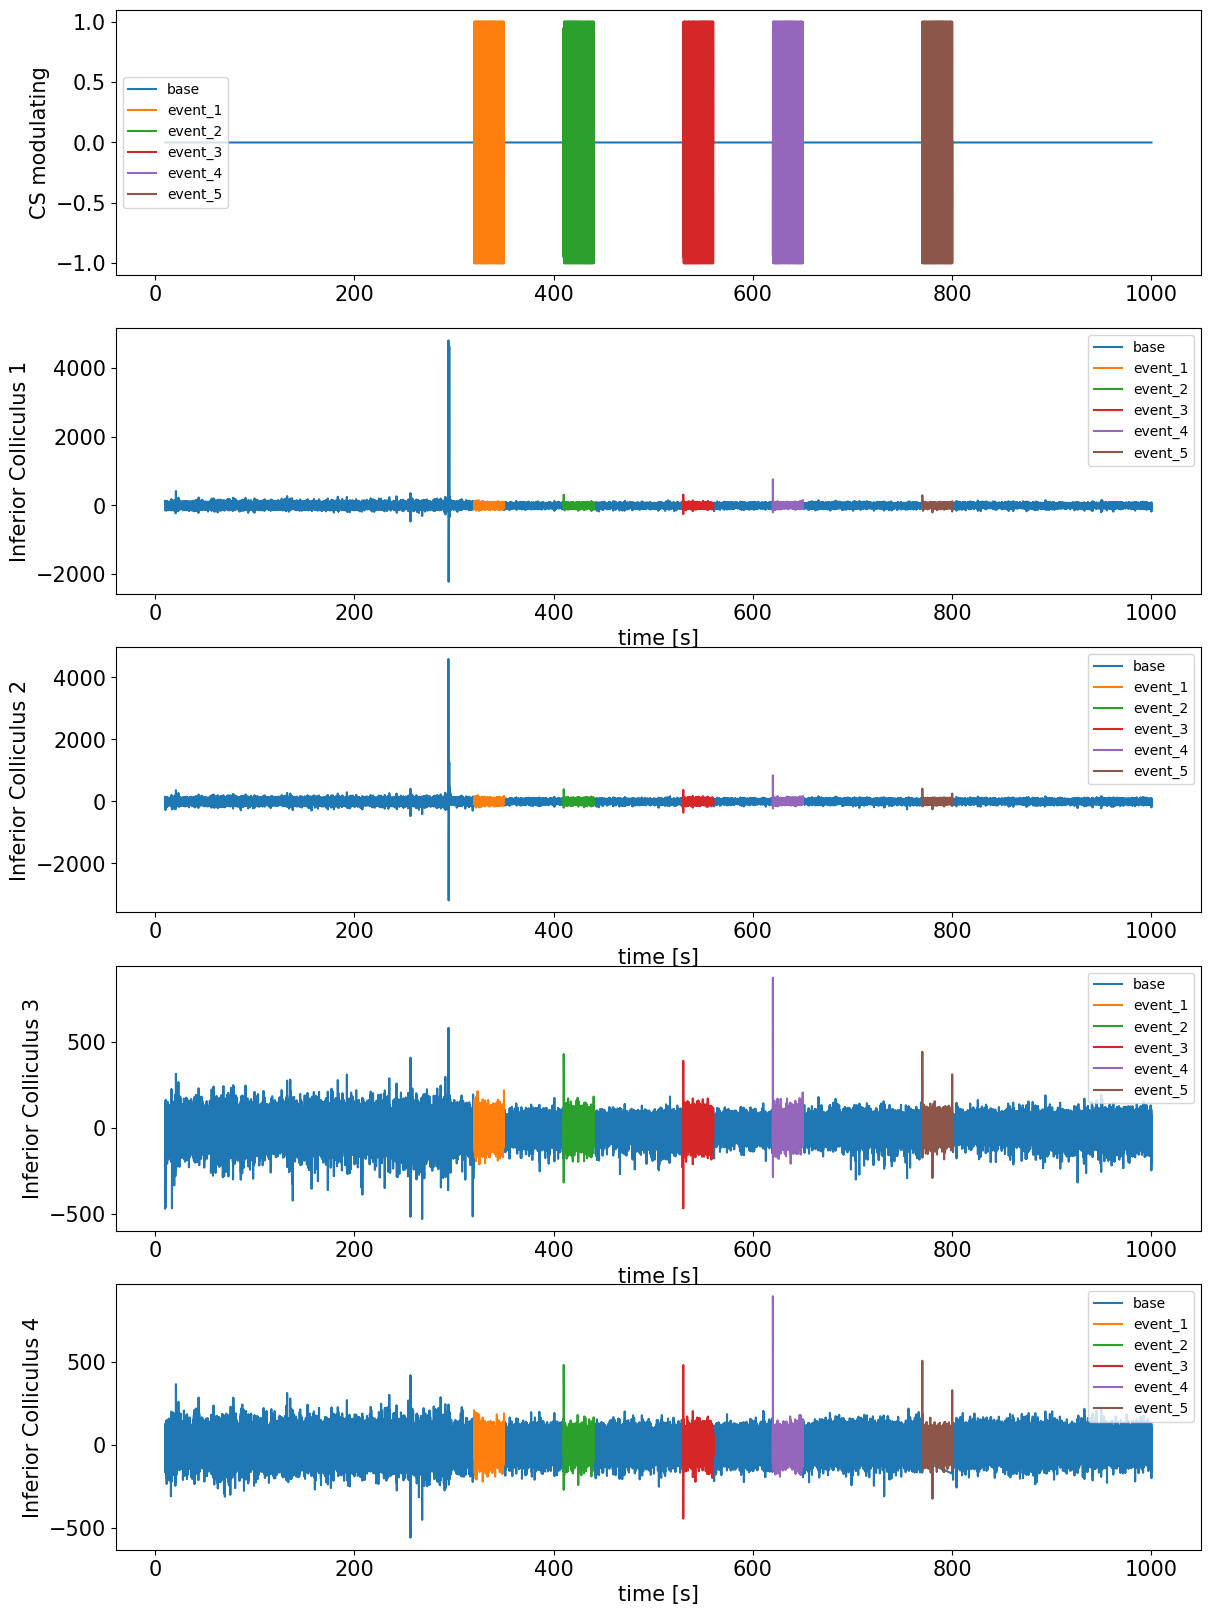

In [48]:
plt.figure(figsize=(14,20))

plt.subplot(511)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)
plt.legend(loc=6, prop={'size': 10})
plt.ylabel("CS modulating")

plt.subplot(512)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "Inferior_colliculus_1"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus 1")
plt.legend(prop={'size': 10})

plt.subplot(513)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "Inferior_colliculus_2"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus 2")
plt.legend(prop={'size': 10})

plt.subplot(514)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "Inferior_colliculus_3"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus 3")
plt.legend(prop={'size': 10})

plt.subplot(515)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "Inferior_colliculus_4"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus 4")
plt.legend(prop={'size': 10})

plt.show()

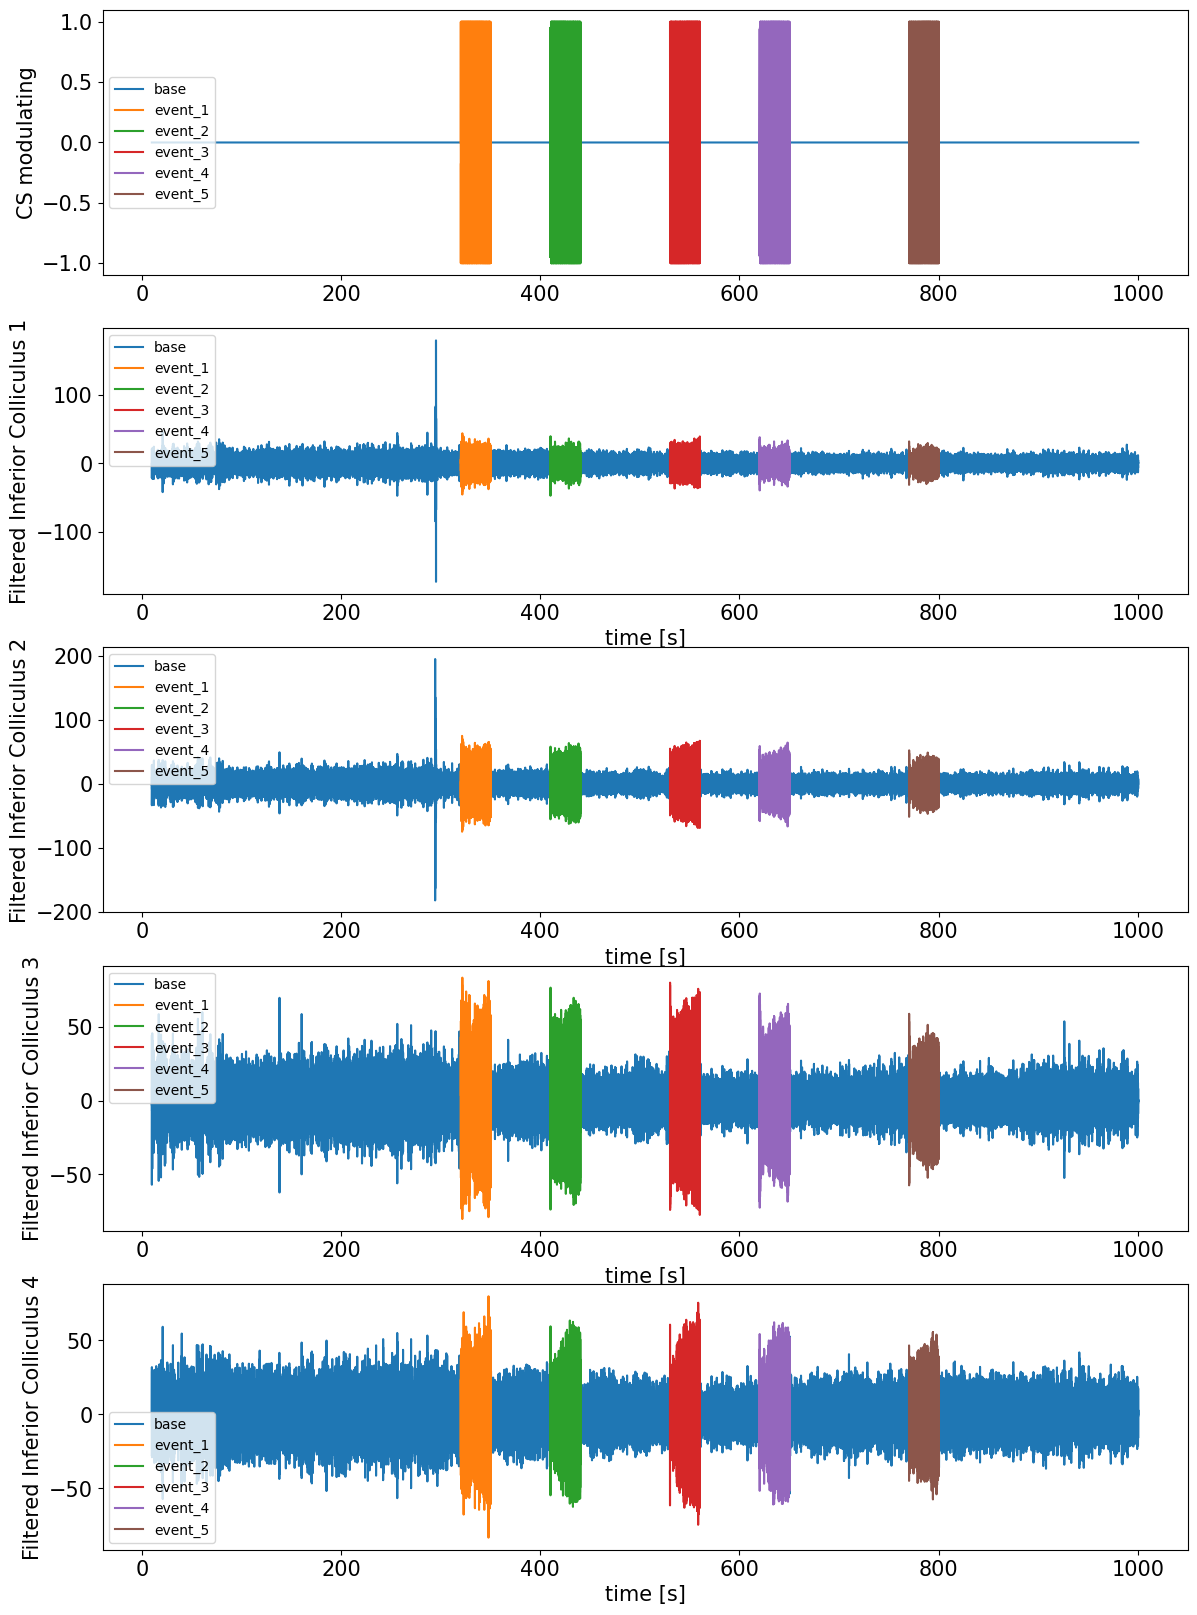

In [49]:
plt.figure(figsize=(14,20))

plt.subplot(511)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)
plt.legend(loc=6, prop={'size': 10})
plt.ylabel("CS modulating")

plt.subplot(512)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "filtered_Inferior_colliculus_1"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Filtered Inferior Colliculus 1")
plt.legend(prop={'size': 10})

plt.subplot(513)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "filtered_Inferior_colliculus_2"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Filtered Inferior Colliculus 2")
plt.legend(prop={'size': 10})

plt.subplot(514)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "filtered_Inferior_colliculus_3"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Filtered Inferior Colliculus 3")
plt.legend(prop={'size': 10})

plt.subplot(515)
for event in data.event.unique():
    plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "filtered_Inferior_colliculus_4"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Filtered Inferior Colliculus 4")
plt.legend(prop={'size': 10})

plt.show()

# Selecting Data to model - EVENT 1

In [50]:
event_number = 1
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0
)

In [51]:
event_data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event',
       'filtered_Inferior_colliculus_1', 'filtered_Inferior_colliculus_2',
       'filtered_Inferior_colliculus_3', 'filtered_Inferior_colliculus_4',
       'filtered_Amygdala_lateral_1', 'filtered_Amygdala_basolateral_1',
       'filtered_Amygdala_lateral_2', 'filtered_Amygdala_basolateral_2'],
      dtype='object')

In [52]:
y = event_data.Inferior_colliculus_2.to_numpy()

In [53]:
u = np.vstack([event_data.loc[:, dict_inputs[input_model]] for input_model in inputs])

In [54]:
u.shape

(4, 4296)

In [55]:
path_files = f"err_model_{id_file}_{id_results}_err.pkl"
err_already_calculated: bool = os.path.isfile(path_files)

if err_already_calculated and not replace_err:
    logger.info("ERR already calculated. Loading...")
    err_out, termos, psi = load_err()
    logger.success("ERR loaded!")
else:
    logger.info("ERR not calculated yet. Generating ERR...")

2023-07-02 18:41:32.923 | INFO     | __main__:<module>:5 - ERR already calculated. Loading...
2023-07-02 18:41:32.923 | INFO     | __main__:load_err:5 - loading err...
2023-07-02 18:41:32.924 | INFO     | __main__:load_err:9 - loading termos...
2023-07-02 18:41:32.924 | INFO     | __main__:load_err:13 - loading psi...
2023-07-02 18:41:32.926 | SUCCESS  | __main__:load_err:17 - Done loading err data!
2023-07-02 18:41:32.927 | SUCCESS  | __main__:<module>:7 - ERR loaded!


### Obtendo o resultado do Critério de Redução de Erro 

In [56]:
if not err_already_calculated or replace_err:

    err_obj = err(
        ny=max_y_delays,
        nu=max_u_delays,
        n_lin=degree_of_non_linearity,
        yid=y,
        uid=u,
        cte=True,
    )

    start_time = perf_counter()

    err_out, termos, psi = err_obj.run(print_result=True)

    end_time = perf_counter()

    save_err(err_out, termos, psi)

### Obtendo o Critério de Informação de Akaike para a matriz $\Psi$ gerada pelo ERR

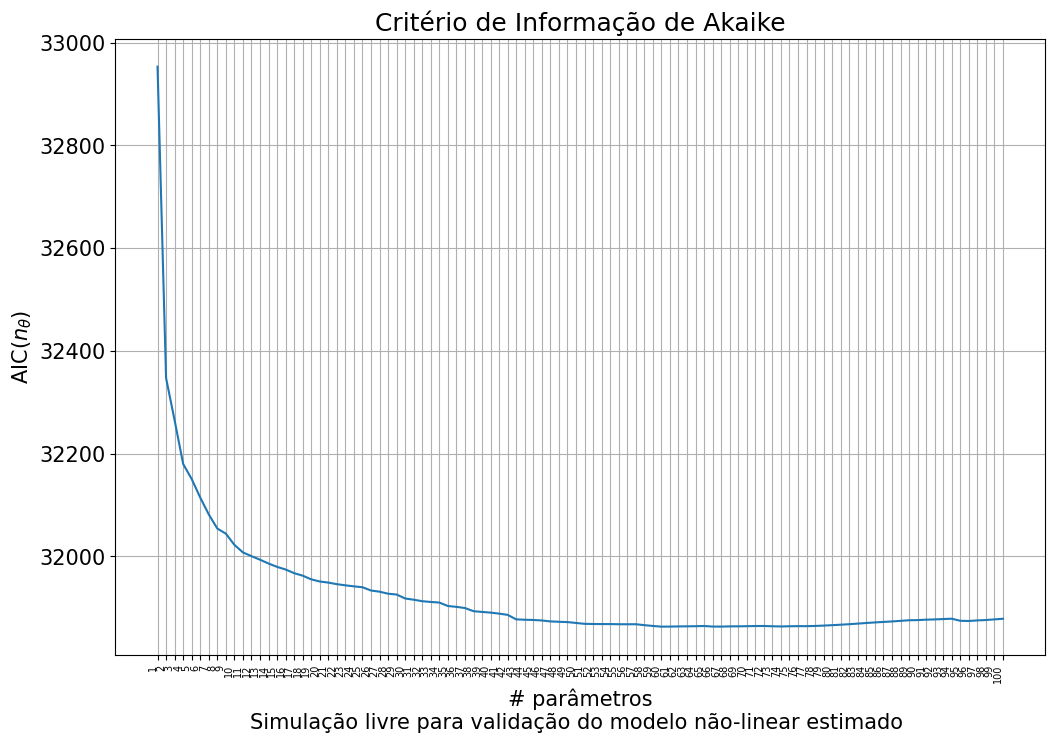

In [57]:
Phi = np.array([])

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, residuos = MQ(Phi.T, y[max_delays:])
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y), var_xi))
    
    parameters = np.append(parameters, i+1)
    
max_number_of_parameters = 100  # float("Inf")
plt.plot(parameters[parameters<=max_number_of_parameters], aic[parameters<=max_number_of_parameters])
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Simulação livre para validação do modelo não-linear estimado "
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.xticks(parameters[parameters<=max_number_of_parameters], rotation=90, ha='right', fontsize=7)
plt.grid()
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 5 primeiros regressores listados, que consistem das combinações de número 1, 14, 7, 2 e 5, da tabela de termos mostrada abaixo:

In [58]:
number_of_selected_terms = 44

In [59]:
psi_mq = np.vstack([psi[:,i] for i in err_out["ordem"][:number_of_selected_terms]]).T

theta, xi = MQ(psi_mq, y[max_delays:])

print(f"Theta ordenado: {theta}")

Theta ordenado: [-2.90341710e+01  3.64144316e-01  8.35042885e-02 -2.67349816e-01
  1.72079059e-01  1.71950344e-01 -2.26540315e-01 -1.57186089e-01
  1.75878605e+01 -2.63164069e-01  1.90411180e-01 -2.26689214e-02
  4.69926076e-02  6.30930758e-04  7.54377927e-04 -9.49805020e-02
  1.01744546e-01  2.34488066e-01 -1.11822397e-01  1.40543030e-01
  1.94906789e-03 -1.82707346e-03 -1.33373304e-03  1.24372964e-03
 -2.45354095e-01  2.99270305e-01  9.26887545e-04 -7.78167965e-04
  1.23925805e-01 -2.28272838e-01  4.33472155e+01  2.68312595e+01
 -5.09875373e-02 -2.64810686e-03  1.94893114e-03  3.05451239e-01
 -1.42822414e-01  1.26719644e-03 -9.64648912e-04  1.18817102e-03
 -1.36504907e-03  2.28434002e-01 -1.88537369e-01 -8.99246741e-04]


Assim, o modelo NARX escolhido é:

In [60]:
terms_dict = termos.iloc[err_out["ordem"][:number_of_selected_terms]].T.to_dict()

model = []
model_dict = {}
model_str = []

for reg_number, line in terms_dict.items():
    term = ""
    for reg, power in line.items():
        term += " * " if term and power else ""
        term += reg if power > 0 else ""
        term += f"**{int(power)}" if power > 1 else ""
    term += "1"*(not bool(term))
    term = term.replace("(", "[").replace(")", "]")
    model.append(term)
    model_dict[reg_number] = term
    
print("\n\nOrderedTermos:\n")

for i, term in enumerate(model_dict.values()):
    print(f"{str(i).zfill(2)}: err: {'{:e}'.format((err_out['valor'][:number_of_selected_terms])[i])} - {term}")
    

print("\n\nTermos:\n")

for line, term in model_dict.items():
    print(f"{line}: {term}")
    
terms_per_line = 4
print("\ny(k) = ", end="")
for i, term in enumerate(model, start=1):
    print(f"{term}{' + '*(i not in (len(model),))}", end="\n" if not i % terms_per_line else "")
    
print("\n\n\n")



OrderedTermos:

00: err: 2.337763e-01 - u[0, k-2]
01: err: 1.011516e-01 - u[1, k-1]
02: err: 1.293329e-02 - u[2, k-3]
03: err: 1.307071e-02 - u[1, k-4]
04: err: 4.654340e-03 - u[1, k-2]
05: err: 5.597078e-03 - u[3, k-1]
06: err: 5.086752e-03 - u[1, k-3]
07: err: 4.267493e-03 - y[k-1]
08: err: 1.718748e-03 - u[0, k-1] * u[0, k-3]
09: err: 3.401078e-03 - y[k-1] * u[0, k-1]
10: err: 2.225554e-03 - u[0, k-1] * u[1, k-1]
11: err: 1.462929e-03 - y[k-2] * u[0, k-4]
12: err: 1.268738e-03 - u[3, k-3]
13: err: 1.172353e-03 - u[1, k-2] * u[3, k-1]
14: err: 1.401637e-03 - u[1, k-4]**2
15: err: 1.006511e-03 - u[2, k-2]
16: err: 1.287904e-03 - y[k-2]
17: err: 9.658912e-04 - y[k-4]
18: err: 1.288448e-03 - u[2, k-4]
19: err: 8.594735e-04 - y[k-3]
20: err: 5.804277e-04 - y[k-1] * u[2, k-2]
21: err: 7.000589e-04 - u[1, k-2] * u[2, k-1]
22: err: 5.947205e-04 - y[k-4] * u[3, k-2]
23: err: 5.413751e-04 - u[1, k-2] * u[2, k-4]
24: err: 4.644335e-04 - u[0, k-4] * u[1, k-3]
25: err: 1.246144e-03 - y[k-3] * 

Validação utilizando a segunda metade da massa de dados:

In [61]:
y_free = eval_model_SISO_NARX(
    model=model, 
    theta=theta, 
    u=u, 
    y=y,
    y0=np.zeros(3)
)

Carregando a saída da validação e os resíduos de estimação do modelo cuja estrutura foi obtida no Livro-texto, na Lista de Exercícios 9 

#### Plotando as curvas de validação

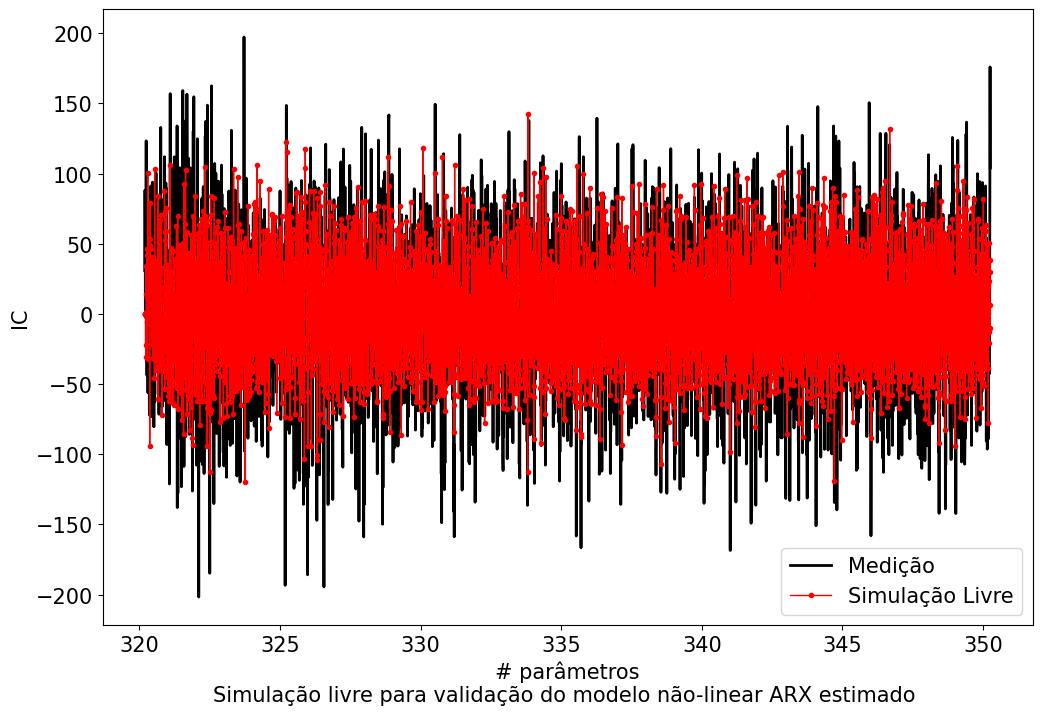

In [62]:
y_validacao = y_free
time_to_plot = event_data.Time.to_numpy()

plt.figure()
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

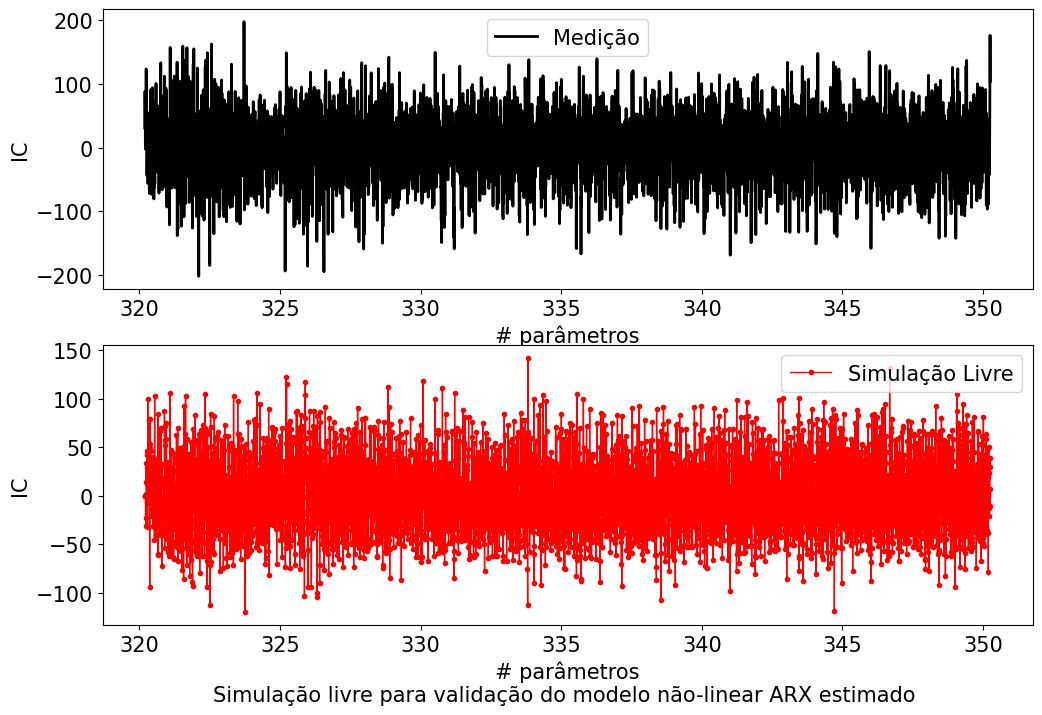

In [63]:
y_validacao = y_free
time = event_data.Time.to_numpy()

plt.figure()
plt.subplot(211)
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.subplot(212)
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Ambos os modelos apresentaram curvas estáticas similares e não serão apresentadas neste trabalho por já constarem nas listas de Exercícios anteriores.

#### Cálculo do RMSD

In [64]:
rmsd = RMSD(y, y_validacao)

print(f"RMSD Modelo Estimado ({len(theta)} parâmetros): {np.round(rmsd, 5)}")

RMSD Modelo Estimado (44 parâmetros): 45.02656


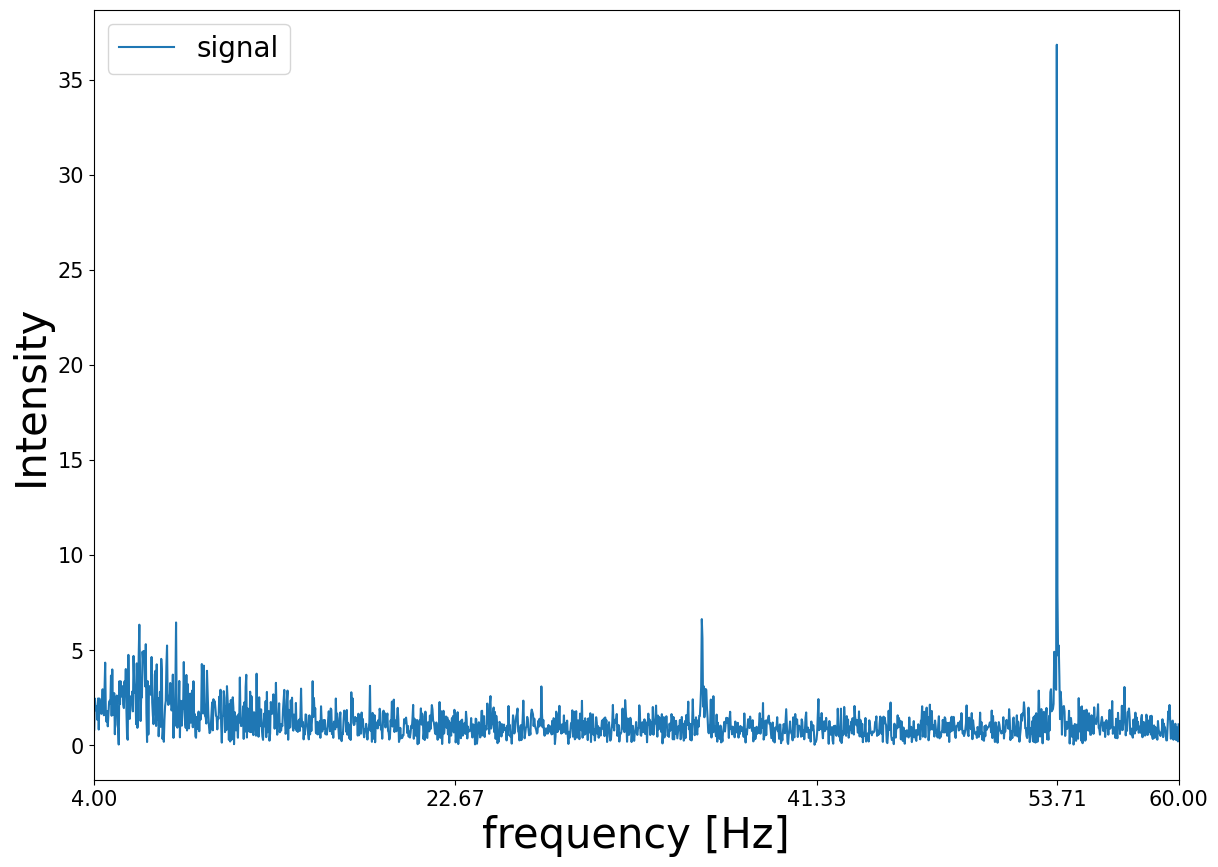

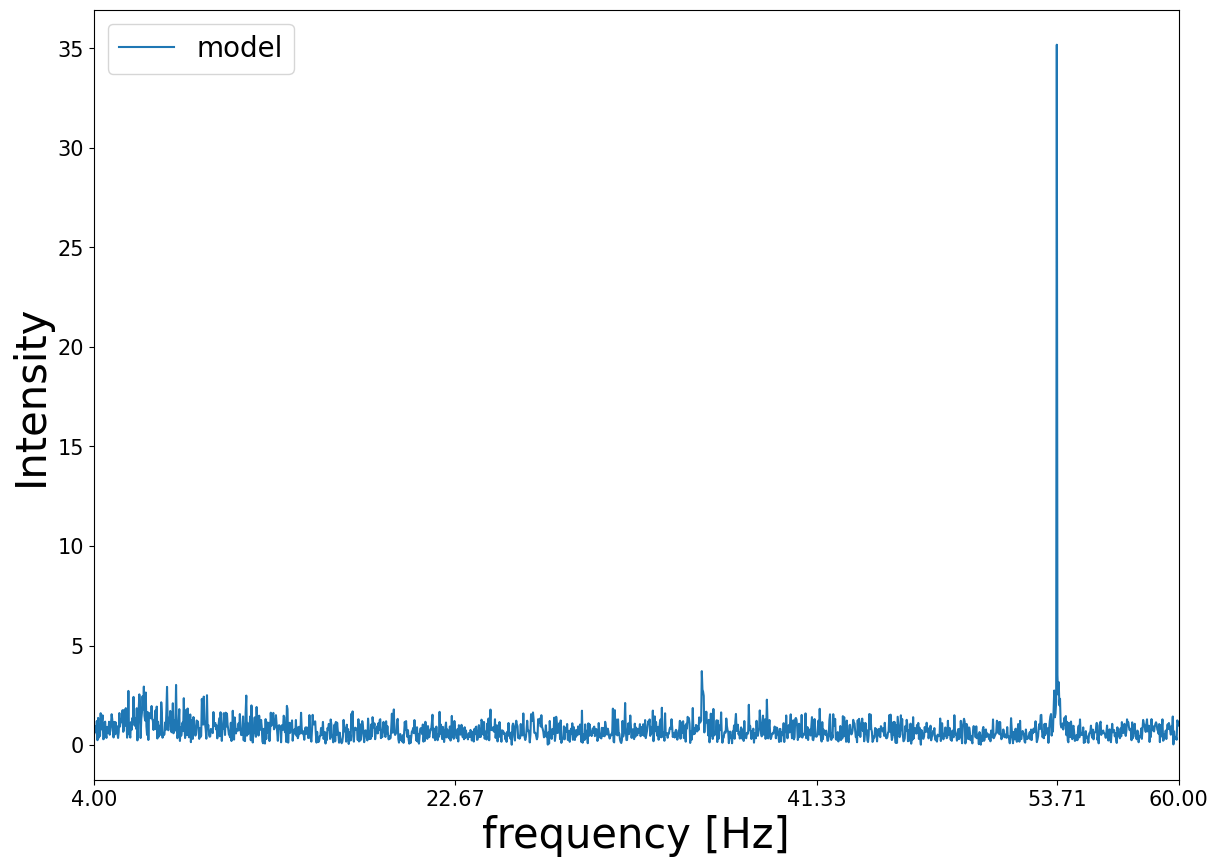

In [65]:
y = y_signal = event_data.Inferior_colliculus_2.to_numpy()

lim = (4, 60)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

fft_data = {
    "signal": y,
    "model": y_validacao
}

for name_data, data in fft_data.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    frequency, intensity, angle = fft(x=data, fs=FrequencySampling)
    y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
    x = (frequency)[(frequency>=lim[0])&(frequency<=lim[1])]
    
    ax.plot(x, y, label=f"{name_data}")
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend(prop={'size': 20})
    plt.savefig(
        f"FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()


In [66]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)

hosa_df = None

if load_already_calculated and not replace_hosa:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")

2023-07-02 18:41:37.364 | INFO     | __main__:<module>:12 - HOSA not calculated yet. Generating hosa...


In [67]:
if (not load_already_calculated or replace_hosa) and generate_hosa:

    frequency_array = np.arange(start=4, stop=60, step=0.01)

    TDQS_PARAMETERS = {
        "frequency_array": frequency_array,
        "phase_step": 0.01
    }

    df_amps = pd.DataFrame()
    df_phases = pd.DataFrame()
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdts for each channel, in parallel

    tdqs_object = TDQS(
        frequency_sampling=FrequencySampling,
        frequency_array=TDQS_PARAMETERS.get("frequency_array"),
        fmin=None,
        fmax=None,
        freq_step=None,
        phase_step=TDQS_PARAMETERS["phase_step"]
    )

    f = lambda x: tdqs_object.run_td4spectrum(x)

    with Pool() as pool:

        for result in pool.map(
            f, 
            [
                {
                    signal_name: signal_array
                } for signal_name, signal_array in {"signal": y_signal, "model": y_validacao}.items()
            ]
        ):

            signal_name, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum,
                tetraspectrum,
                phase_tetraspectrum         
            ) = result_data

            if "frequency" not in df_amps.columns:
                df_amps = df_amps.assign(frequency=frequency_array)
            if "frequency" not in df_amps_signal.columns:
                df_amps_signal = df_amps_signal.assign(frequency=frequency_array)
            if "frequency" not in df_amps_model.columns:
                df_amps_model = df_amps_model.assign(frequency=frequency_array)

            df_amps = df_amps.assign(**{f"tds_amp_{signal_name}": spectrum})
            df_phases = df_phases.assign(**{f"tds_phase_{signal_name}": phase_spectrum})

            df_amps = df_amps.assign(**{f"tdbs_amp_{signal_name}": bispectrum})
            df_phases = df_phases.assign(**{f"tdbs_phase_{signal_name}": phase_bispectrum})

            df_amps = df_amps.assign(**{f"tdts_amp_{signal_name}": trispectrum})
            df_phases = df_phases.assign(**{f"tdts_phase_{signal_name}": phase_trispectrum})

            df_amps = df_amps.assign(**{f"tdqs_amp_{signal_name}": tetraspectrum})
            df_phases = df_phases.assign(**{f"tdqs_phase_{signal_name}": phase_tetraspectrum})
            
            if signal_name == "signal":
                df_amps_signal = df_amps_signal.assign(**{f"tds_amp": spectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": bispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": trispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_signal = df_phases_signal.assign(**{f"tds_phase": phase_spectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdqs_phase": phase_tetraspectrum})
                
            elif signal_name == "model":
                df_amps_model = df_amps_model.assign(**{f"tds_amp": spectrum})
                df_amps_model = df_amps_model.assign(**{f"tdbs_amp": bispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdts_amp": trispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_model = df_phases_model.assign(**{f"tds_phase": phase_spectrum})
                df_phases_model = df_phases_model.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdqs_phase": phase_tetraspectrum})



    hosa_df = pd.concat([df_amps, df_phases], axis=1)

    
    
    
    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done processing data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")
    
elif hosa_df is not None:
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()
    
    df_amps_signal = df_amps_signal.assign(frequency=hosa_df.frequency)
    df_amps_signal = df_amps_signal.assign(**{f"tds_amp": hosa_df.tds_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": hosa_df.tdts_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_signal})
    
    df_amps_model = df_amps_model.assign(frequency=hosa_df.frequency)
    df_amps_model = df_amps_model.assign(**{f"tds_amp": hosa_df.tds_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdts_amp": hosa_df.tdts_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_model})

2023-07-02 18:41:37.378 | INFO     | __main__:<module>:19 - Processing the tdqs... This may take a while...



Running tdqs for event signal and signal of len 4296Running tdqs for event model and signal of len 4296



 99% (3521142 of 3522400) |############# | Elapsed Time: 0:04:55 ETA:   0:00:002023-07-02 18:46:33.118 | SUCCESS  | __main__:<module>:111 - Done processing data. Elapsed time: 04m55s


Running tdqs for event signal and signal of len 4297Running tdqs for event model and signal of len 4297



 99% (3521142 of 3522400) |############# | Elapsed Time: 0:04:59 ETA:   0:00:00

Running tdqs for event signal and signal of len 4297Running tdqs for event model and signal of len 4297



 99% (3521142 of 3522400) |############# | Elapsed Time: 0:04:56 ETA:   0:00:00

Running tdqs for event signal and signal of len 4297
Running tdqs for event model and signal of len 4297


 99% (3521771 of 3522400) |############# | Elapsed Time: 0:04:58 ETA:   0:00:00

Running tdqs for event model and signal of len 4296Running tdqs for event signal and signal of len 4296



 99% (3521142 of 3522400) |############# | Elapsed Time: 0:04:56 ETA:   0:00:00

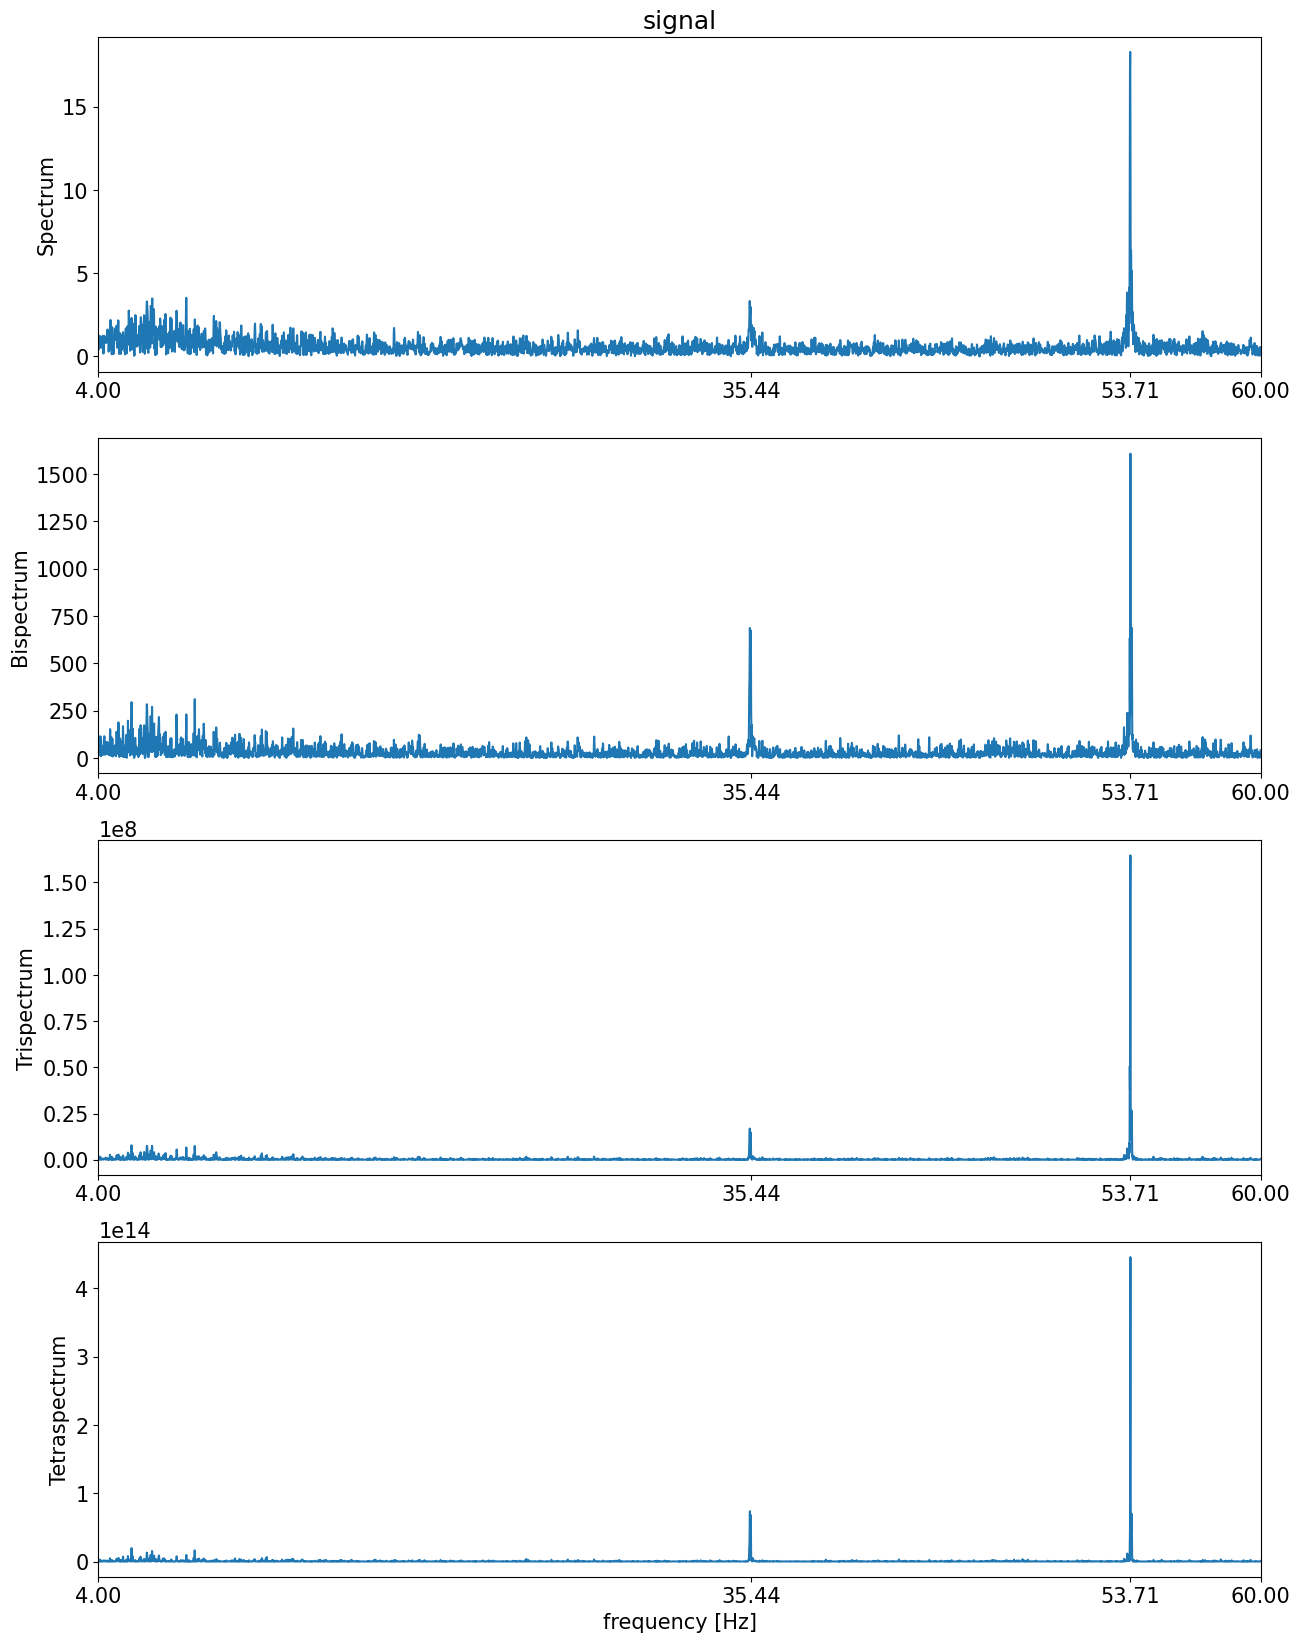

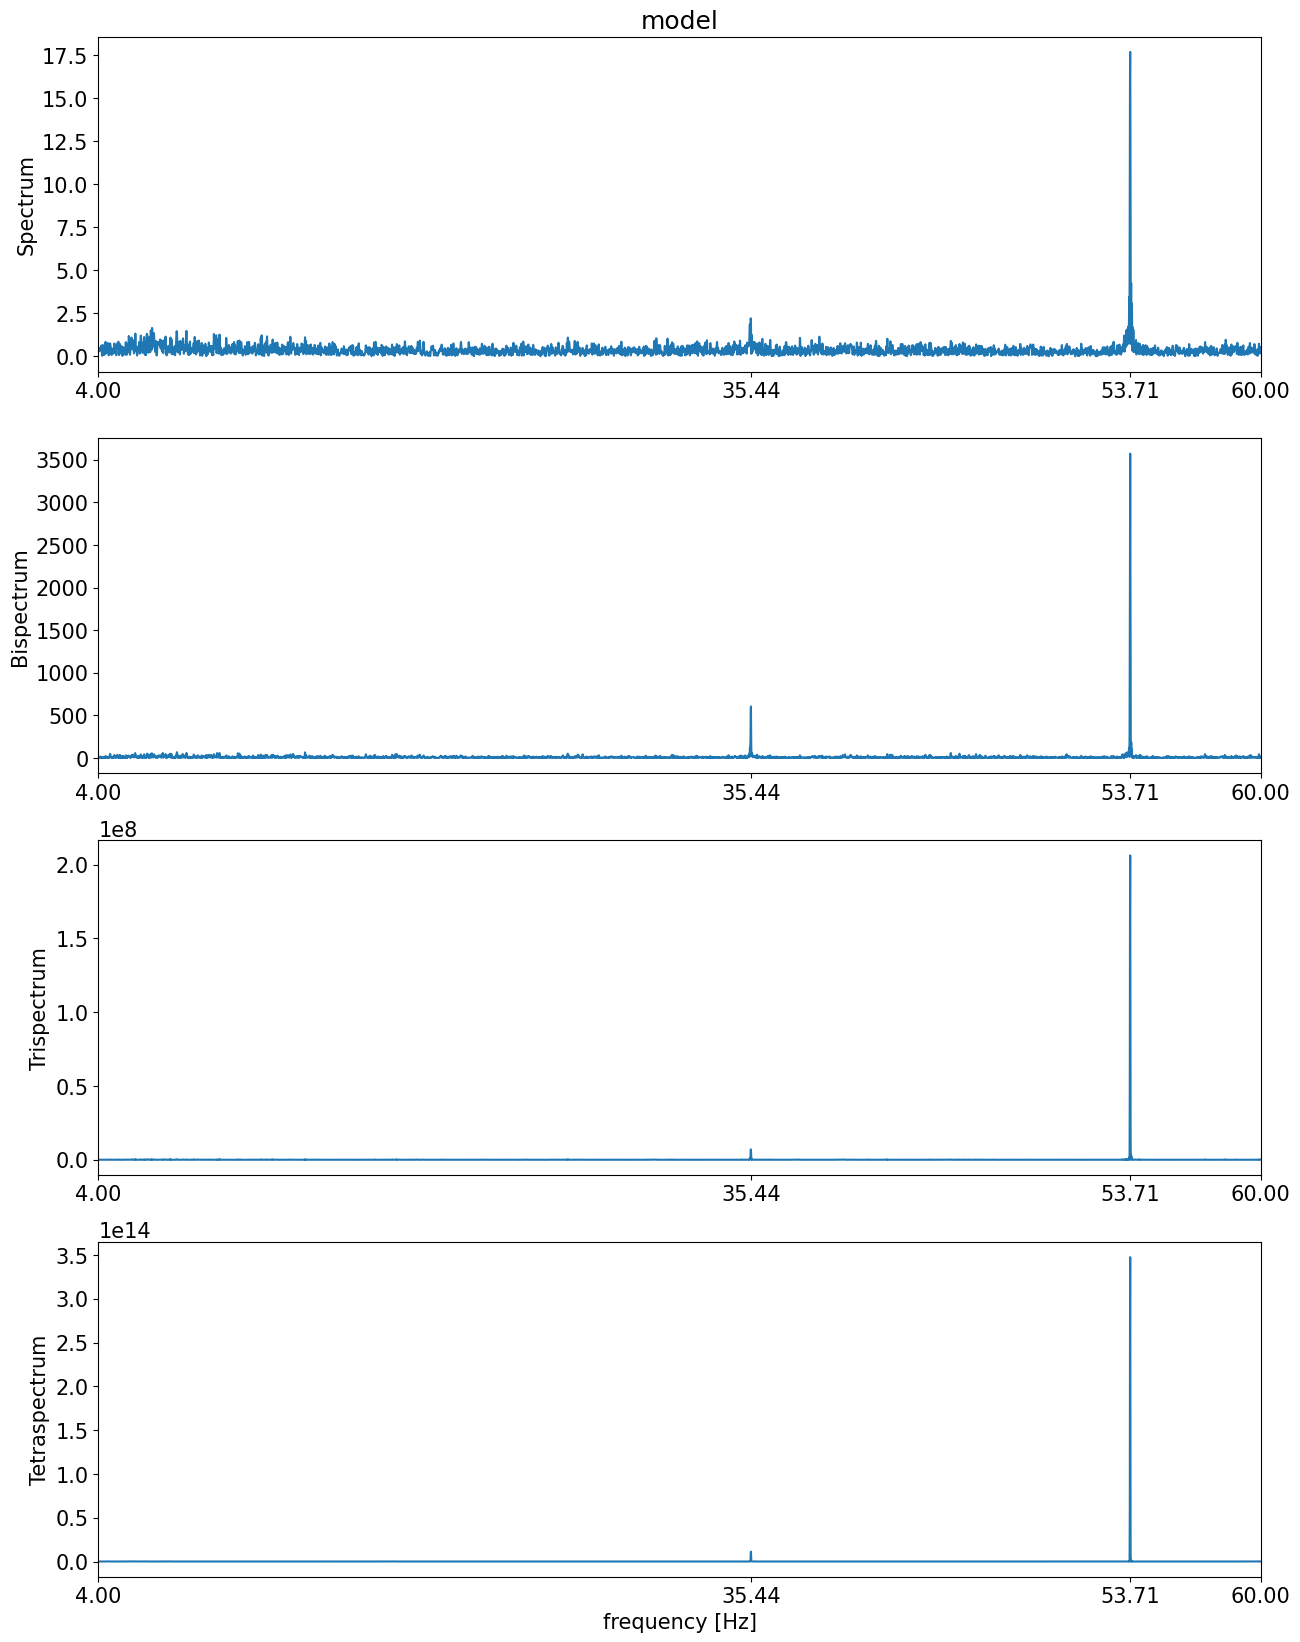

In [68]:
if hosa_df is not None:
    lim = (4, 60)
    ymin = float("Inf")
    ymax = float("-Inf")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    tdqs_data = {
        "signal": df_amps_signal,
        "model": df_amps_model
    }

    for name_data, data in tdqs_data.items():
        fig = plt.figure(figsize=(15,20))

        plt.subplot(411)
        plt.title(name_data)
        plt.plot(data.frequency, data.tds_amp)
        plt.ylabel("Spectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(412)
        plt.plot(data.frequency, data.tdbs_amp)
        plt.ylabel("Bispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(413)
        plt.plot(data.frequency, data.tdts_amp)
        plt.ylabel("Trispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(414)
        plt.plot(data.frequency, data.tdqs_amp)
        plt.ylabel("Tetraspectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)

        plt.xlabel("frequency [Hz]", fontsize=15)

        plt.xlim([lim[0], lim[1]])

        plt.savefig(
            f"hosa_{id_file}_{id_results}.jpg",
            format="jpg",
            bbox_inches='tight', 
            dpi=150
        )

        plt.show()


# Selecting Data to model - EVENT 2

In [69]:
event_number = 2
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0
)

In [70]:
event_data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event',
       'filtered_Inferior_colliculus_1', 'filtered_Inferior_colliculus_2',
       'filtered_Inferior_colliculus_3', 'filtered_Inferior_colliculus_4',
       'filtered_Amygdala_lateral_1', 'filtered_Amygdala_basolateral_1',
       'filtered_Amygdala_lateral_2', 'filtered_Amygdala_basolateral_2'],
      dtype='object')

In [71]:
y = event_data.Inferior_colliculus_2.to_numpy()

In [72]:
u = np.vstack([event_data.loc[:, dict_inputs[input_model]] for input_model in inputs])

In [73]:
u.shape

(4, 4297)

In [74]:
path_files = f"err_model_{id_file}_{id_results}_err.pkl"
err_already_calculated: bool = os.path.isfile(path_files)

if err_already_calculated and not replace_err:
    logger.info("ERR already calculated. Loading...")
    err_out, termos, psi = load_err()
    logger.success("ERR loaded!")
else:
    logger.info("ERR not calculated yet. Generating ERR...")

2023-07-02 18:46:34.575 | INFO     | __main__:<module>:5 - ERR already calculated. Loading...
2023-07-02 18:46:34.576 | INFO     | __main__:load_err:5 - loading err...
2023-07-02 18:46:34.577 | INFO     | __main__:load_err:9 - loading termos...
2023-07-02 18:46:34.578 | INFO     | __main__:load_err:13 - loading psi...
2023-07-02 18:46:34.584 | SUCCESS  | __main__:load_err:17 - Done loading err data!
2023-07-02 18:46:34.585 | SUCCESS  | __main__:<module>:7 - ERR loaded!


### Obtendo o resultado do Critério de Redução de Erro 

In [75]:
if not err_already_calculated or replace_err:

    err_obj = err(
        ny=max_y_delays,
        nu=max_u_delays,
        n_lin=degree_of_non_linearity,
        yid=y,
        uid=u,
        cte=True,
    )

    start_time = perf_counter()

    err_out, termos, psi = err_obj.run(print_result=True)

    end_time = perf_counter()

    save_err(err_out, termos, psi)

### Obtendo o Critério de Informação de Akaike para a matriz $\Psi$ gerada pelo ERR

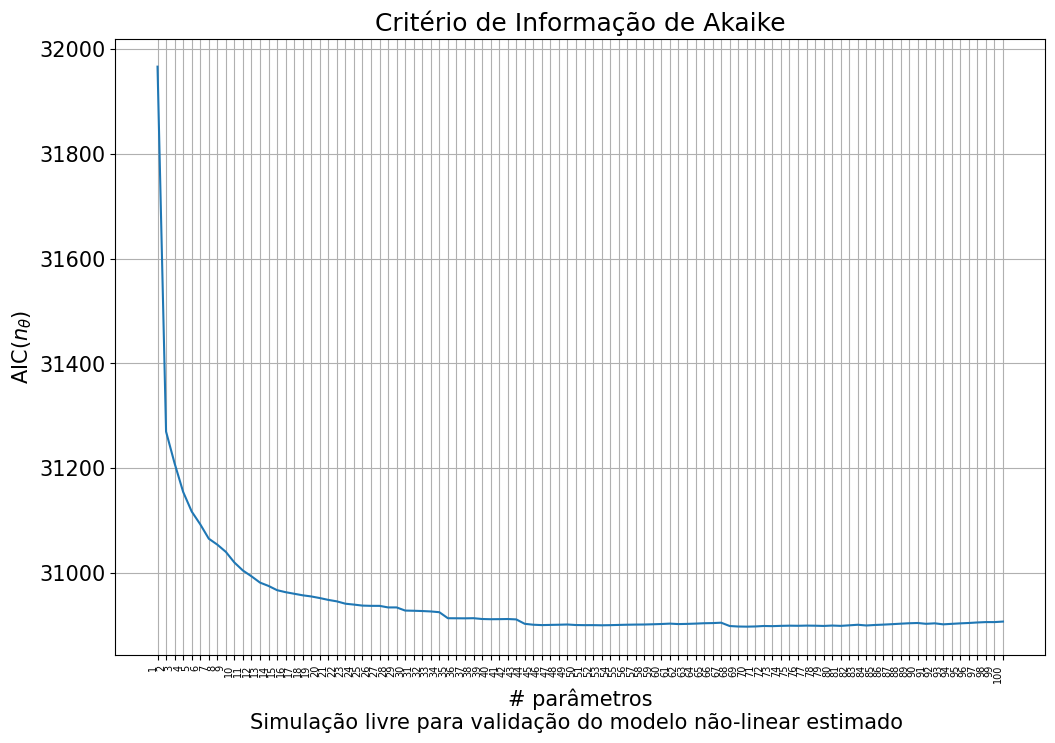

In [76]:
Phi = np.array([])

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, residuos = MQ(Phi.T, y[max_delays:])
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y), var_xi))
    
    parameters = np.append(parameters, i+1)
    
max_number_of_parameters = 100  # float("Inf")
plt.plot(parameters[parameters<=max_number_of_parameters], aic[parameters<=max_number_of_parameters])
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Simulação livre para validação do modelo não-linear estimado "
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.xticks(parameters[parameters<=max_number_of_parameters], rotation=90, ha='right', fontsize=7)
plt.grid()
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 5 primeiros regressores listados, que consistem das combinações de número 1, 14, 7, 2 e 5, da tabela de termos mostrada abaixo:

In [77]:
number_of_selected_terms = 45

In [78]:
psi_mq = np.vstack([psi[:,i] for i in err_out["ordem"][:number_of_selected_terms]]).T

theta, xi = MQ(psi_mq, y[max_delays:])

print(f"Theta ordenado: {theta}")

Theta ordenado: [-2.78849437e+01  4.66603981e-01  2.56437188e+02  9.85042787e+00
 -1.82674294e-03  2.47212249e-03 -3.11431892e-03 -4.63633277e-03
 -1.98692919e-01  1.30358206e-01  3.65232292e+02 -4.97608498e-02
  3.13179510e-02 -1.57675955e-03  1.74046480e-03  4.45781896e-03
  6.21546402e-04  3.56069676e-02  2.55011353e-03  5.97101214e-05
 -1.93575001e-03  1.36524187e-03 -2.99355606e-03  1.45788462e-03
  4.10535366e-02 -3.31759434e-02 -1.68914402e-01  6.64712128e-02
  1.57672055e+02  5.70157653e+02 -5.85789134e+01  3.26444565e+02
 -1.10212466e+02  1.92347122e+02  2.62404597e+02 -4.25689553e-02
  3.41431515e-02  2.16217500e-03  1.56398749e-04  8.94367198e-02
 -7.63815957e-02 -1.84993416e-03 -3.62956803e-03  3.60812777e-03
  6.75770052e-02]


Assim, o modelo NARX escolhido é:

In [79]:
terms_dict = termos.iloc[err_out["ordem"][:number_of_selected_terms]].T.to_dict()

model = []
model_dict = {}
model_str = []

for reg_number, line in terms_dict.items():
    term = ""
    for reg, power in line.items():
        term += " * " if term and power else ""
        term += reg if power > 0 else ""
        term += f"**{int(power)}" if power > 1 else ""
    term += "1"*(not bool(term))
    term = term.replace("(", "[").replace(")", "]")
    model.append(term)
    model_dict[reg_number] = term
    
print("\n\nOrderedTermos:\n")

for i, term in enumerate(model_dict.values()):
    print(f"{str(i).zfill(2)}: err: {'{:e}'.format((err_out['valor'][:number_of_selected_terms])[i])} - {term}")
    

print("\n\nTermos:\n")

for line, term in model_dict.items():
    print(f"{line}: {term}")
    
terms_per_line = 4
print("\ny(k) = ", end="")
for i, term in enumerate(model, start=1):
    print(f"{term}{' + '*(i not in (len(model),))}", end="\n" if not i % terms_per_line else "")
    
print("\n\n\n")



OrderedTermos:

00: err: 2.879392e-01 - u[0, k-2]
01: err: 1.069012e-01 - u[1, k-1]
02: err: 8.745261e-03 - u[0, k-1] * u[0, k-3]
03: err: 7.786055e-03 - u[0, k-1]
04: err: 5.329954e-03 - u[3, k-1] * u[3, k-2]
05: err: 3.209747e-03 - u[2, k-1]**2
06: err: 3.683503e-03 - u[1, k-1] * u[2, k-1]
07: err: 2.078856e-03 - u[2, k-1] * u[3, k-4]
08: err: 2.115873e-03 - y[k-1]
09: err: 3.088579e-03 - u[3, k-1]
10: err: 2.224031e-03 - u[0, k-2] * u[0, k-4]
11: err: 1.739698e-03 - u[1, k-4]
12: err: 1.818823e-03 - y[k-2]
13: err: 1.418434e-03 - y[k-2]**2
14: err: 1.340076e-03 - u[1, k-2] * u[2, k-2]
15: err: 7.597402e-04 - u[1, k-4] * u[2, k-1]
16: err: 6.461822e-04 - u[1, k-2] * u[3, k-1]
17: err: 6.484838e-04 - u[2, k-3]
18: err: 5.453366e-04 - y[k-1] * u[3, k-4]
19: err: 6.568443e-04 - u[2, k-3] * u[2, k-4]
20: err: 7.145799e-04 - u[2, k-1] * u[2, k-2]
21: err: 6.135960e-04 - u[1, k-1] * u[3, k-2]
22: err: 8.395612e-04 - y[k-1] * u[1, k-4]
23: err: 4.763800e-04 - u[2, k-2] * u[3, k-1]
24: err

Validação utilizando a segunda metade da massa de dados:

In [80]:
y_free = eval_model_SISO_NARX(
    model=model, 
    theta=theta, 
    u=u, 
    y=y,
    y0=np.zeros(3)
)

Carregando a saída da validação e os resíduos de estimação do modelo cuja estrutura foi obtida no Livro-texto, na Lista de Exercícios 9 

#### Plotando as curvas de validação

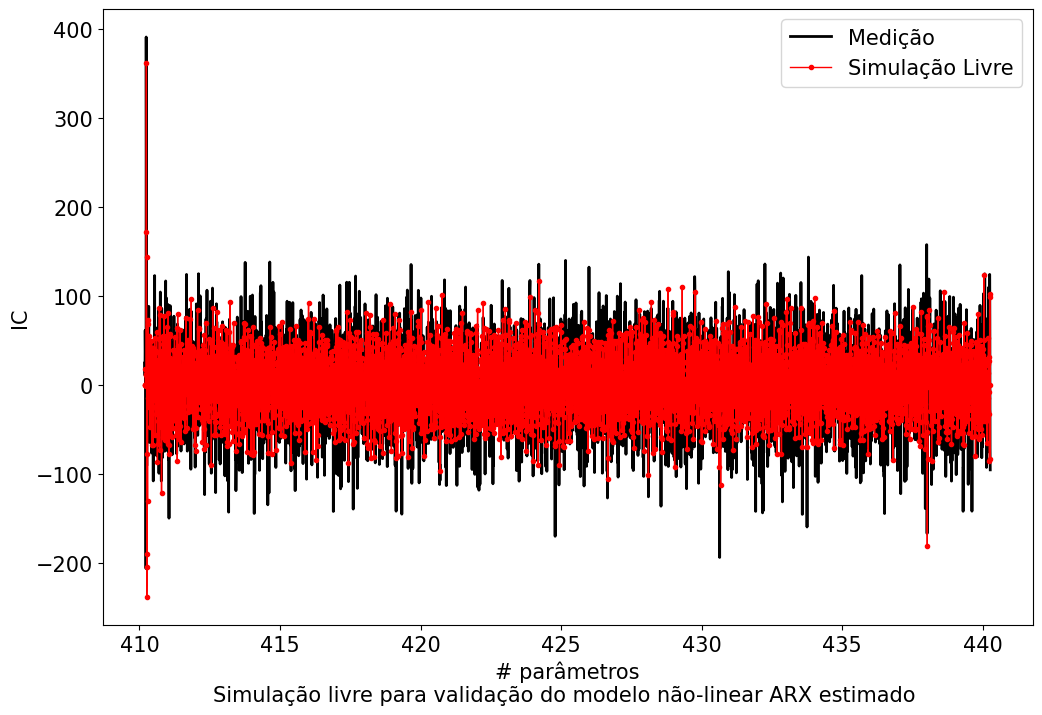

In [81]:
y_validacao = y_free
time_to_plot = event_data.Time.to_numpy()

plt.figure()
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

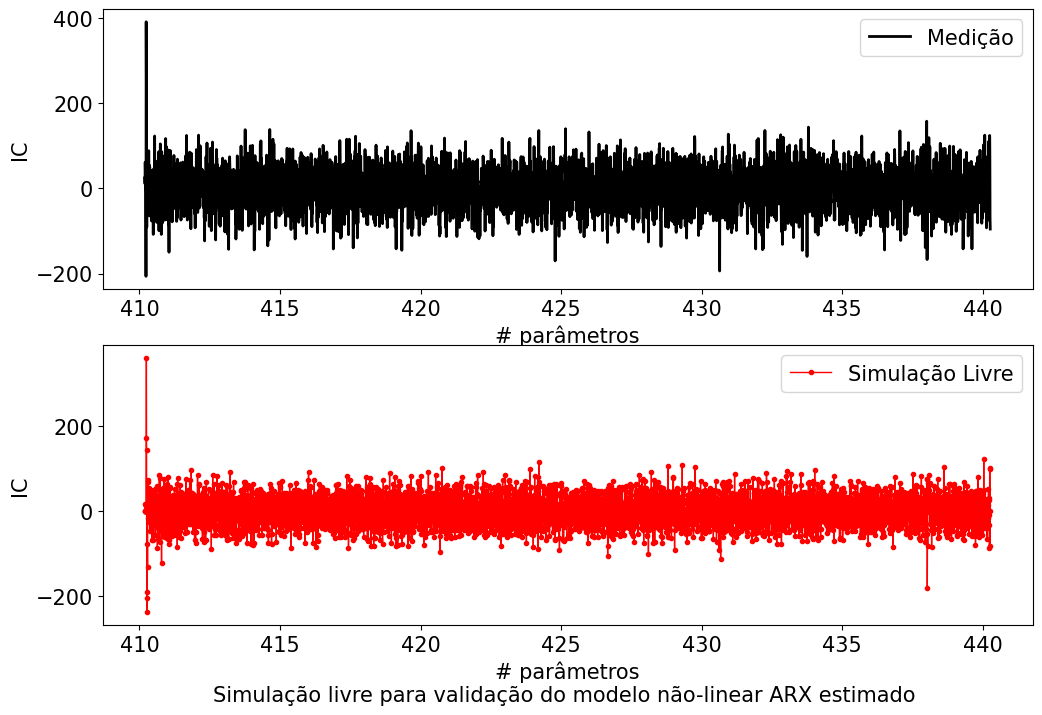

In [82]:
y_validacao = y_free
time = event_data.Time.to_numpy()

plt.figure()
plt.subplot(211)
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.subplot(212)
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Ambos os modelos apresentaram curvas estáticas similares e não serão apresentadas neste trabalho por já constarem nas listas de Exercícios anteriores.

#### Cálculo do RMSD

In [83]:
rmsd = RMSD(y, y_validacao)

print(f"RMSD Modelo Estimado ({len(theta)} parâmetros): {np.round(rmsd, 5)}")

RMSD Modelo Estimado (45 parâmetros): 38.12849


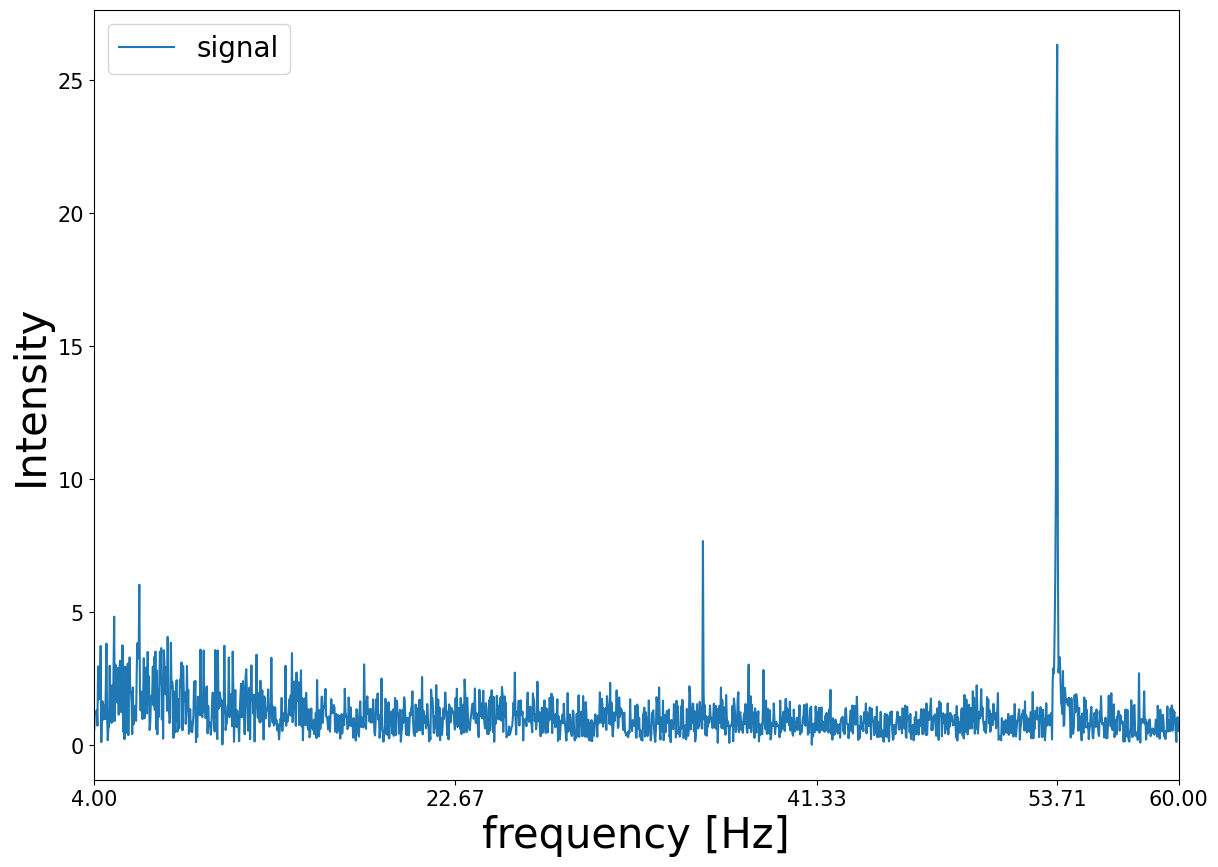

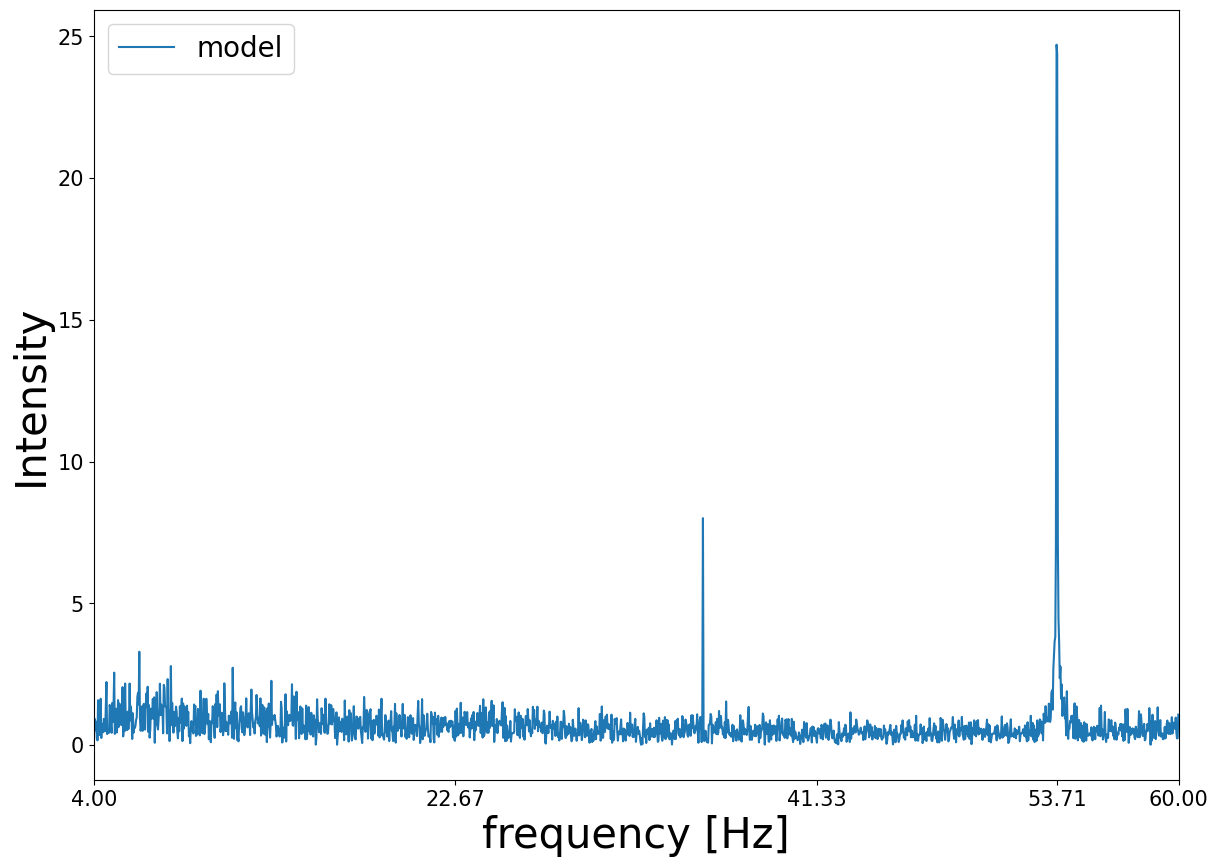

In [84]:
y = y_signal = event_data.Inferior_colliculus_2.to_numpy()

lim = (4, 60)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

fft_data = {
    "signal": y,
    "model": y_validacao
}

for name_data, data in fft_data.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    frequency, intensity, angle = fft(x=data, fs=FrequencySampling)
    y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
    x = (frequency)[(frequency>=lim[0])&(frequency<=lim[1])]
    
    ax.plot(x, y, label=f"{name_data}")
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend(prop={'size': 20})
    plt.savefig(
        f"FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()


In [85]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)

hosa_df = None

if load_already_calculated and not replace_hosa:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")

2023-07-02 18:46:38.913 | INFO     | __main__:<module>:12 - HOSA not calculated yet. Generating hosa...


In [86]:
if (not load_already_calculated or replace_hosa) and generate_hosa:

    frequency_array = np.arange(start=4, stop=60, step=0.01)

    TDQS_PARAMETERS = {
        "frequency_array": frequency_array,
        "phase_step": 0.01
    }

    df_amps = pd.DataFrame()
    df_phases = pd.DataFrame()
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdts for each channel, in parallel

    tdqs_object = TDQS(
        frequency_sampling=FrequencySampling,
        frequency_array=TDQS_PARAMETERS.get("frequency_array"),
        fmin=None,
        fmax=None,
        freq_step=None,
        phase_step=TDQS_PARAMETERS["phase_step"]
    )

    f = lambda x: tdqs_object.run_td4spectrum(x)

    with Pool() as pool:

        for result in pool.map(
            f, 
            [
                {
                    signal_name: signal_array
                } for signal_name, signal_array in {"signal": y_signal, "model": y_validacao}.items()
            ]
        ):

            signal_name, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum,
                tetraspectrum,
                phase_tetraspectrum         
            ) = result_data

            if "frequency" not in df_amps.columns:
                df_amps = df_amps.assign(frequency=frequency_array)
            if "frequency" not in df_amps_signal.columns:
                df_amps_signal = df_amps_signal.assign(frequency=frequency_array)
            if "frequency" not in df_amps_model.columns:
                df_amps_model = df_amps_model.assign(frequency=frequency_array)

            df_amps = df_amps.assign(**{f"tds_amp_{signal_name}": spectrum})
            df_phases = df_phases.assign(**{f"tds_phase_{signal_name}": phase_spectrum})

            df_amps = df_amps.assign(**{f"tdbs_amp_{signal_name}": bispectrum})
            df_phases = df_phases.assign(**{f"tdbs_phase_{signal_name}": phase_bispectrum})

            df_amps = df_amps.assign(**{f"tdts_amp_{signal_name}": trispectrum})
            df_phases = df_phases.assign(**{f"tdts_phase_{signal_name}": phase_trispectrum})

            df_amps = df_amps.assign(**{f"tdqs_amp_{signal_name}": tetraspectrum})
            df_phases = df_phases.assign(**{f"tdqs_phase_{signal_name}": phase_tetraspectrum})
            
            if signal_name == "signal":
                df_amps_signal = df_amps_signal.assign(**{f"tds_amp": spectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": bispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": trispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_signal = df_phases_signal.assign(**{f"tds_phase": phase_spectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdqs_phase": phase_tetraspectrum})
                
            elif signal_name == "model":
                df_amps_model = df_amps_model.assign(**{f"tds_amp": spectrum})
                df_amps_model = df_amps_model.assign(**{f"tdbs_amp": bispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdts_amp": trispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_model = df_phases_model.assign(**{f"tds_phase": phase_spectrum})
                df_phases_model = df_phases_model.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdqs_phase": phase_tetraspectrum})



    hosa_df = pd.concat([df_amps, df_phases], axis=1)

    
    
    
    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done processing data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")
    
elif hosa_df is not None:
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()
    
    df_amps_signal = df_amps_signal.assign(frequency=hosa_df.frequency)
    df_amps_signal = df_amps_signal.assign(**{f"tds_amp": hosa_df.tds_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": hosa_df.tdts_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_signal})
    
    df_amps_model = df_amps_model.assign(frequency=hosa_df.frequency)
    df_amps_model = df_amps_model.assign(**{f"tds_amp": hosa_df.tds_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdts_amp": hosa_df.tdts_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_model})

2023-07-02 18:46:38.927 | INFO     | __main__:<module>:19 - Processing the tdqs... This may take a while...

2023-07-02 18:51:38.228 | SUCCESS  | __main__:<module>:111 - Done processing data. Elapsed time: 04m59s


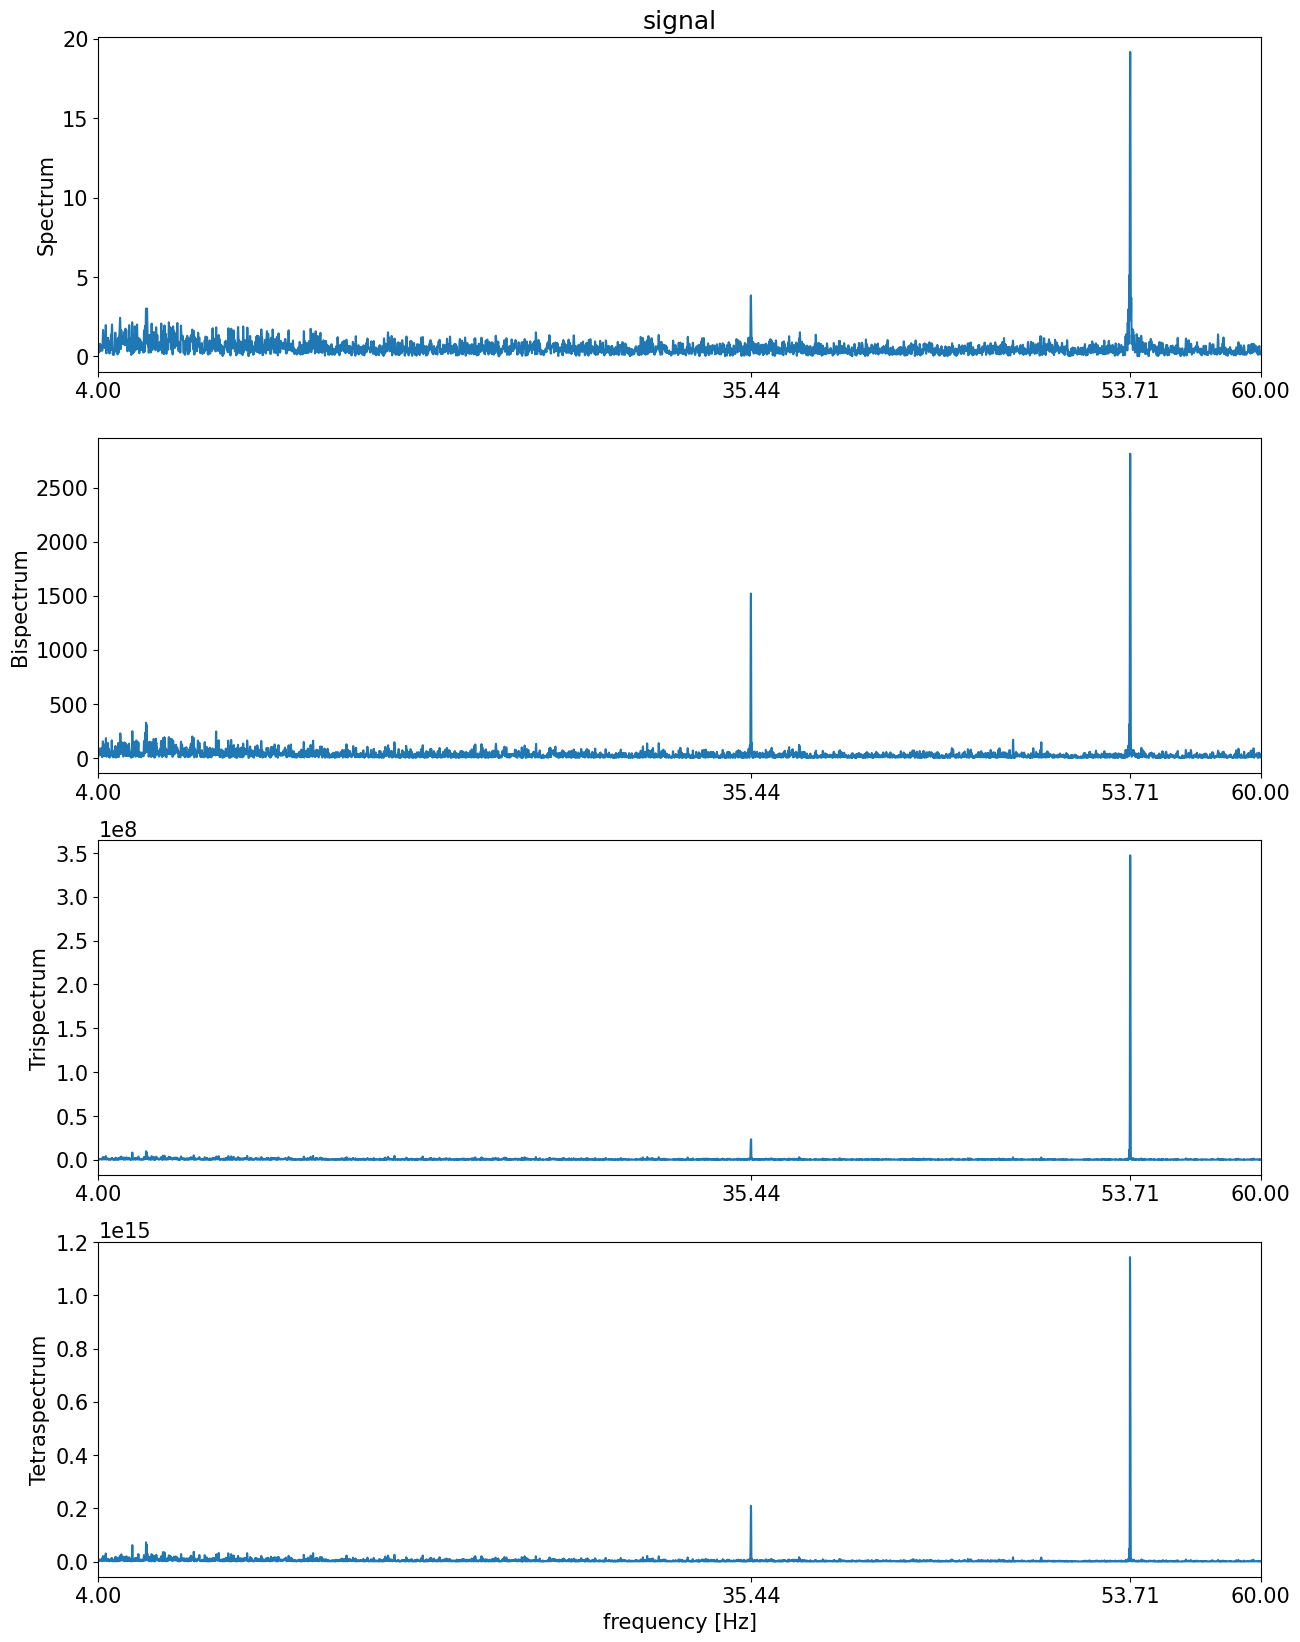

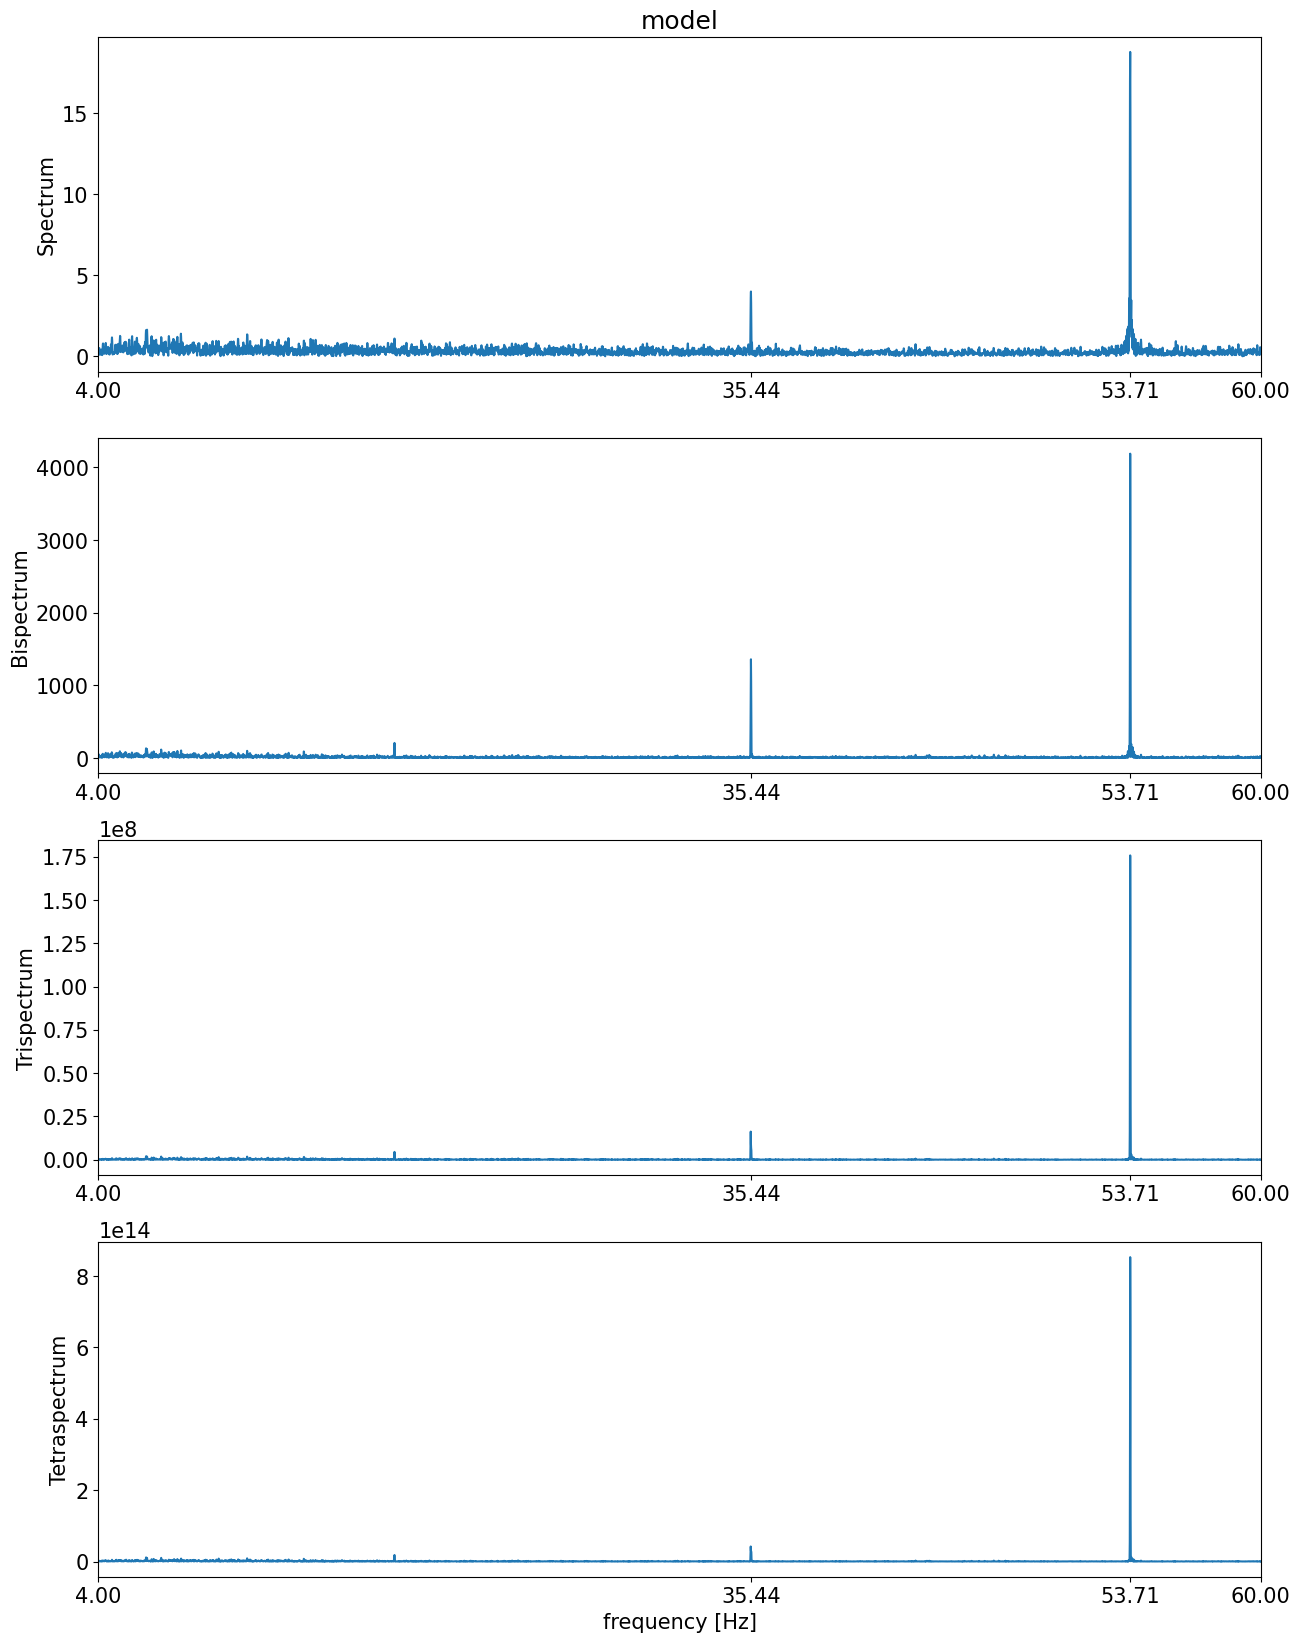

In [87]:
if hosa_df is not None:
    lim = (4, 60)
    ymin = float("Inf")
    ymax = float("-Inf")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    tdqs_data = {
        "signal": df_amps_signal,
        "model": df_amps_model
    }

    for name_data, data in tdqs_data.items():
        fig = plt.figure(figsize=(15,20))

        plt.subplot(411)
        plt.title(name_data)
        plt.plot(data.frequency, data.tds_amp)
        plt.ylabel("Spectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(412)
        plt.plot(data.frequency, data.tdbs_amp)
        plt.ylabel("Bispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(413)
        plt.plot(data.frequency, data.tdts_amp)
        plt.ylabel("Trispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(414)
        plt.plot(data.frequency, data.tdqs_amp)
        plt.ylabel("Tetraspectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)

        plt.xlabel("frequency [Hz]", fontsize=15)

        plt.xlim([lim[0], lim[1]])

        plt.savefig(
            f"hosa_{id_file}_{id_results}.jpg",
            format="jpg",
            bbox_inches='tight', 
            dpi=150
        )

        plt.show()


# Selecting Data to model - EVENT 3

In [88]:
event_number = 3
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0
)

In [89]:
event_data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event',
       'filtered_Inferior_colliculus_1', 'filtered_Inferior_colliculus_2',
       'filtered_Inferior_colliculus_3', 'filtered_Inferior_colliculus_4',
       'filtered_Amygdala_lateral_1', 'filtered_Amygdala_basolateral_1',
       'filtered_Amygdala_lateral_2', 'filtered_Amygdala_basolateral_2'],
      dtype='object')

In [90]:
y = event_data.Inferior_colliculus_2.to_numpy()

In [91]:
u = np.vstack([event_data.loc[:, dict_inputs[input_model]] for input_model in inputs])

In [92]:
u.shape

(4, 4297)

In [93]:
path_files = f"err_model_{id_file}_{id_results}_err.pkl"
err_already_calculated: bool = os.path.isfile(path_files)

if err_already_calculated and not replace_err:
    logger.info("ERR already calculated. Loading...")
    err_out, termos, psi = load_err()
    logger.success("ERR loaded!")
else:
    logger.info("ERR not calculated yet. Generating ERR...")

2023-07-02 18:51:39.676 | INFO     | __main__:<module>:5 - ERR already calculated. Loading...
2023-07-02 18:51:39.678 | INFO     | __main__:load_err:5 - loading err...
2023-07-02 18:51:39.678 | INFO     | __main__:load_err:9 - loading termos...
2023-07-02 18:51:39.679 | INFO     | __main__:load_err:13 - loading psi...
2023-07-02 18:51:39.681 | SUCCESS  | __main__:load_err:17 - Done loading err data!
2023-07-02 18:51:39.681 | SUCCESS  | __main__:<module>:7 - ERR loaded!


### Obtendo o resultado do Critério de Redução de Erro 

In [94]:
if not err_already_calculated or replace_err:

    err_obj = err(
        ny=max_y_delays,
        nu=max_u_delays,
        n_lin=degree_of_non_linearity,
        yid=y,
        uid=u,
        cte=True,
    )

    start_time = perf_counter()

    err_out, termos, psi = err_obj.run(print_result=True)

    end_time = perf_counter()

    save_err(err_out, termos, psi)

### Obtendo o Critério de Informação de Akaike para a matriz $\Psi$ gerada pelo ERR

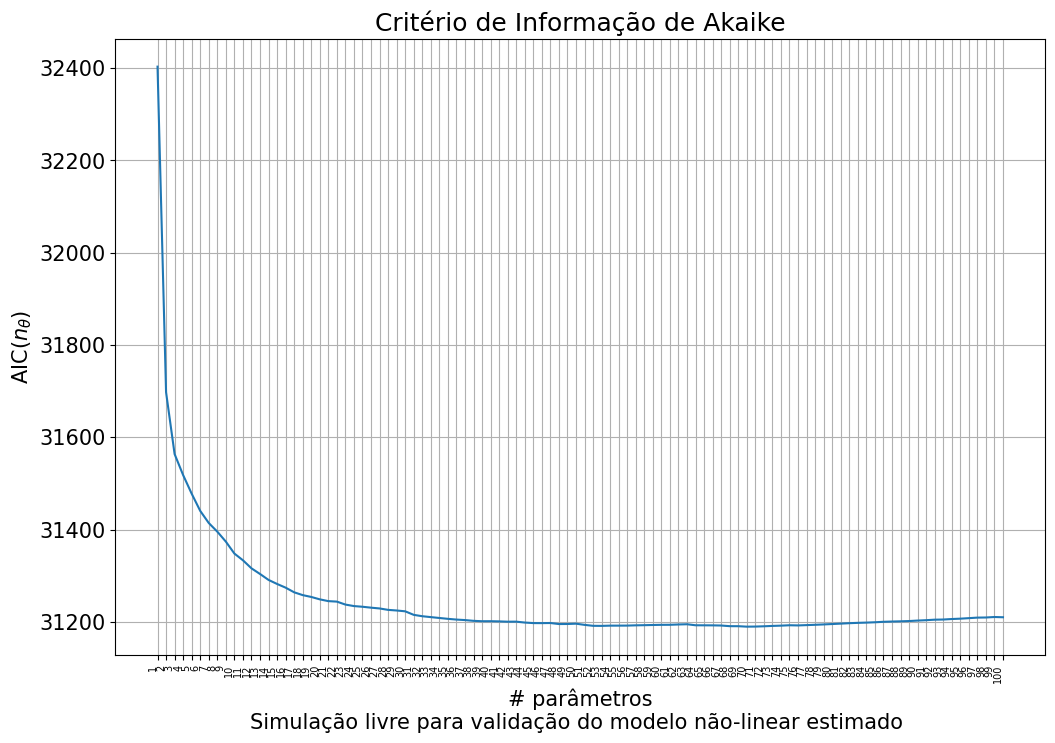

In [95]:
Phi = np.array([])

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, residuos = MQ(Phi.T, y[max_delays:])
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y), var_xi))
    
    parameters = np.append(parameters, i+1)
    
max_number_of_parameters = 100  # float("Inf")
plt.plot(parameters[parameters<=max_number_of_parameters], aic[parameters<=max_number_of_parameters])
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Simulação livre para validação do modelo não-linear estimado "
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.xticks(parameters[parameters<=max_number_of_parameters], rotation=90, ha='right', fontsize=7)
plt.grid()
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 5 primeiros regressores listados, que consistem das combinações de número 1, 14, 7, 2 e 5, da tabela de termos mostrada abaixo:

In [96]:
number_of_selected_terms = 40

In [97]:
psi_mq = np.vstack([psi[:,i] for i in err_out["ordem"][:number_of_selected_terms]]).T

theta, xi = MQ(psi_mq, y[max_delays:])

print(f"Theta ordenado: {theta}")

Theta ordenado: [-8.86352635e+00  3.83708976e-01  3.01917027e+01  4.17337230e+00
 -3.11277104e-03  4.68776033e-02  5.70626603e-04  3.13664708e+00
 -3.03856363e-05 -2.64334787e-04 -2.18148026e-01 -1.00902129e-03
  7.62437842e-02 -7.53428731e-02  5.87142046e-02  1.42293854e-01
 -1.53324168e-01 -2.45647854e-03  8.47948033e-04 -3.47703523e-04
  5.39250222e-02  1.20427614e+01 -2.85203822e+01  1.25542378e-03
 -6.52663415e-02  2.13062414e-03 -1.26197517e-01  8.46207452e-02
  3.17183163e-03 -1.21233941e-01  1.62446095e-01 -2.61785834e-03
  1.45208516e-03 -7.99175543e-04  1.49218147e+01 -3.06220203e+01
 -1.50161601e-03  1.72897732e-03 -1.17268402e-01  3.69231450e-04]


Assim, o modelo NARX escolhido é:

In [98]:
terms_dict = termos.iloc[err_out["ordem"][:number_of_selected_terms]].T.to_dict()

model = []
model_dict = {}
model_str = []

for reg_number, line in terms_dict.items():
    term = ""
    for reg, power in line.items():
        term += " * " if term and power else ""
        term += reg if power > 0 else ""
        term += f"**{int(power)}" if power > 1 else ""
    term += "1"*(not bool(term))
    term = term.replace("(", "[").replace(")", "]")
    model.append(term)
    model_dict[reg_number] = term
    
print("\n\nOrderedTermos:\n")

for i, term in enumerate(model_dict.values()):
    print(f"{str(i).zfill(2)}: err: {'{:e}'.format((err_out['valor'][:number_of_selected_terms])[i])} - {term}")
    

print("\n\nTermos:\n")

for line, term in model_dict.items():
    print(f"{line}: {term}")
    
terms_per_line = 4
print("\ny(k) = ", end="")
for i, term in enumerate(model, start=1):
    print(f"{term}{' + '*(i not in (len(model),))}", end="\n" if not i % terms_per_line else "")
    
print("\n\n\n")



OrderedTermos:

00: err: 3.216432e-01 - u[0, k-2]
01: err: 1.029894e-01 - u[1, k-1]
02: err: 1.792290e-02 - u[0, k-1]
03: err: 6.131451e-03 - u[0, k-2] * u[0, k-4]
04: err: 5.326882e-03 - u[1, k-2] * u[2, k-1]
05: err: 4.955212e-03 - u[3, k-2]
06: err: 3.626413e-03 - u[1, k-3] * u[2, k-4]
07: err: 2.582989e-03 - u[0, k-1] * u[0, k-3]
08: err: 2.527385e-03 - u[2, k-1]**2
09: err: 3.850832e-03 - u[3, k-3]**2
10: err: 1.945730e-03 - u[0, k-4] * u[2, k-1]
11: err: 2.320484e-03 - y[k-1] * u[1, k-1]
12: err: 1.760821e-03 - y[k-2]
13: err: 1.805084e-03 - u[1, k-4]
14: err: 1.318255e-03 - u[3, k-3]
15: err: 1.169260e-03 - u[3, k-1]
16: err: 1.433747e-03 - y[k-1]
17: err: 8.362560e-04 - u[1, k-4] * u[2, k-4]
18: err: 9.415048e-04 - y[k-4]**2
19: err: 7.750551e-04 - u[3, k-2]**2
20: err: 7.008834e-04 - u[0, k-1] * u[3, k-1]
21: err: 5.147127e-04 - u[0, k-1]**2
22: err: 1.007424e-03 - u[0, k-3]**2
23: err: 6.260740e-04 - u[1, k-4] * u[3, k-4]
24: err: 4.119940e-04 - u[0, k-3] * u[3, k-2]
25: er

Validação utilizando a segunda metade da massa de dados:

In [99]:
y_free = eval_model_SISO_NARX(
    model=model, 
    theta=theta, 
    u=u, 
    y=y,
    y0=np.zeros(3)
)

Carregando a saída da validação e os resíduos de estimação do modelo cuja estrutura foi obtida no Livro-texto, na Lista de Exercícios 9 

#### Plotando as curvas de validação

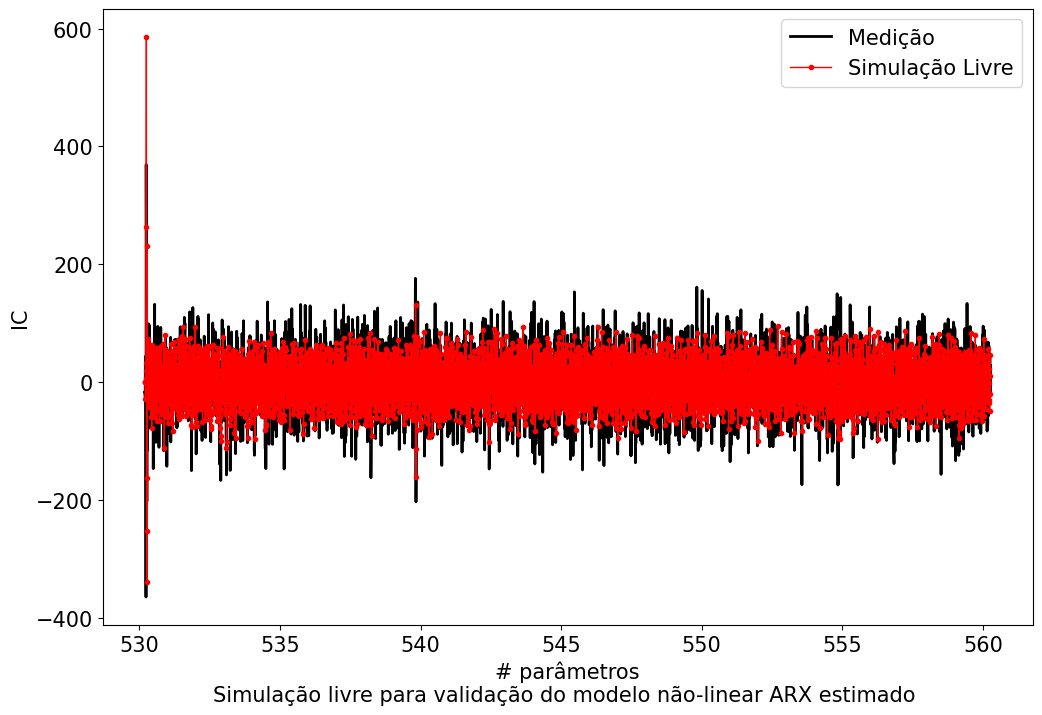

In [100]:
y_validacao = y_free
time_to_plot = event_data.Time.to_numpy()

plt.figure()
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

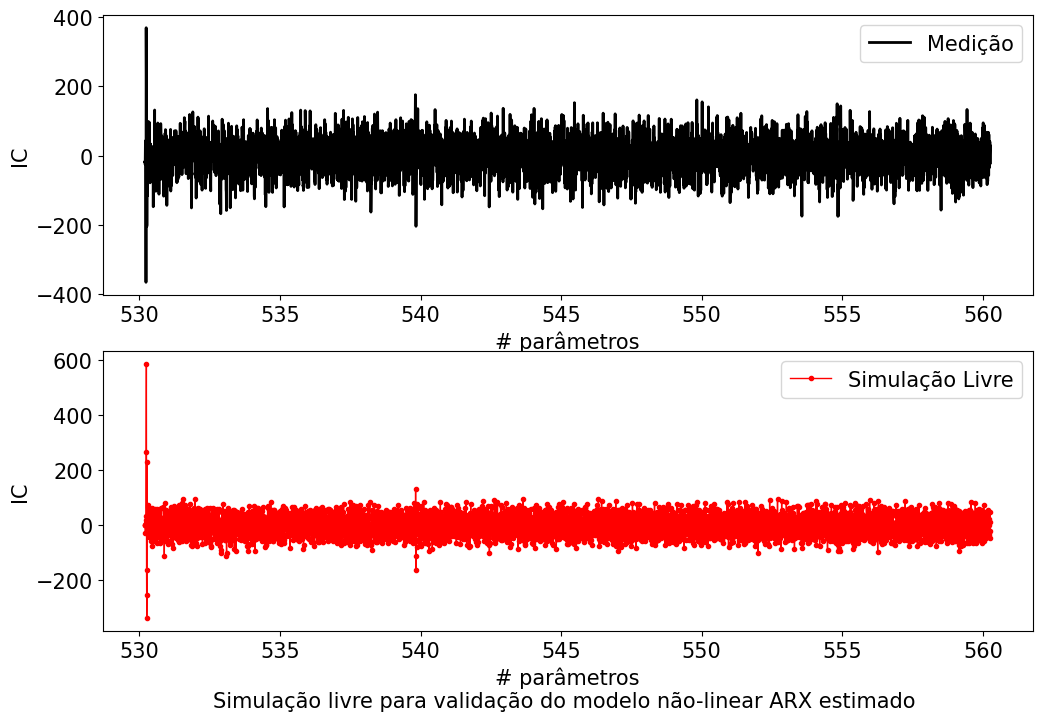

In [101]:
y_validacao = y_free
time = event_data.Time.to_numpy()

plt.figure()
plt.subplot(211)
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.subplot(212)
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Ambos os modelos apresentaram curvas estáticas similares e não serão apresentadas neste trabalho por já constarem nas listas de Exercícios anteriores.

#### Cálculo do RMSD

In [102]:
rmsd = RMSD(y, y_validacao)

print(f"RMSD Modelo Estimado ({len(theta)} parâmetros): {np.round(rmsd, 5)}")

RMSD Modelo Estimado (40 parâmetros): 39.29705


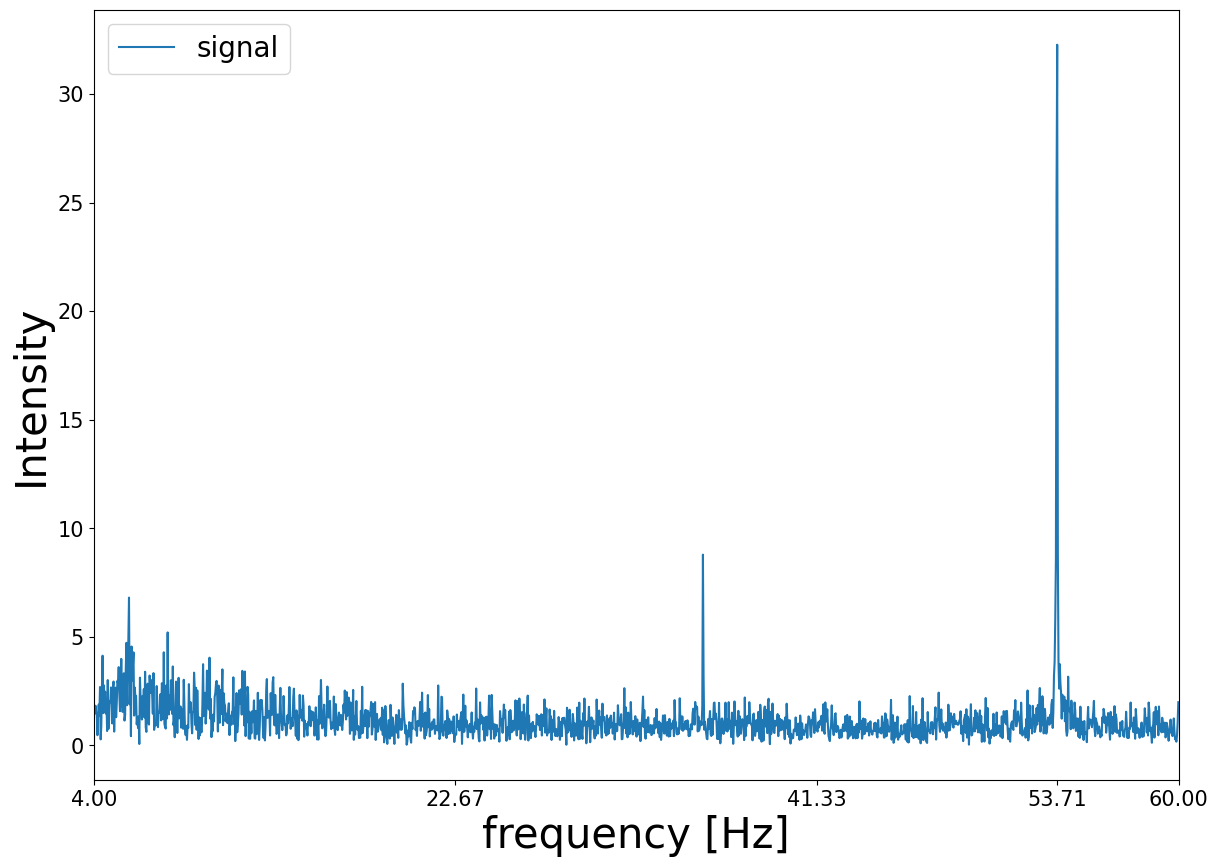

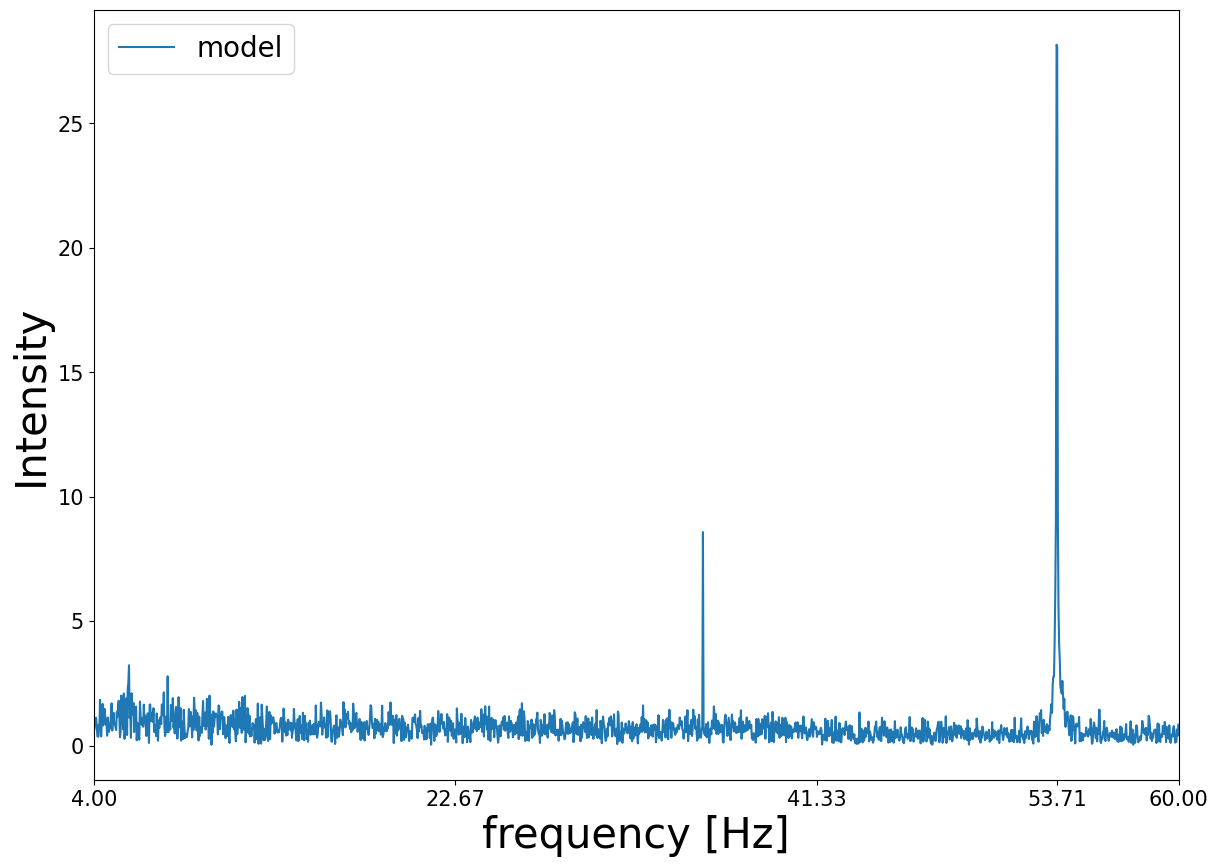

In [103]:
y = y_signal = event_data.Inferior_colliculus_2.to_numpy()

lim = (4, 60)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

fft_data = {
    "signal": y,
    "model": y_validacao
}

for name_data, data in fft_data.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    frequency, intensity, angle = fft(x=data, fs=FrequencySampling)
    y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
    x = (frequency)[(frequency>=lim[0])&(frequency<=lim[1])]
    
    ax.plot(x, y, label=f"{name_data}")
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend(prop={'size': 20})
    plt.savefig(
        f"FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()


In [104]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)

hosa_df = None

if load_already_calculated and not replace_hosa:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")

2023-07-02 18:51:43.680 | INFO     | __main__:<module>:12 - HOSA not calculated yet. Generating hosa...


In [105]:
if (not load_already_calculated or replace_hosa) and generate_hosa:

    frequency_array = np.arange(start=4, stop=60, step=0.01)

    TDQS_PARAMETERS = {
        "frequency_array": frequency_array,
        "phase_step": 0.01
    }

    df_amps = pd.DataFrame()
    df_phases = pd.DataFrame()
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdts for each channel, in parallel

    tdqs_object = TDQS(
        frequency_sampling=FrequencySampling,
        frequency_array=TDQS_PARAMETERS.get("frequency_array"),
        fmin=None,
        fmax=None,
        freq_step=None,
        phase_step=TDQS_PARAMETERS["phase_step"]
    )

    f = lambda x: tdqs_object.run_td4spectrum(x)

    with Pool() as pool:

        for result in pool.map(
            f, 
            [
                {
                    signal_name: signal_array
                } for signal_name, signal_array in {"signal": y_signal, "model": y_validacao}.items()
            ]
        ):

            signal_name, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum,
                tetraspectrum,
                phase_tetraspectrum         
            ) = result_data

            if "frequency" not in df_amps.columns:
                df_amps = df_amps.assign(frequency=frequency_array)
            if "frequency" not in df_amps_signal.columns:
                df_amps_signal = df_amps_signal.assign(frequency=frequency_array)
            if "frequency" not in df_amps_model.columns:
                df_amps_model = df_amps_model.assign(frequency=frequency_array)

            df_amps = df_amps.assign(**{f"tds_amp_{signal_name}": spectrum})
            df_phases = df_phases.assign(**{f"tds_phase_{signal_name}": phase_spectrum})

            df_amps = df_amps.assign(**{f"tdbs_amp_{signal_name}": bispectrum})
            df_phases = df_phases.assign(**{f"tdbs_phase_{signal_name}": phase_bispectrum})

            df_amps = df_amps.assign(**{f"tdts_amp_{signal_name}": trispectrum})
            df_phases = df_phases.assign(**{f"tdts_phase_{signal_name}": phase_trispectrum})

            df_amps = df_amps.assign(**{f"tdqs_amp_{signal_name}": tetraspectrum})
            df_phases = df_phases.assign(**{f"tdqs_phase_{signal_name}": phase_tetraspectrum})
            
            if signal_name == "signal":
                df_amps_signal = df_amps_signal.assign(**{f"tds_amp": spectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": bispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": trispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_signal = df_phases_signal.assign(**{f"tds_phase": phase_spectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdqs_phase": phase_tetraspectrum})
                
            elif signal_name == "model":
                df_amps_model = df_amps_model.assign(**{f"tds_amp": spectrum})
                df_amps_model = df_amps_model.assign(**{f"tdbs_amp": bispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdts_amp": trispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_model = df_phases_model.assign(**{f"tds_phase": phase_spectrum})
                df_phases_model = df_phases_model.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdqs_phase": phase_tetraspectrum})



    hosa_df = pd.concat([df_amps, df_phases], axis=1)

    
    
    
    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done processing data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")
    
elif hosa_df is not None:
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()
    
    df_amps_signal = df_amps_signal.assign(frequency=hosa_df.frequency)
    df_amps_signal = df_amps_signal.assign(**{f"tds_amp": hosa_df.tds_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": hosa_df.tdts_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_signal})
    
    df_amps_model = df_amps_model.assign(frequency=hosa_df.frequency)
    df_amps_model = df_amps_model.assign(**{f"tds_amp": hosa_df.tds_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdts_amp": hosa_df.tdts_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_model})

2023-07-02 18:51:43.697 | INFO     | __main__:<module>:19 - Processing the tdqs... This may take a while...

2023-07-02 18:56:40.603 | SUCCESS  | __main__:<module>:111 - Done processing data. Elapsed time: 04m56s


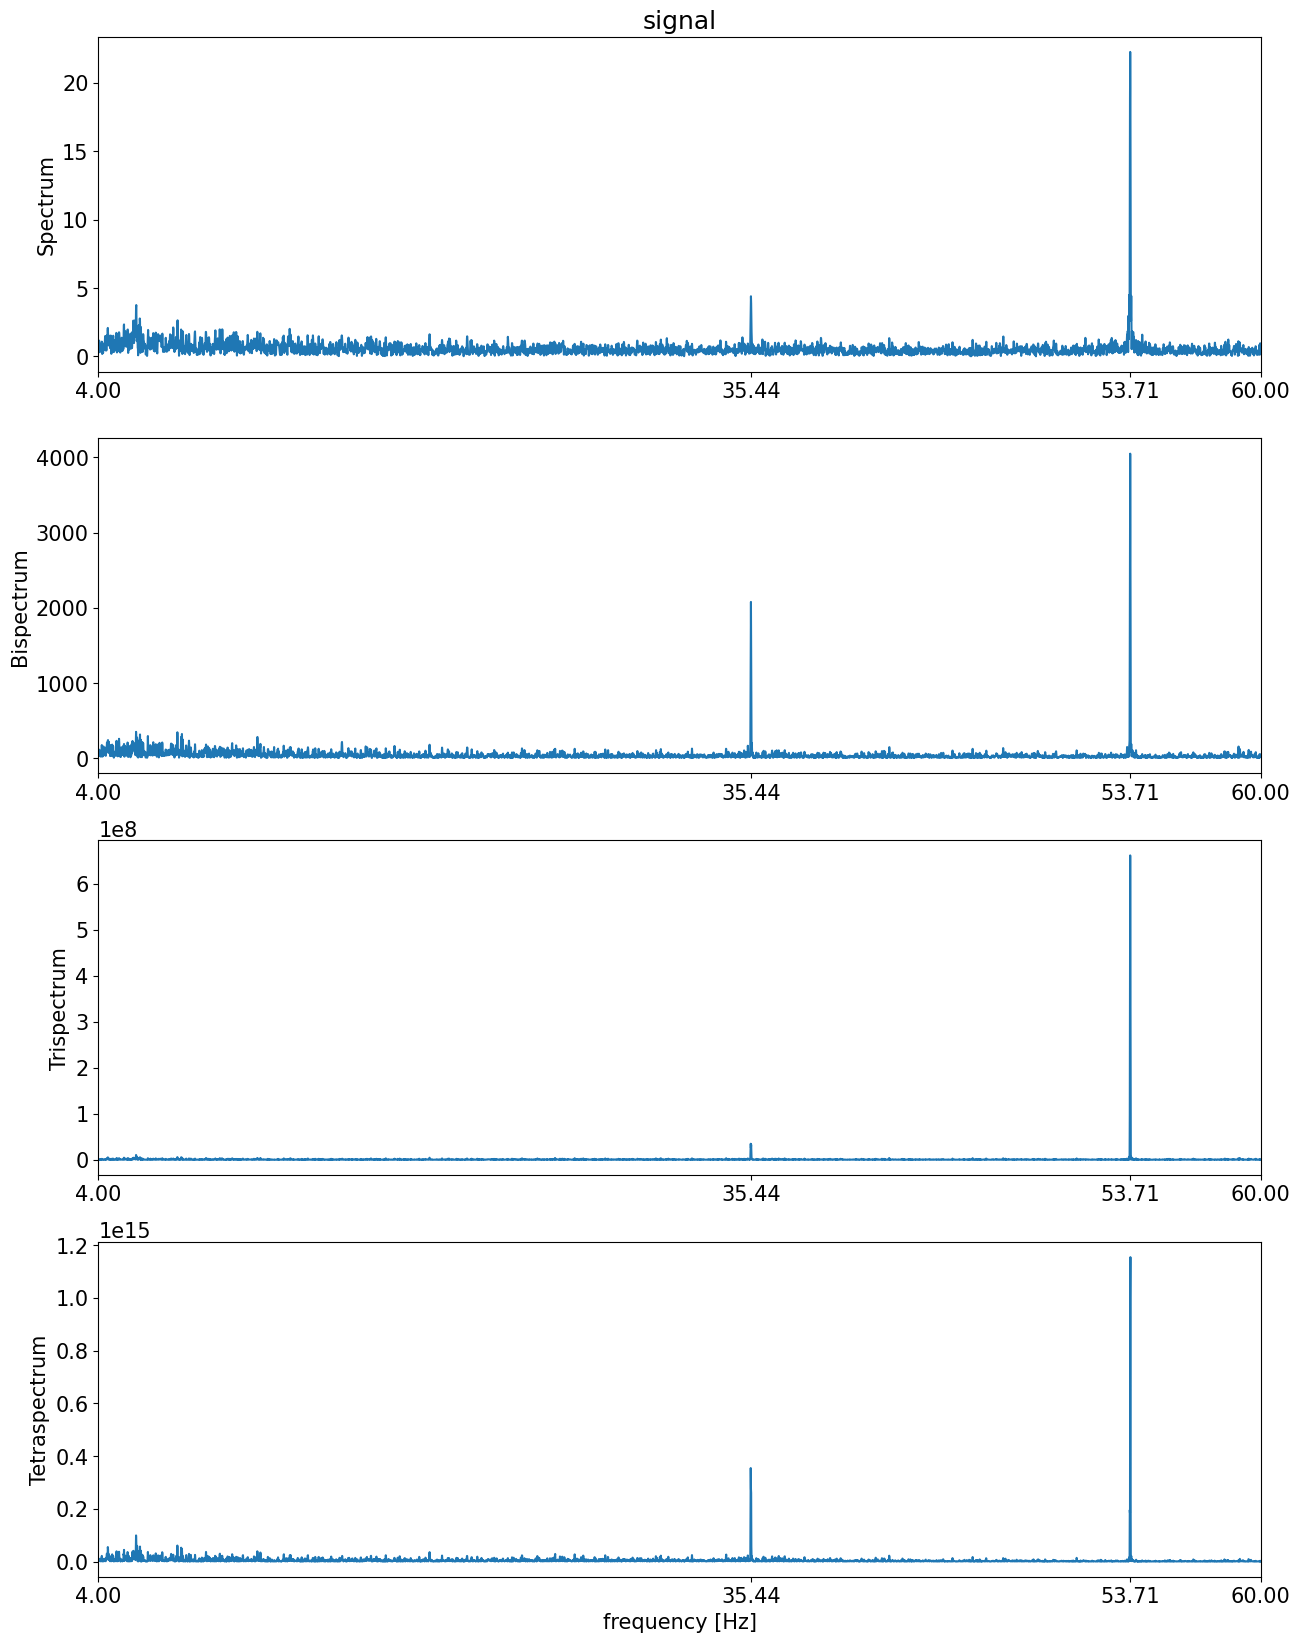

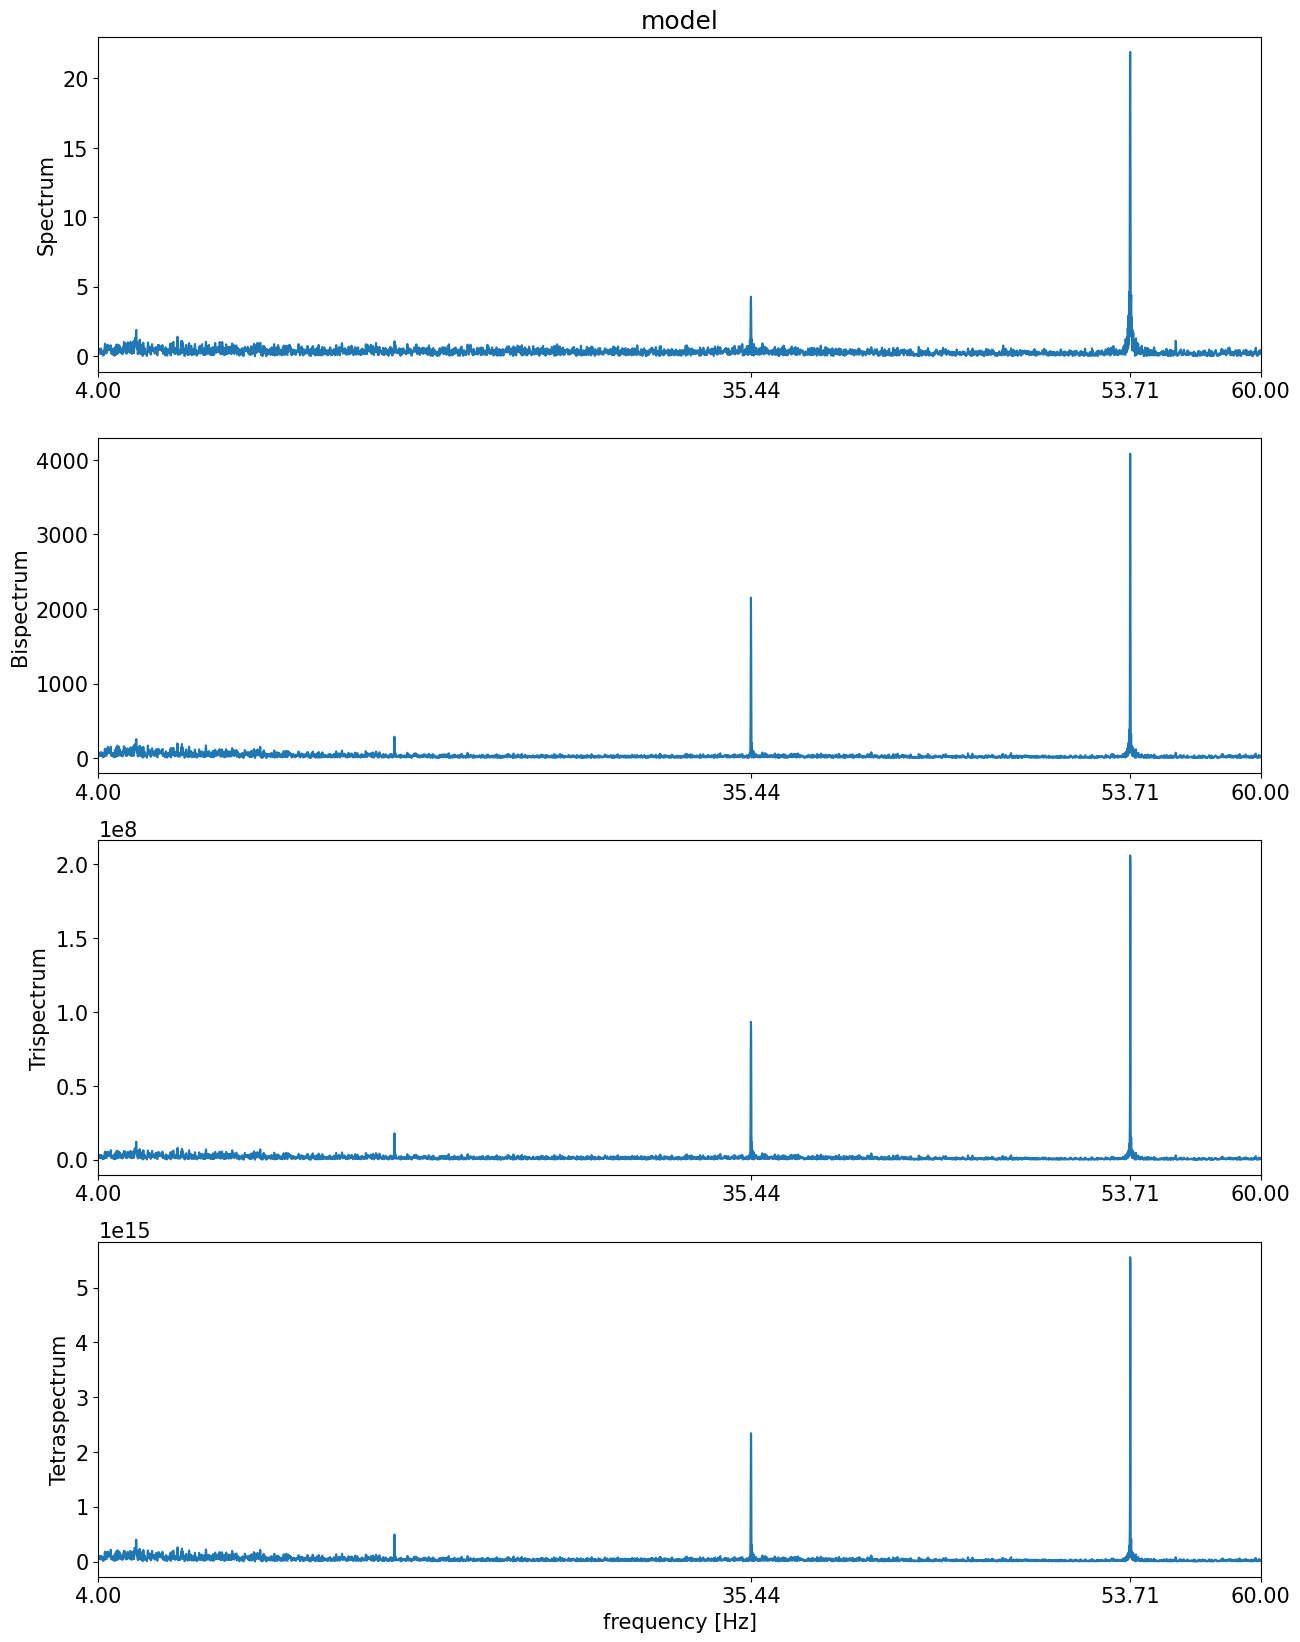

In [106]:
if hosa_df is not None:
    lim = (4, 60)
    ymin = float("Inf")
    ymax = float("-Inf")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    tdqs_data = {
        "signal": df_amps_signal,
        "model": df_amps_model
    }

    for name_data, data in tdqs_data.items():
        fig = plt.figure(figsize=(15,20))

        plt.subplot(411)
        plt.title(name_data)
        plt.plot(data.frequency, data.tds_amp)
        plt.ylabel("Spectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(412)
        plt.plot(data.frequency, data.tdbs_amp)
        plt.ylabel("Bispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(413)
        plt.plot(data.frequency, data.tdts_amp)
        plt.ylabel("Trispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(414)
        plt.plot(data.frequency, data.tdqs_amp)
        plt.ylabel("Tetraspectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)

        plt.xlabel("frequency [Hz]", fontsize=15)

        plt.xlim([lim[0], lim[1]])

        plt.savefig(
            f"hosa_{id_file}_{id_results}.jpg",
            format="jpg",
            bbox_inches='tight', 
            dpi=150
        )

        plt.show()


# Selecting Data to model - EVENT 4

In [107]:
event_number = 4
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0
)

In [108]:
event_data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event',
       'filtered_Inferior_colliculus_1', 'filtered_Inferior_colliculus_2',
       'filtered_Inferior_colliculus_3', 'filtered_Inferior_colliculus_4',
       'filtered_Amygdala_lateral_1', 'filtered_Amygdala_basolateral_1',
       'filtered_Amygdala_lateral_2', 'filtered_Amygdala_basolateral_2'],
      dtype='object')

In [109]:
y = event_data.Inferior_colliculus_2.to_numpy()

In [110]:
u = np.vstack([event_data.loc[:, dict_inputs[input_model]] for input_model in inputs])

In [111]:
u.shape

(4, 4297)

In [112]:
path_files = f"err_model_{id_file}_{id_results}_err.pkl"
err_already_calculated: bool = os.path.isfile(path_files)

if err_already_calculated and not replace_err:
    logger.info("ERR already calculated. Loading...")
    err_out, termos, psi = load_err()
    logger.success("ERR loaded!")
else:
    logger.info("ERR not calculated yet. Generating ERR...")

2023-07-02 18:56:41.950 | INFO     | __main__:<module>:5 - ERR already calculated. Loading...
2023-07-02 18:56:41.950 | INFO     | __main__:load_err:5 - loading err...
2023-07-02 18:56:41.951 | INFO     | __main__:load_err:9 - loading termos...
2023-07-02 18:56:41.952 | INFO     | __main__:load_err:13 - loading psi...
2023-07-02 18:56:41.954 | SUCCESS  | __main__:load_err:17 - Done loading err data!
2023-07-02 18:56:41.955 | SUCCESS  | __main__:<module>:7 - ERR loaded!


### Obtendo o resultado do Critério de Redução de Erro 

In [113]:
if not err_already_calculated or replace_err:

    err_obj = err(
        ny=max_y_delays,
        nu=max_u_delays,
        n_lin=degree_of_non_linearity,
        yid=y,
        uid=u,
        cte=True,
    )

    start_time = perf_counter()

    err_out, termos, psi = err_obj.run(print_result=True)

    end_time = perf_counter()

    save_err(err_out, termos, psi)

### Obtendo o Critério de Informação de Akaike para a matriz $\Psi$ gerada pelo ERR

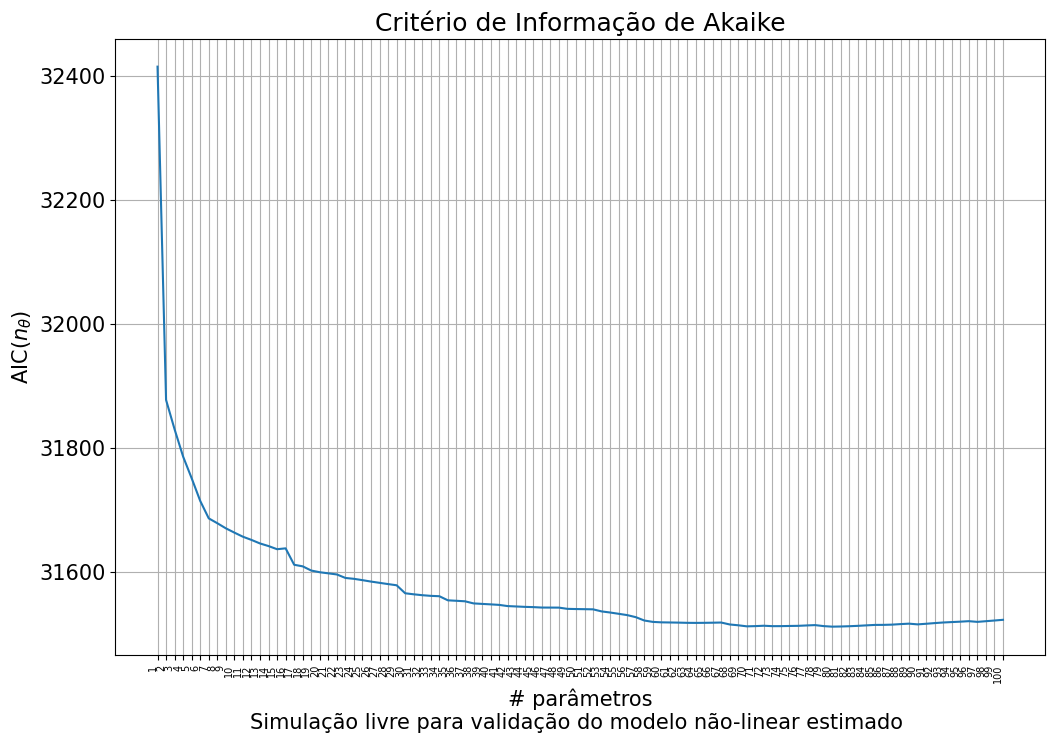

In [114]:
Phi = np.array([])

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, residuos = MQ(Phi.T, y[max_delays:])
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y), var_xi))
    
    parameters = np.append(parameters, i+1)
    
max_number_of_parameters = 100  # float("Inf")
plt.plot(parameters[parameters<=max_number_of_parameters], aic[parameters<=max_number_of_parameters])
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Simulação livre para validação do modelo não-linear estimado "
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.xticks(parameters[parameters<=max_number_of_parameters], rotation=90, ha='right', fontsize=7)
plt.grid()
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 5 primeiros regressores listados, que consistem das combinações de número 1, 14, 7, 2 e 5, da tabela de termos mostrada abaixo:

In [115]:
number_of_selected_terms = 59

In [116]:
psi_mq = np.vstack([psi[:,i] for i in err_out["ordem"][:number_of_selected_terms]]).T

theta, xi = MQ(psi_mq, y[max_delays:])

print(f"Theta ordenado: {theta}")

Theta ordenado: [-3.04344627e+01  4.14748193e-01 -1.40453192e+01  7.65831819e-02
 -1.59722177e-01  3.55118871e+01 -9.46487999e-04 -1.50710477e-01
  6.49655241e-02  9.91356552e-02  5.39886258e+00 -7.31240086e-04
 -1.22721816e-03  9.67022256e-04  4.86896667e-02  3.30252607e+01
  5.50495449e+01  1.31398466e-01 -1.86886530e-01  2.35808938e+01
 -8.91047755e+00  6.83202703e-02 -1.04840497e-01  7.22678162e-04
 -2.25180176e-03  1.16750360e-01  1.22063802e-03  1.35763832e-01
  2.03979293e-03 -1.07654069e-03  1.60646981e-03 -1.52305127e-03
 -9.54835980e-04  1.38416730e-03 -9.28099980e-04 -8.65308374e-04
  1.28659645e-03 -1.19372133e-03  1.19207178e-03 -3.80381574e-02
 -1.24188949e-01  2.04314020e-01 -1.78871286e-01  1.96819444e-03
  1.22236141e-01 -6.49105500e-02 -5.53996455e-02 -2.22489414e-03
  1.44664582e-03 -1.39845440e-01 -8.48116768e-04  1.49225328e-03
 -3.63876394e-03  3.19679491e-03 -1.01164021e-03  2.88123761e-03
 -1.52284437e-01  1.36454127e-01 -2.06619797e-03]


Assim, o modelo NARX escolhido é:

In [117]:
terms_dict = termos.iloc[err_out["ordem"][:number_of_selected_terms]].T.to_dict()

model = []
model_dict = {}
model_str = []

for reg_number, line in terms_dict.items():
    term = ""
    for reg, power in line.items():
        term += " * " if term and power else ""
        term += reg if power > 0 else ""
        term += f"**{int(power)}" if power > 1 else ""
    term += "1"*(not bool(term))
    term = term.replace("(", "[").replace(")", "]")
    model.append(term)
    model_dict[reg_number] = term
    
print("\n\nOrderedTermos:\n")

for i, term in enumerate(model_dict.values()):
    print(f"{str(i).zfill(2)}: err: {'{:e}'.format((err_out['valor'][:number_of_selected_terms])[i])} - {term}")
    

print("\n\nTermos:\n")

for line, term in model_dict.items():
    print(f"{line}: {term}")
    
terms_per_line = 4
print("\ny(k) = ", end="")
for i, term in enumerate(model, start=1):
    print(f"{term}{' + '*(i not in (len(model),))}", end="\n" if not i % terms_per_line else "")
    
print("\n\n\n")



OrderedTermos:

00: err: 2.507520e-01 - u[0, k-2]
01: err: 8.841611e-02 - u[1, k-1]
02: err: 7.576693e-03 - u[0, k-2] * u[0, k-4]
03: err: 6.963485e-03 - u[3, k-2]
04: err: 5.524792e-03 - u[1, k-4]
05: err: 5.696005e-03 - u[0, k-1] * u[0, k-3]
06: err: 4.378488e-03 - u[2, k-2] * u[3, k-3]
07: err: 1.428682e-03 - y[k-1]
08: err: 1.488582e-03 - u[3, k-3]
09: err: 1.297163e-03 - u[3, k-1]
10: err: 1.258972e-03 - u[0, k-3]
11: err: 9.914992e-04 - u[2, k-1] * u[3, k-2]
12: err: 9.468335e-04 - y[k-4] * u[3, k-4]
13: err: 8.174560e-04 - y[k-2] * u[2, k-3]
14: err: 7.067302e-04 - u[0, k-1] * u[1, k-3]
15: err: 8.258571e-04 - 1
16: err: 4.101115e-03 - u[0, k-1] * u[0, k-2]
17: err: 6.522003e-04 - u[0, k-1] * u[3, k-2]
18: err: 1.258785e-03 - u[0, k-1] * u[2, k-2]
19: err: 6.756692e-04 - u[0, k-2] * u[0, k-3]
20: err: 5.376306e-04 - u[0, k-4]**2
21: err: 5.436313e-04 - u[2, k-3]
22: err: 1.086291e-03 - u[1, k-3]
23: err: 4.875691e-04 - y[k-2] * y[k-4]
24: err: 5.900706e-04 - u[1, k-2] * u[3, k

Validação utilizando a segunda metade da massa de dados:

In [118]:
y_free = eval_model_SISO_NARX(
    model=model, 
    theta=theta, 
    u=u, 
    y=y,
    y0=np.zeros(3)
)

Carregando a saída da validação e os resíduos de estimação do modelo cuja estrutura foi obtida no Livro-texto, na Lista de Exercícios 9 

#### Plotando as curvas de validação

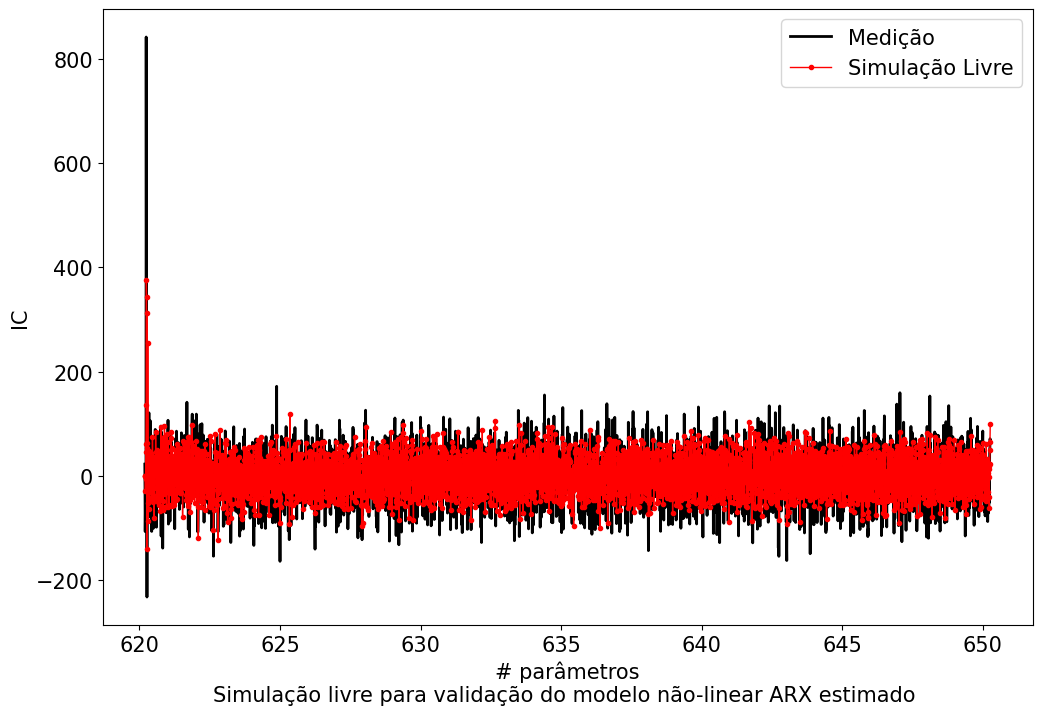

In [119]:
y_validacao = y_free
time_to_plot = event_data.Time.to_numpy()

plt.figure()
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

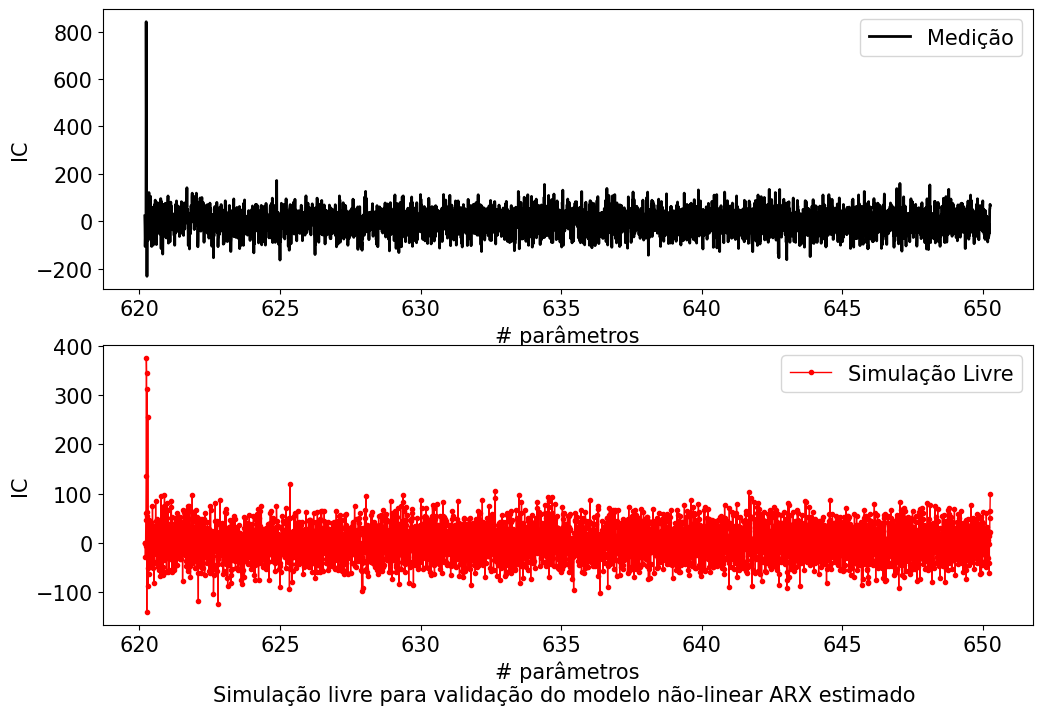

In [120]:
y_validacao = y_free
time = event_data.Time.to_numpy()

plt.figure()
plt.subplot(211)
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.subplot(212)
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Ambos os modelos apresentaram curvas estáticas similares e não serão apresentadas neste trabalho por já constarem nas listas de Exercícios anteriores.

#### Cálculo do RMSD

In [121]:
rmsd = RMSD(y, y_validacao)

print(f"RMSD Modelo Estimado ({len(theta)} parâmetros): {np.round(rmsd, 5)}")

RMSD Modelo Estimado (59 parâmetros): 41.84721


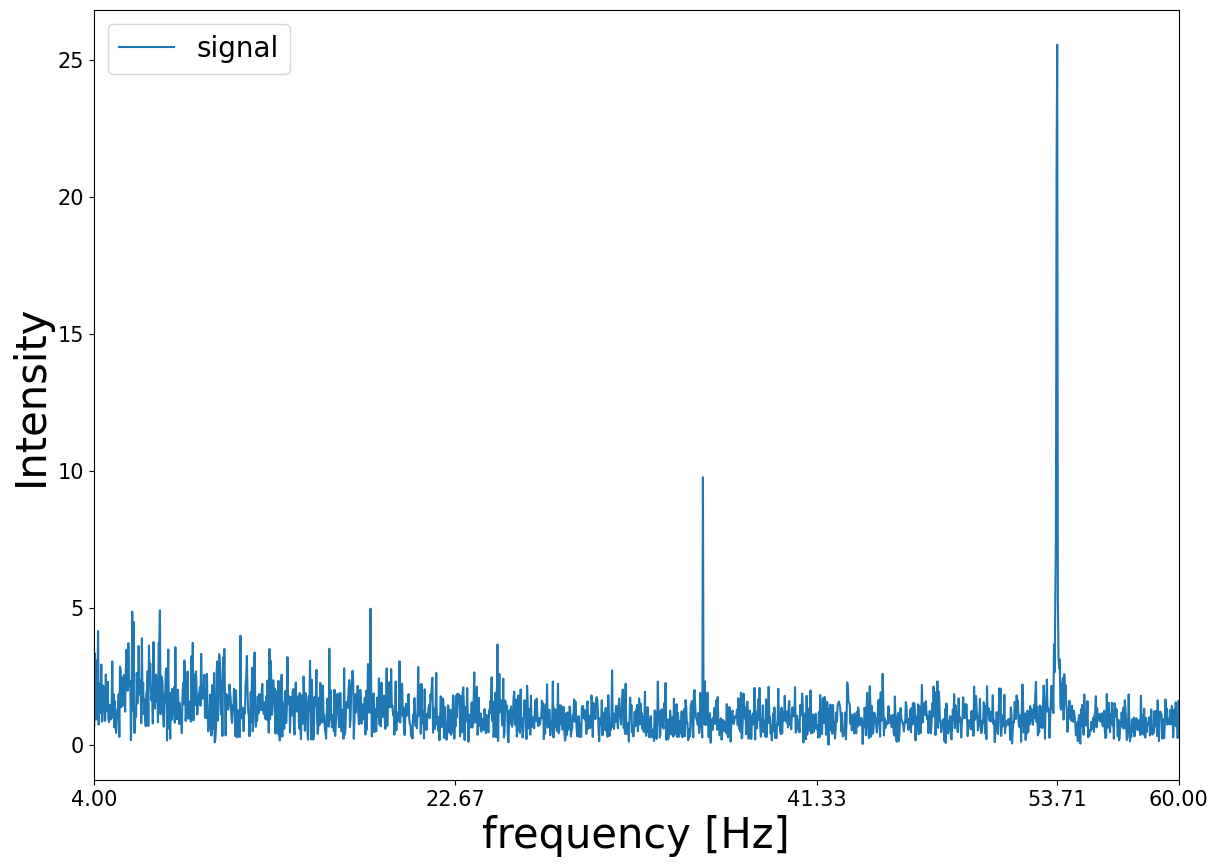

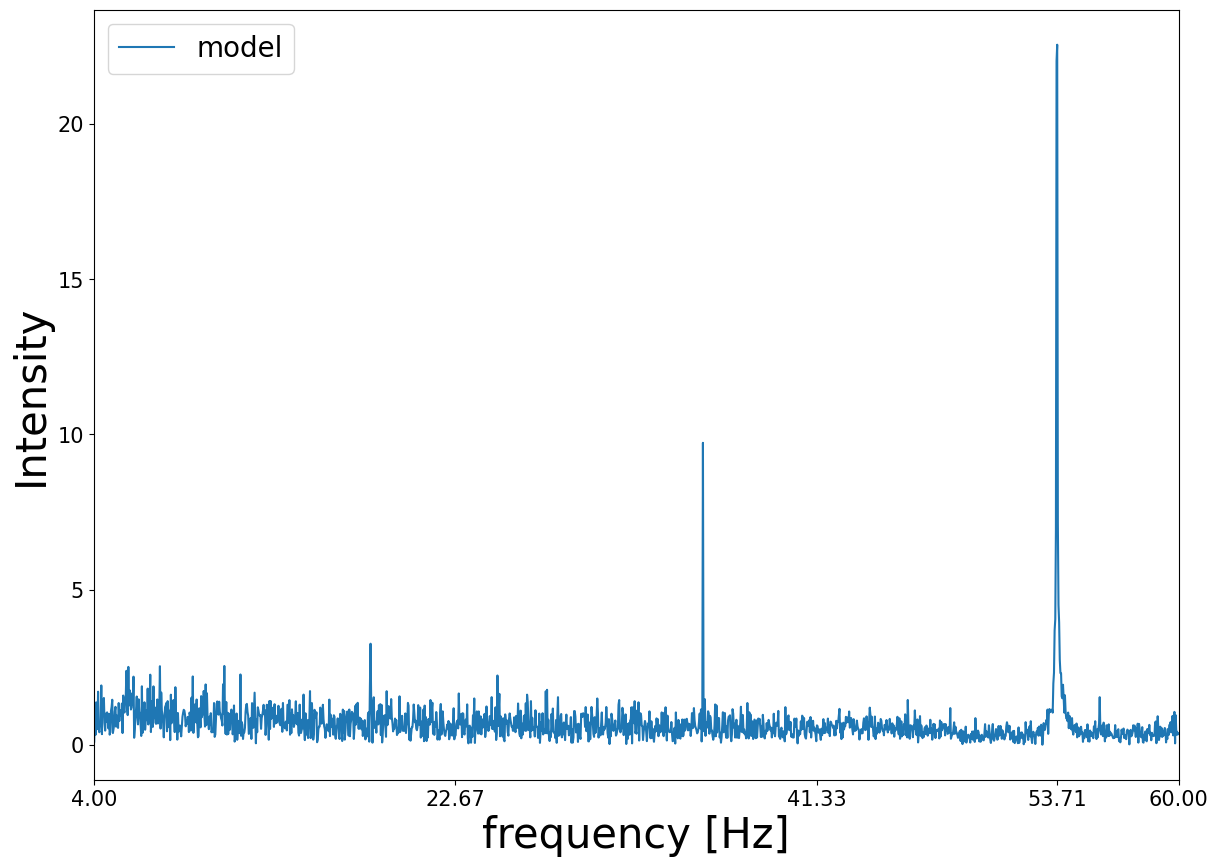

In [122]:
y = y_signal = event_data.Inferior_colliculus_2.to_numpy()

lim = (4, 60)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

fft_data = {
    "signal": y,
    "model": y_validacao
}

for name_data, data in fft_data.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    frequency, intensity, angle = fft(x=data, fs=FrequencySampling)
    y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
    x = (frequency)[(frequency>=lim[0])&(frequency<=lim[1])]
    
    ax.plot(x, y, label=f"{name_data}")
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend(prop={'size': 20})
    plt.savefig(
        f"FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()


In [123]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)

hosa_df = None

if load_already_calculated and not replace_hosa:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")

2023-07-02 18:56:47.853 | INFO     | __main__:<module>:12 - HOSA not calculated yet. Generating hosa...


In [124]:
if (not load_already_calculated or replace_hosa) and generate_hosa:

    frequency_array = np.arange(start=4, stop=60, step=0.01)

    TDQS_PARAMETERS = {
        "frequency_array": frequency_array,
        "phase_step": 0.01
    }

    df_amps = pd.DataFrame()
    df_phases = pd.DataFrame()
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdts for each channel, in parallel

    tdqs_object = TDQS(
        frequency_sampling=FrequencySampling,
        frequency_array=TDQS_PARAMETERS.get("frequency_array"),
        fmin=None,
        fmax=None,
        freq_step=None,
        phase_step=TDQS_PARAMETERS["phase_step"]
    )

    f = lambda x: tdqs_object.run_td4spectrum(x)

    with Pool() as pool:

        for result in pool.map(
            f, 
            [
                {
                    signal_name: signal_array
                } for signal_name, signal_array in {"signal": y_signal, "model": y_validacao}.items()
            ]
        ):

            signal_name, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum,
                tetraspectrum,
                phase_tetraspectrum         
            ) = result_data

            if "frequency" not in df_amps.columns:
                df_amps = df_amps.assign(frequency=frequency_array)
            if "frequency" not in df_amps_signal.columns:
                df_amps_signal = df_amps_signal.assign(frequency=frequency_array)
            if "frequency" not in df_amps_model.columns:
                df_amps_model = df_amps_model.assign(frequency=frequency_array)

            df_amps = df_amps.assign(**{f"tds_amp_{signal_name}": spectrum})
            df_phases = df_phases.assign(**{f"tds_phase_{signal_name}": phase_spectrum})

            df_amps = df_amps.assign(**{f"tdbs_amp_{signal_name}": bispectrum})
            df_phases = df_phases.assign(**{f"tdbs_phase_{signal_name}": phase_bispectrum})

            df_amps = df_amps.assign(**{f"tdts_amp_{signal_name}": trispectrum})
            df_phases = df_phases.assign(**{f"tdts_phase_{signal_name}": phase_trispectrum})

            df_amps = df_amps.assign(**{f"tdqs_amp_{signal_name}": tetraspectrum})
            df_phases = df_phases.assign(**{f"tdqs_phase_{signal_name}": phase_tetraspectrum})
            
            if signal_name == "signal":
                df_amps_signal = df_amps_signal.assign(**{f"tds_amp": spectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": bispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": trispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_signal = df_phases_signal.assign(**{f"tds_phase": phase_spectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdqs_phase": phase_tetraspectrum})
                
            elif signal_name == "model":
                df_amps_model = df_amps_model.assign(**{f"tds_amp": spectrum})
                df_amps_model = df_amps_model.assign(**{f"tdbs_amp": bispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdts_amp": trispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_model = df_phases_model.assign(**{f"tds_phase": phase_spectrum})
                df_phases_model = df_phases_model.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdqs_phase": phase_tetraspectrum})



    hosa_df = pd.concat([df_amps, df_phases], axis=1)

    
    
    
    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done processing data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")
    
elif hosa_df is not None:
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()
    
    df_amps_signal = df_amps_signal.assign(frequency=hosa_df.frequency)
    df_amps_signal = df_amps_signal.assign(**{f"tds_amp": hosa_df.tds_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": hosa_df.tdts_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_signal})
    
    df_amps_model = df_amps_model.assign(frequency=hosa_df.frequency)
    df_amps_model = df_amps_model.assign(**{f"tds_amp": hosa_df.tds_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdts_amp": hosa_df.tdts_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_model})

2023-07-02 18:56:47.866 | INFO     | __main__:<module>:19 - Processing the tdqs... This may take a while...

2023-07-02 19:01:46.094 | SUCCESS  | __main__:<module>:111 - Done processing data. Elapsed time: 04m58s


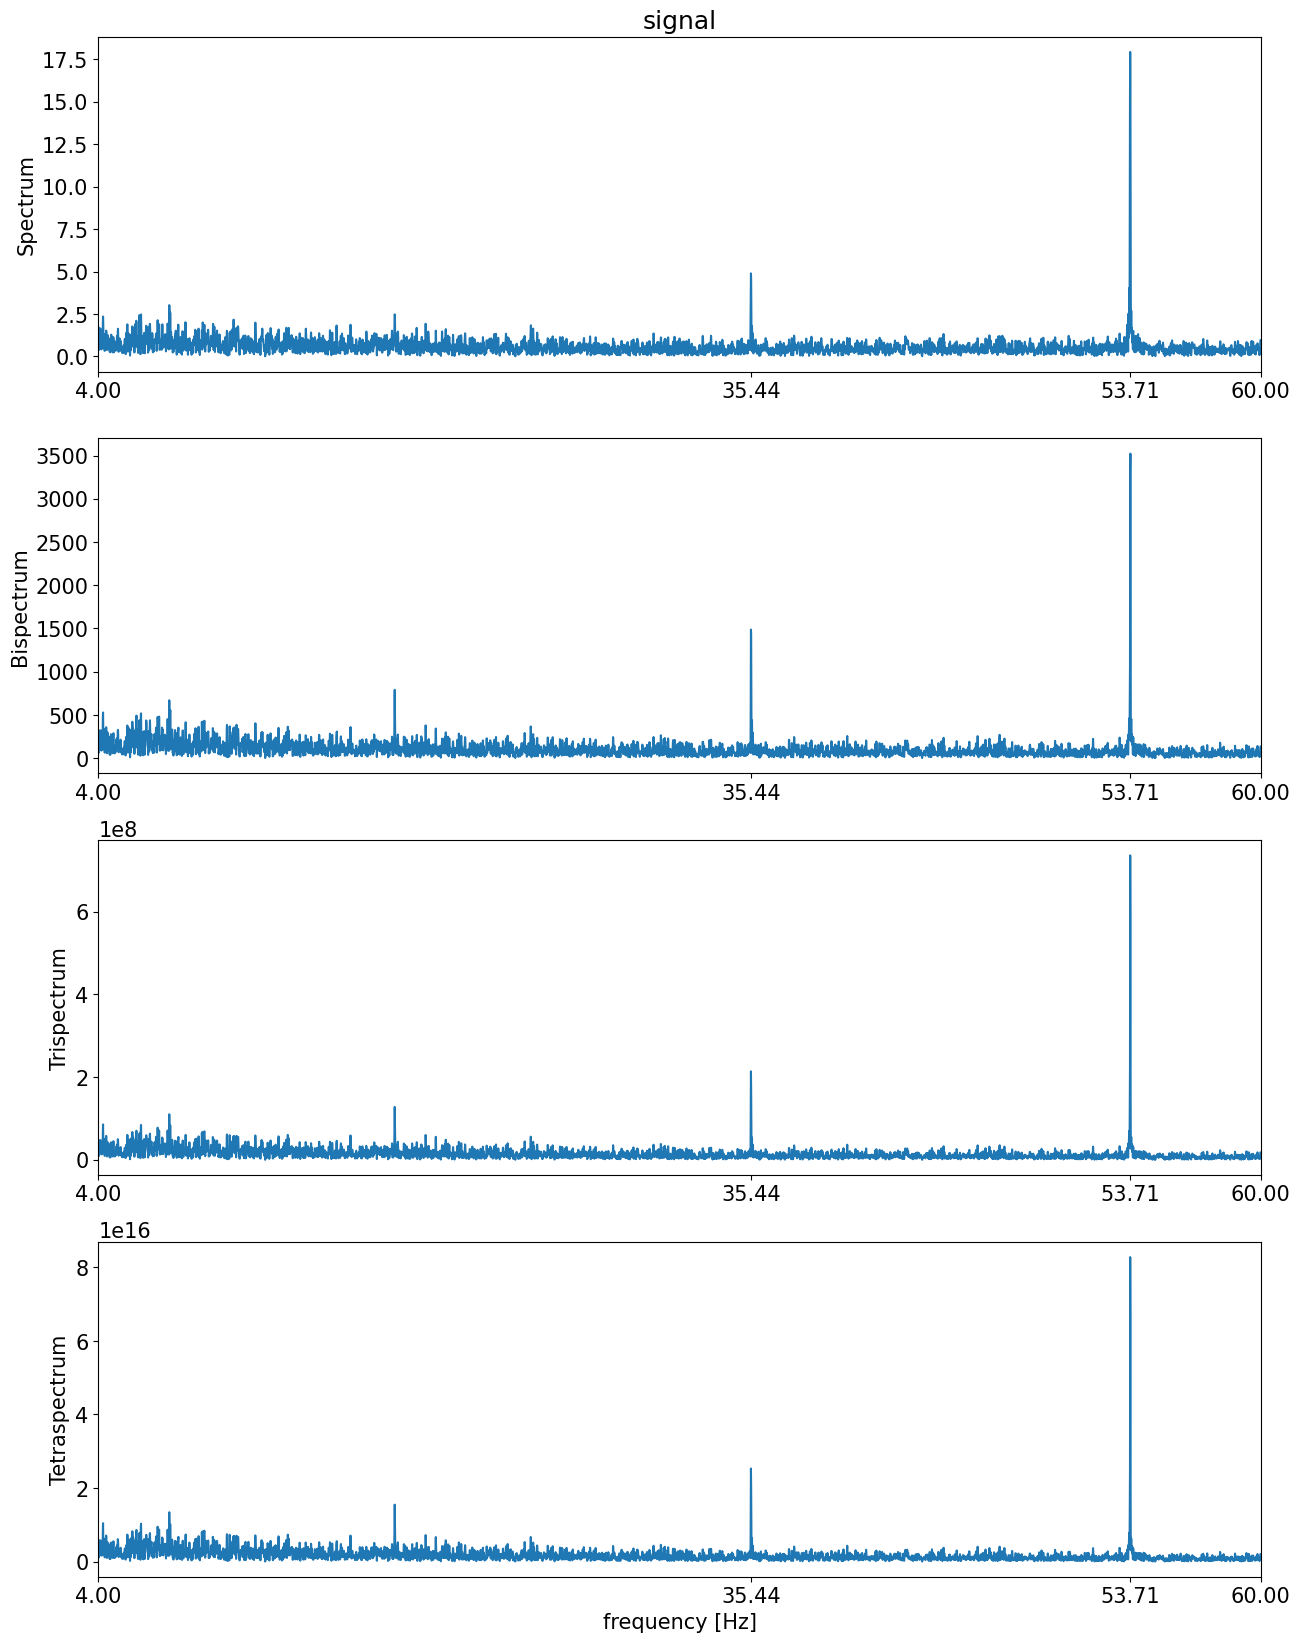

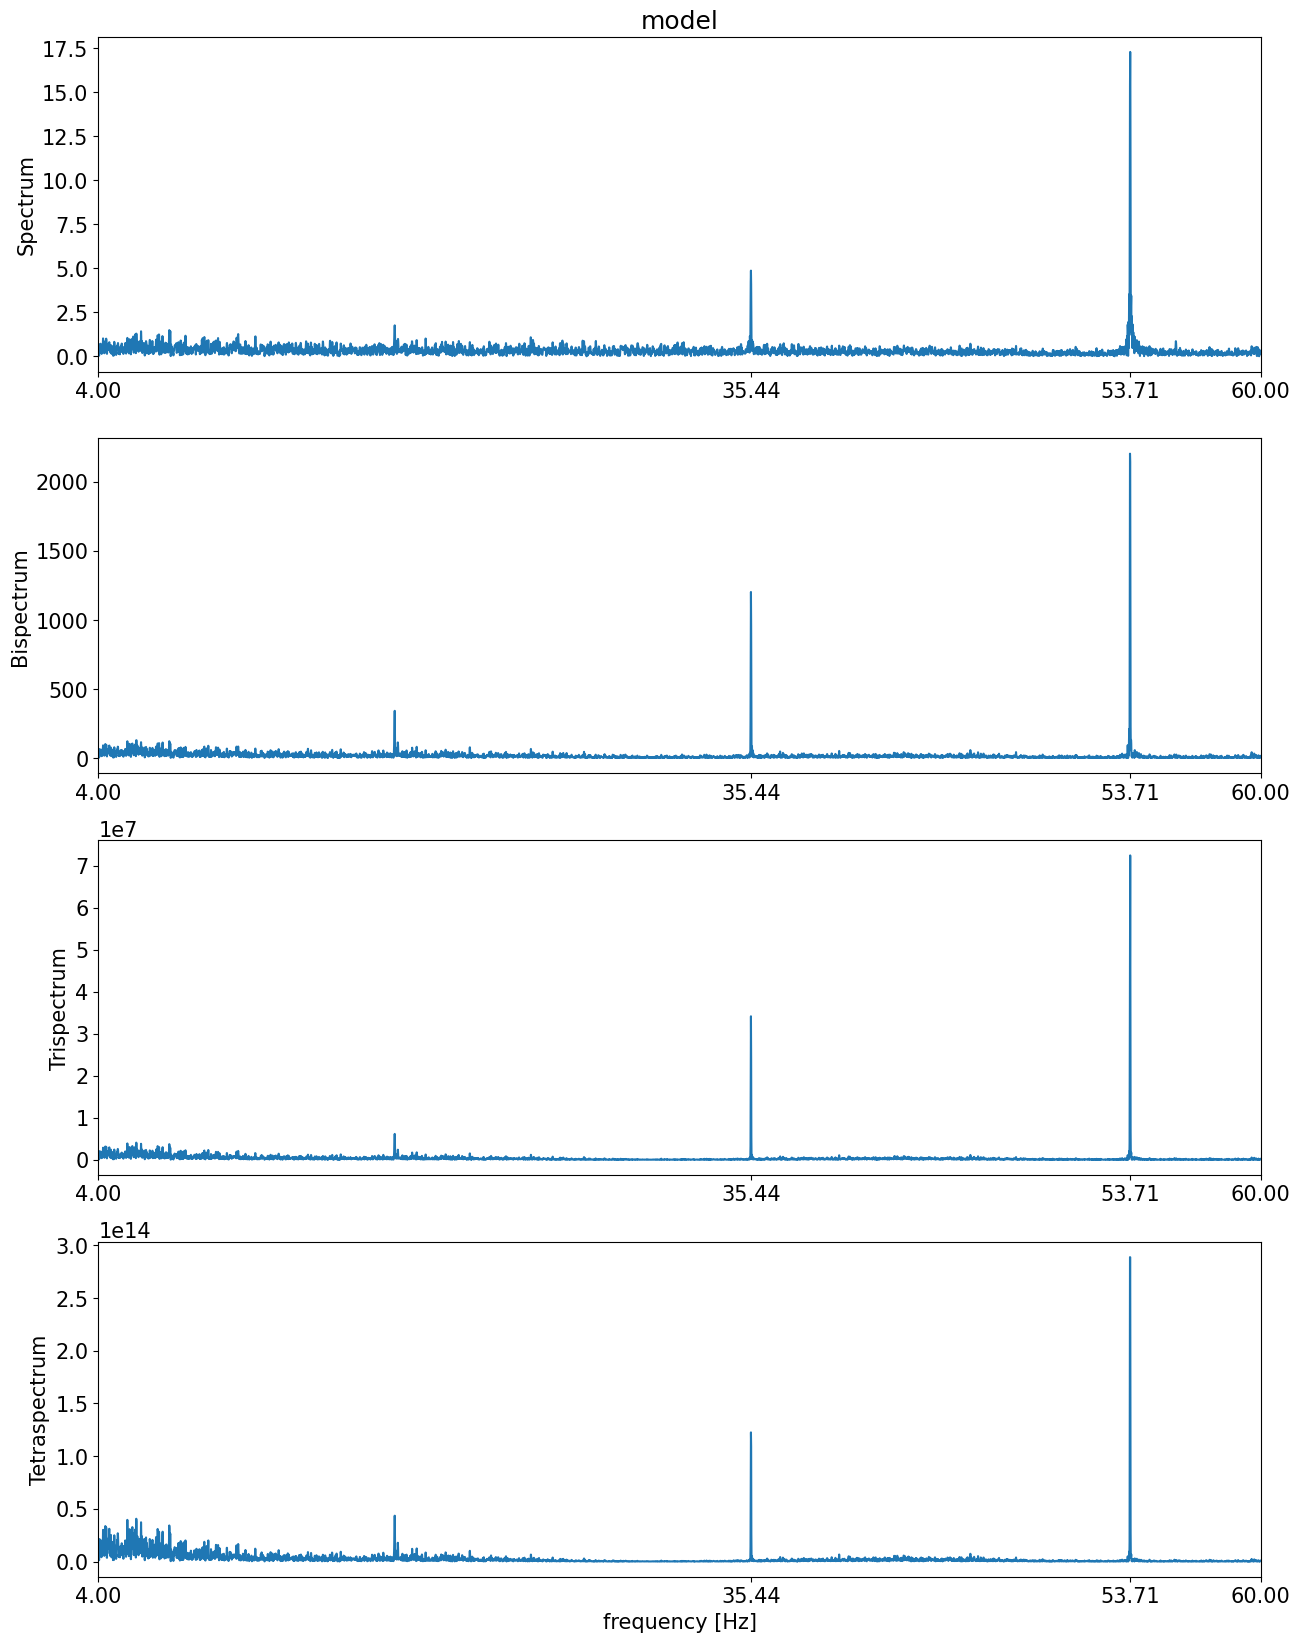

In [125]:
if hosa_df is not None:
    lim = (4, 60)
    ymin = float("Inf")
    ymax = float("-Inf")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    tdqs_data = {
        "signal": df_amps_signal,
        "model": df_amps_model
    }

    for name_data, data in tdqs_data.items():
        fig = plt.figure(figsize=(15,20))

        plt.subplot(411)
        plt.title(name_data)
        plt.plot(data.frequency, data.tds_amp)
        plt.ylabel("Spectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(412)
        plt.plot(data.frequency, data.tdbs_amp)
        plt.ylabel("Bispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(413)
        plt.plot(data.frequency, data.tdts_amp)
        plt.ylabel("Trispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(414)
        plt.plot(data.frequency, data.tdqs_amp)
        plt.ylabel("Tetraspectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)

        plt.xlabel("frequency [Hz]", fontsize=15)

        plt.xlim([lim[0], lim[1]])

        plt.savefig(
            f"hosa_{id_file}_{id_results}.jpg",
            format="jpg",
            bbox_inches='tight', 
            dpi=150
        )

        plt.show()


# Selecting Data to model - EVENT 5

In [126]:
event_number = 5
id_results: str = f"event_{event_number}"

event_data = select_event_window(
    df=data_backup, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0
)

In [127]:
event_data.columns

Index(['CS_modulating', 'mPFC_pre_limbic_1', 'mPFC_pre_limbic_2',
       'mPFC_infra_limbic_1', 'mPFC_infra_limbic_2', 'Hippocampus_CA1',
       'Hippocampus_MOL_layer', 'Hippocampus_GD_1', 'Hippocampus_GD_2',
       'Amygdala_lateral_1', 'Amygdala_lateral_2', 'Amygdala_basolateral_1',
       'Amygdala_basolateral_2', 'Inferior_colliculus_1',
       'Inferior_colliculus_2', 'Inferior_colliculus_3',
       'Inferior_colliculus_4', 'Time', 'event',
       'filtered_Inferior_colliculus_1', 'filtered_Inferior_colliculus_2',
       'filtered_Inferior_colliculus_3', 'filtered_Inferior_colliculus_4',
       'filtered_Amygdala_lateral_1', 'filtered_Amygdala_basolateral_1',
       'filtered_Amygdala_lateral_2', 'filtered_Amygdala_basolateral_2'],
      dtype='object')

In [128]:
y = event_data.Inferior_colliculus_2.to_numpy()

In [129]:
u = np.vstack([event_data.loc[:, dict_inputs[input_model]] for input_model in inputs])

In [130]:
u.shape

(4, 4296)

In [131]:
path_files = f"err_model_{id_file}_{id_results}_err.pkl"
err_already_calculated: bool = os.path.isfile(path_files)

if err_already_calculated and not replace_err:
    logger.info("ERR already calculated. Loading...")
    err_out, termos, psi = load_err()
    logger.success("ERR loaded!")
else:
    logger.info("ERR not calculated yet. Generating ERR...")

2023-07-02 19:01:47.451 | INFO     | __main__:<module>:5 - ERR already calculated. Loading...
2023-07-02 19:01:47.451 | INFO     | __main__:load_err:5 - loading err...
2023-07-02 19:01:47.452 | INFO     | __main__:load_err:9 - loading termos...
2023-07-02 19:01:47.453 | INFO     | __main__:load_err:13 - loading psi...
2023-07-02 19:01:47.456 | SUCCESS  | __main__:load_err:17 - Done loading err data!
2023-07-02 19:01:47.456 | SUCCESS  | __main__:<module>:7 - ERR loaded!


### Obtendo o resultado do Critério de Redução de Erro 

In [132]:
if not err_already_calculated or replace_err:

    err_obj = err(
        ny=max_y_delays,
        nu=max_u_delays,
        n_lin=degree_of_non_linearity,
        yid=y,
        uid=u,
        cte=True,
    )

    start_time = perf_counter()

    err_out, termos, psi = err_obj.run(print_result=True)

    end_time = perf_counter()

    save_err(err_out, termos, psi)

### Obtendo o Critério de Informação de Akaike para a matriz $\Psi$ gerada pelo ERR

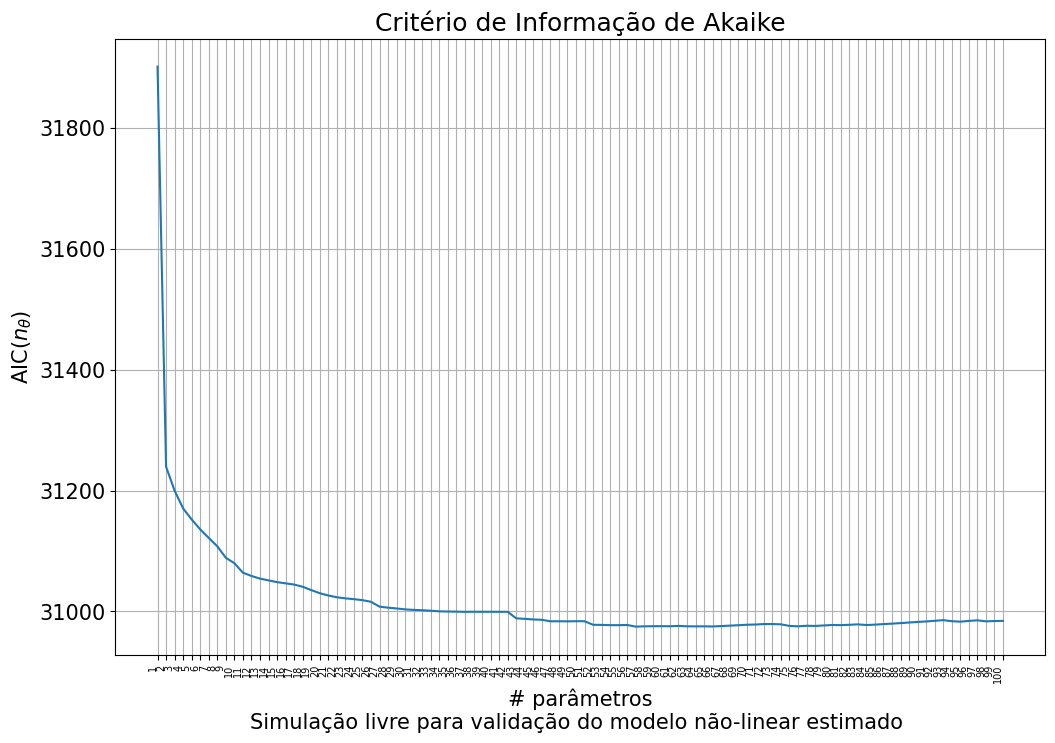

In [133]:
Phi = np.array([])

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, residuos = MQ(Phi.T, y[max_delays:])
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y), var_xi))
    
    parameters = np.append(parameters, i+1)
    
max_number_of_parameters = 100  # float("Inf")
plt.plot(parameters[parameters<=max_number_of_parameters], aic[parameters<=max_number_of_parameters])
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Simulação livre para validação do modelo não-linear estimado "
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.xticks(parameters[parameters<=max_number_of_parameters], rotation=90, ha='right', fontsize=7)
plt.grid()
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 5 primeiros regressores listados, que consistem das combinações de número 1, 14, 7, 2 e 5, da tabela de termos mostrada abaixo:

In [134]:
number_of_selected_terms = 28

In [135]:
psi_mq = np.vstack([psi[:,i] for i in err_out["ordem"][:number_of_selected_terms]]).T

theta, xi = MQ(psi_mq, y[max_delays:])

print(f"Theta ordenado: {theta}")

Theta ordenado: [ 2.34320656e+01  4.15914902e-01  1.24814574e+01  1.47952665e-01
  2.68460041e+01 -2.55341052e-01 -1.11772637e-03  9.41943547e-02
 -7.77969688e-02  7.01356280e-04 -7.17258060e-04  1.05132579e-03
 -1.25117702e-03  9.92183721e-02  1.23667088e-03  5.14581437e-02
 -1.22016034e-03 -1.21244173e-01  2.34551350e-01  1.16469564e-03
 -1.31792673e-01  1.13791172e-03  1.22721359e+01 -6.53555995e-02
 -6.48082363e-04  1.82510202e-03 -1.20058812e-03 -4.11190755e-02]


Assim, o modelo NARX escolhido é:

In [136]:
terms_dict = termos.iloc[err_out["ordem"][:number_of_selected_terms]].T.to_dict()

model = []
model_dict = {}
model_str = []

for reg_number, line in terms_dict.items():
    term = ""
    for reg, power in line.items():
        term += " * " if term and power else ""
        term += reg if power > 0 else ""
        term += f"**{int(power)}" if power > 1 else ""
    term += "1"*(not bool(term))
    term = term.replace("(", "[").replace(")", "]")
    model.append(term)
    model_dict[reg_number] = term
    
print("\n\nOrderedTermos:\n")

for i, term in enumerate(model_dict.values()):
    print(f"{str(i).zfill(2)}: err: {'{:e}'.format((err_out['valor'][:number_of_selected_terms])[i])} - {term}")
    

print("\n\nTermos:\n")

for line, term in model_dict.items():
    print(f"{line}: {term}")
    
terms_per_line = 4
print("\ny(k) = ", end="")
for i, term in enumerate(model, start=1):
    print(f"{term}{' + '*(i not in (len(model),))}", end="\n" if not i % terms_per_line else "")
    
print("\n\n\n")



OrderedTermos:

00: err: 1.558112e-01 - u[0, k-1]
01: err: 1.208980e-01 - u[1, k-1]
02: err: 5.522825e-03 - u[0, k-3] * u[0, k-4]
03: err: 4.429293e-03 - u[3, k-1]
04: err: 5.726430e-03 - u[0, k-1] * u[0, k-2]
05: err: 3.028339e-03 - y[k-1]
06: err: 2.647676e-03 - u[2, k-2] * u[2, k-3]
07: err: 2.586220e-03 - u[1, k-2]
08: err: 3.405909e-03 - u[1, k-4]
09: err: 1.782682e-03 - u[1, k-2] * u[2, k-1]
10: err: 2.846427e-03 - u[3, k-1] * u[3, k-2]
11: err: 1.195996e-03 - u[3, k-1]**2
12: err: 1.024184e-03 - y[k-1] * u[3, k-1]
13: err: 7.896835e-04 - u[2, k-1]
14: err: 7.891341e-04 - y[k-3] * u[3, k-2]
15: err: 6.385272e-04 - u[0, k-3] * u[1, k-3]
16: err: 6.399467e-04 - u[2, k-2] * u[3, k-2]
17: err: 8.983425e-04 - u[0, k-4] * u[3, k-2]
18: err: 1.193271e-03 - u[0, k-4] * u[1, k-2]
19: err: 1.146244e-03 - u[1, k-2]**2
20: err: 9.155408e-04 - y[k-2] * u[0, k-4]
21: err: 7.839741e-04 - u[1, k-1] * u[2, k-2]
22: err: 6.065661e-04 - 1
23: err: 5.267931e-04 - u[0, k-3] * u[2, k-1]
24: err: 5.7

Validação utilizando a segunda metade da massa de dados:

In [137]:
y_free = eval_model_SISO_NARX(
    model=model, 
    theta=theta, 
    u=u, 
    y=y,
    y0=np.zeros(3)
)

Carregando a saída da validação e os resíduos de estimação do modelo cuja estrutura foi obtida no Livro-texto, na Lista de Exercícios 9 

#### Plotando as curvas de validação

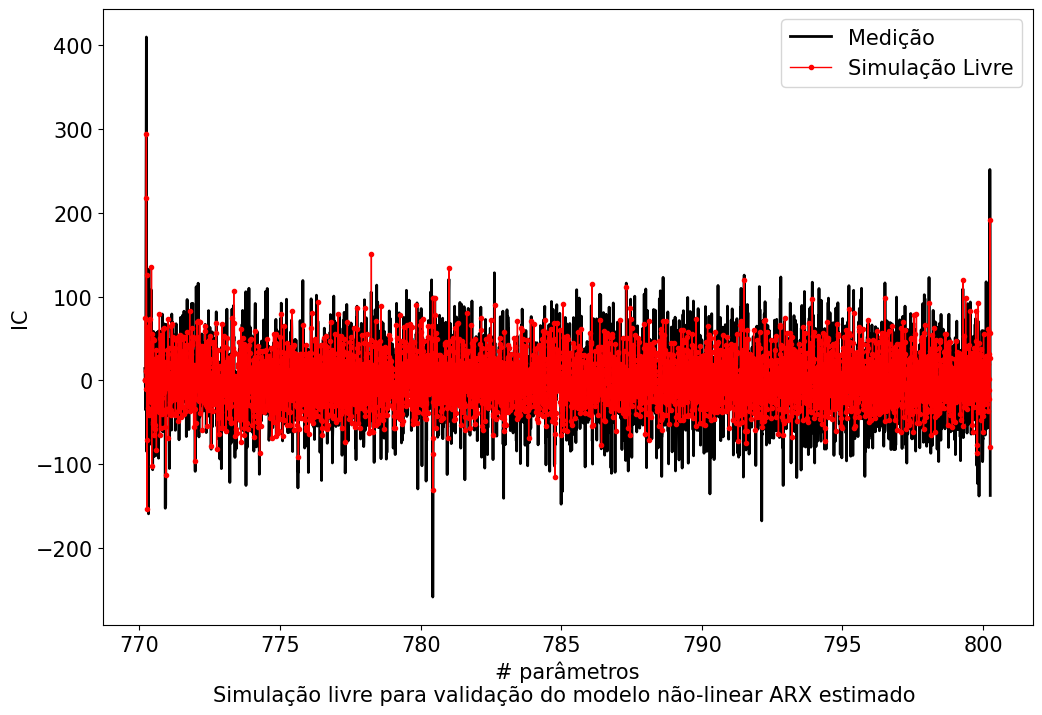

In [138]:
y_validacao = y_free
time_to_plot = event_data.Time.to_numpy()

plt.figure()
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

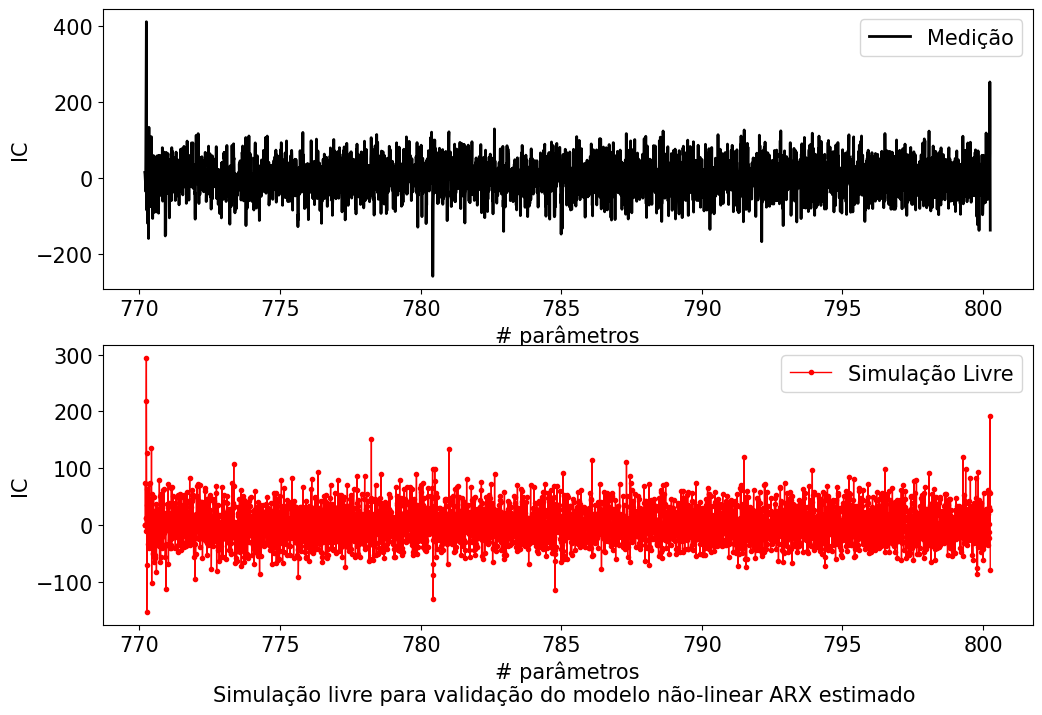

In [139]:
y_validacao = y_free
time = event_data.Time.to_numpy()

plt.figure()
plt.subplot(211)
plt.plot(time_to_plot, y, linewidth=2, label="Medição", color='black')
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.subplot(212)
plt.plot(time_to_plot, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Simulação livre para validação do modelo não-linear ARX estimado "
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Ambos os modelos apresentaram curvas estáticas similares e não serão apresentadas neste trabalho por já constarem nas listas de Exercícios anteriores.

#### Cálculo do RMSD

In [140]:
rmsd = RMSD(y, y_validacao)

print(f"RMSD Modelo Estimado ({len(theta)} parâmetros): {np.round(rmsd, 5)}")

RMSD Modelo Estimado (28 parâmetros): 38.69491


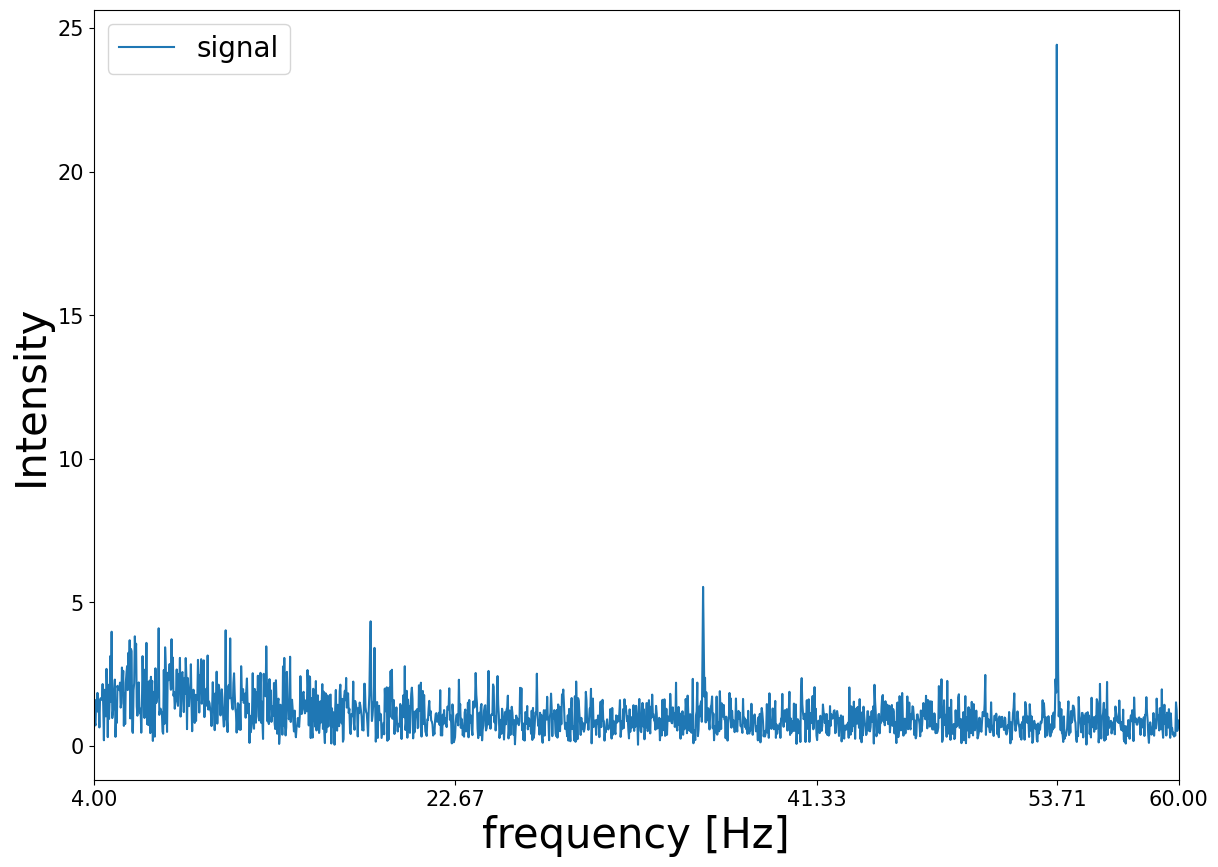

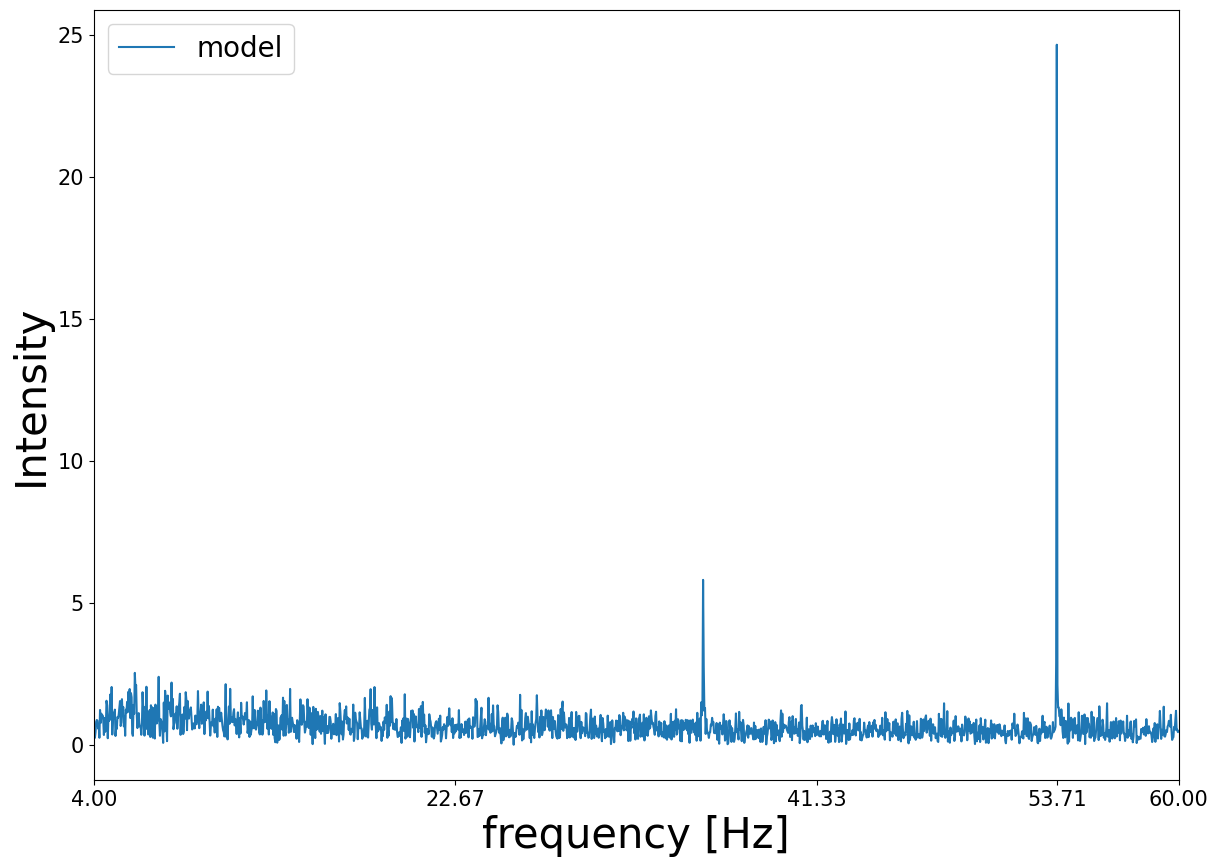

In [141]:
y = y_signal = event_data.Inferior_colliculus_2.to_numpy()

lim = (4, 60)
ymin = float("Inf")
ymax = float("-Inf")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

colors = ["black", "orange", "red", "green", "blue"]

fft_data = {
    "signal": y,
    "model": y_validacao
}

for name_data, data in fft_data.items():
    fig = plt.figure(figsize=(14,10))

    ax = fig.add_subplot(111)

    frequency, intensity, angle = fft(x=data, fs=FrequencySampling)
    y = (intensity)[(frequency>=lim[0])&(frequency<=lim[1])]
    x = (frequency)[(frequency>=lim[0])&(frequency<=lim[1])]
    
    ax.plot(x, y, label=f"{name_data}")
    
    ax.set_xlabel("frequency [Hz]", fontsize=30)
    ax.set_ylabel('Intensity', fontsize=30)
    t = ax.yaxis.get_offset_text()
    t.set_size(20)
    
    plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 4), [53.71])), fontsize=15)
    plt.xlim([lim[0], lim[1]])
    plt.legend(prop={'size': 20})
    plt.savefig(
        f"FFT_{name_data}.jpg",
        format="jpg",
        bbox_inches='tight', 
        dpi=150
    )

    plt.show()


In [142]:
path_files = f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv'
load_already_calculated: bool = os.path.isfile(path_files)

hosa_df = None

if load_already_calculated and not replace_hosa:
    logger.info("HOSA already calculated. Loading...")
    hosa_df = pd.read_csv(path_files)
    logger.success("HOSA loaded!")

else:
    logger.info("HOSA not calculated yet. Generating hosa...")

2023-07-02 19:01:52.067 | INFO     | __main__:<module>:12 - HOSA not calculated yet. Generating hosa...


In [143]:
if (not load_already_calculated or replace_hosa) and generate_hosa:

    frequency_array = np.arange(start=4, stop=60, step=0.01)

    TDQS_PARAMETERS = {
        "frequency_array": frequency_array,
        "phase_step": 0.01
    }

    df_amps = pd.DataFrame()
    df_phases = pd.DataFrame()
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()

    logger.info("Processing the tdqs... This may take a while...\n")
    start_time = perf_counter()

    # Process the tdts for each channel, in parallel

    tdqs_object = TDQS(
        frequency_sampling=FrequencySampling,
        frequency_array=TDQS_PARAMETERS.get("frequency_array"),
        fmin=None,
        fmax=None,
        freq_step=None,
        phase_step=TDQS_PARAMETERS["phase_step"]
    )

    f = lambda x: tdqs_object.run_td4spectrum(x)

    with Pool() as pool:

        for result in pool.map(
            f, 
            [
                {
                    signal_name: signal_array
                } for signal_name, signal_array in {"signal": y_signal, "model": y_validacao}.items()
            ]
        ):

            signal_name, result_data = list(result.items())[0]
            (
                frequency_array, 
                spectrum, 
                phase_spectrum, 
                bispectrum, 
                phase_bispectrum, 
                trispectrum, 
                phase_trispectrum,
                tetraspectrum,
                phase_tetraspectrum         
            ) = result_data

            if "frequency" not in df_amps.columns:
                df_amps = df_amps.assign(frequency=frequency_array)
            if "frequency" not in df_amps_signal.columns:
                df_amps_signal = df_amps_signal.assign(frequency=frequency_array)
            if "frequency" not in df_amps_model.columns:
                df_amps_model = df_amps_model.assign(frequency=frequency_array)

            df_amps = df_amps.assign(**{f"tds_amp_{signal_name}": spectrum})
            df_phases = df_phases.assign(**{f"tds_phase_{signal_name}": phase_spectrum})

            df_amps = df_amps.assign(**{f"tdbs_amp_{signal_name}": bispectrum})
            df_phases = df_phases.assign(**{f"tdbs_phase_{signal_name}": phase_bispectrum})

            df_amps = df_amps.assign(**{f"tdts_amp_{signal_name}": trispectrum})
            df_phases = df_phases.assign(**{f"tdts_phase_{signal_name}": phase_trispectrum})

            df_amps = df_amps.assign(**{f"tdqs_amp_{signal_name}": tetraspectrum})
            df_phases = df_phases.assign(**{f"tdqs_phase_{signal_name}": phase_tetraspectrum})
            
            if signal_name == "signal":
                df_amps_signal = df_amps_signal.assign(**{f"tds_amp": spectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": bispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": trispectrum})
                df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_signal = df_phases_signal.assign(**{f"tds_phase": phase_spectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_signal = df_phases_signal.assign(**{f"tdqs_phase": phase_tetraspectrum})
                
            elif signal_name == "model":
                df_amps_model = df_amps_model.assign(**{f"tds_amp": spectrum})
                df_amps_model = df_amps_model.assign(**{f"tdbs_amp": bispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdts_amp": trispectrum})
                df_amps_model = df_amps_model.assign(**{f"tdqs_amp": tetraspectrum})
                
                df_phases_model = df_phases_model.assign(**{f"tds_phase": phase_spectrum})
                df_phases_model = df_phases_model.assign(**{f"tdbs_phase": phase_bispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdts_phase": phase_trispectrum})
                df_phases_model = df_phases_model.assign(**{f"tdqs_phase": phase_tetraspectrum})



    hosa_df = pd.concat([df_amps, df_phases], axis=1)

    
    
    
    hosa_df.to_csv(f'{os.getcwd()}/hosa_{id_file}_{id_results}.csv', index=False)

    end_time = perf_counter()

    logger.success(f"Done processing data. Elapsed time: {seconds_to_formatted_time(end_time - start_time)}")
    
elif hosa_df is not None:
    
    df_amps_model = pd.DataFrame()
    df_phases_model = pd.DataFrame()

    df_amps_signal = pd.DataFrame()
    df_phases_signal = pd.DataFrame()
    
    df_amps_signal = df_amps_signal.assign(frequency=hosa_df.frequency)
    df_amps_signal = df_amps_signal.assign(**{f"tds_amp": hosa_df.tds_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdts_amp": hosa_df.tdts_amp_signal})
    df_amps_signal = df_amps_signal.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_signal})
    
    df_amps_model = df_amps_model.assign(frequency=hosa_df.frequency)
    df_amps_model = df_amps_model.assign(**{f"tds_amp": hosa_df.tds_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdbs_amp": hosa_df.tdbs_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdts_amp": hosa_df.tdts_amp_model})
    df_amps_model = df_amps_model.assign(**{f"tdqs_amp": hosa_df.tdqs_amp_model})

2023-07-02 19:01:52.085 | INFO     | __main__:<module>:19 - Processing the tdqs... This may take a while...

2023-07-02 19:06:48.303 | SUCCESS  | __main__:<module>:111 - Done processing data. Elapsed time: 04m56s


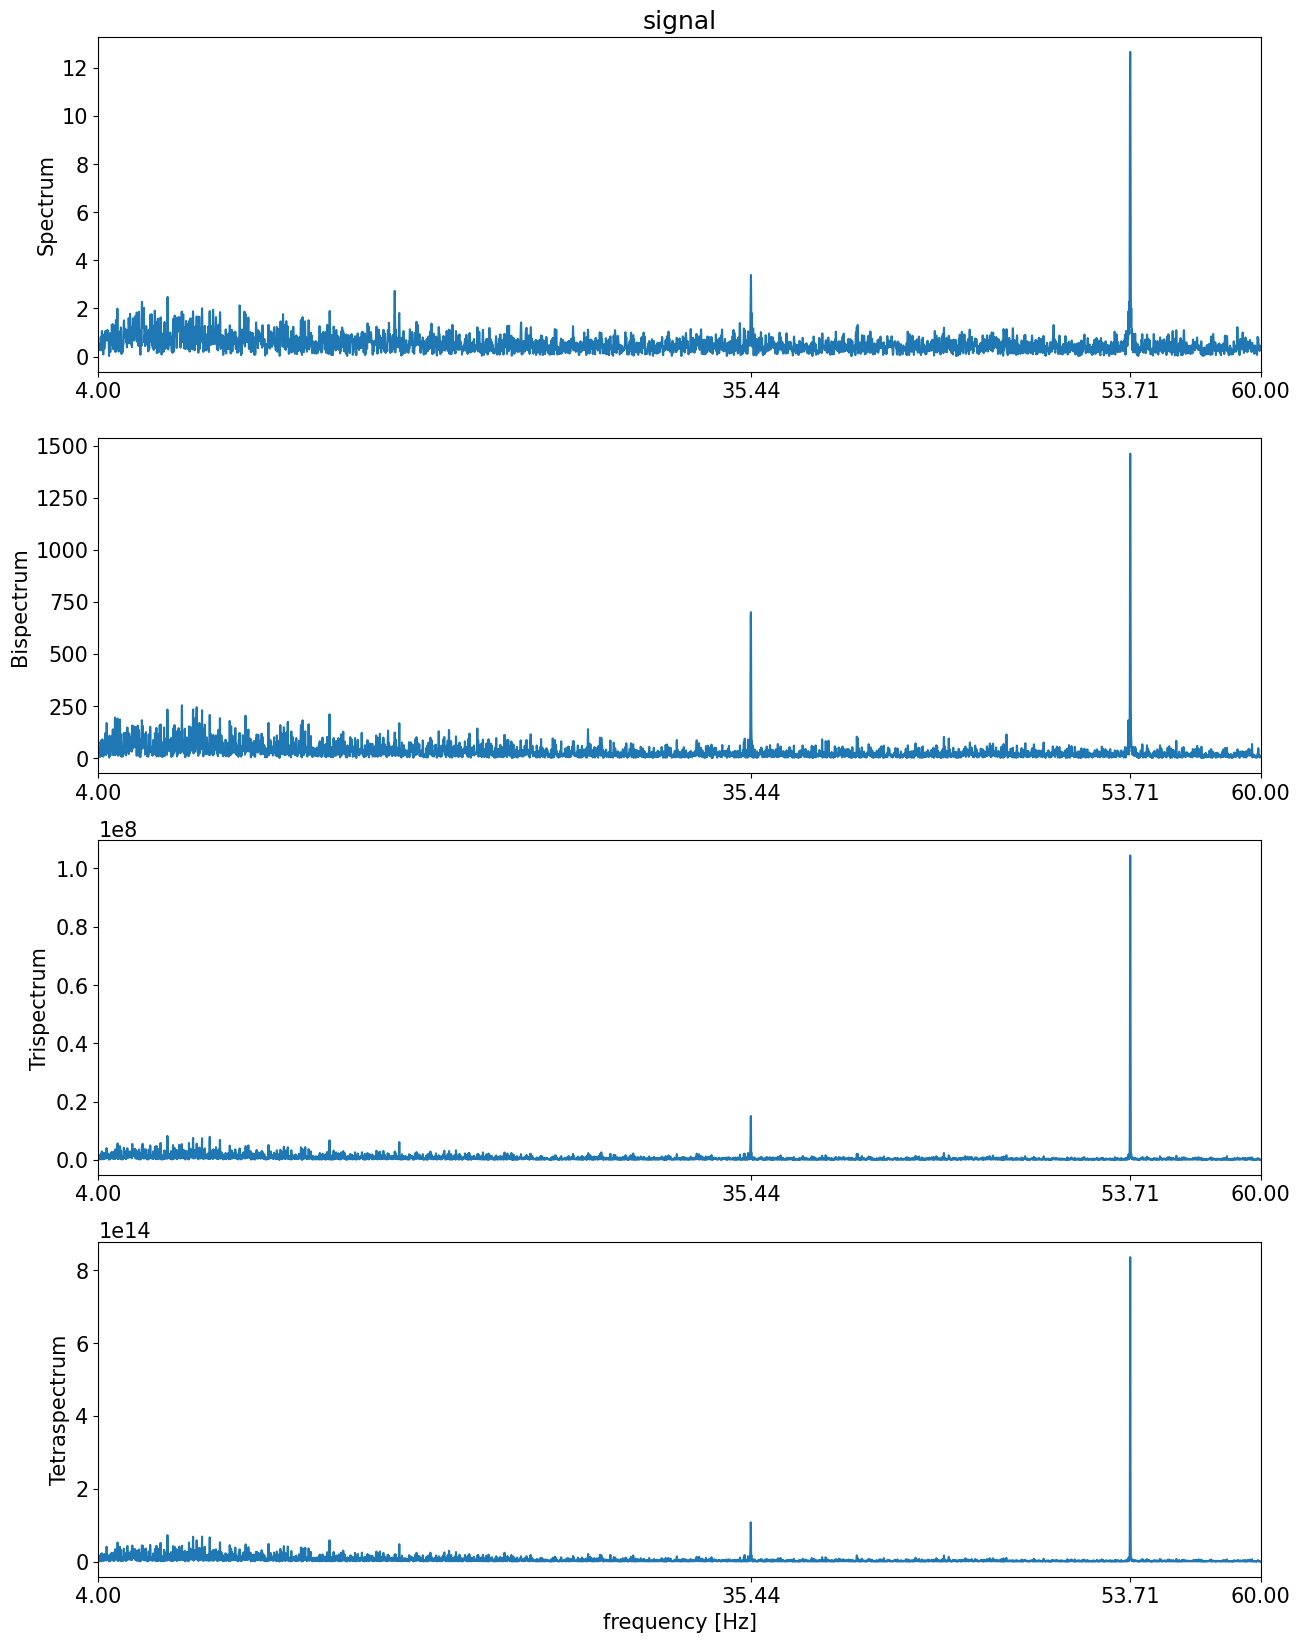

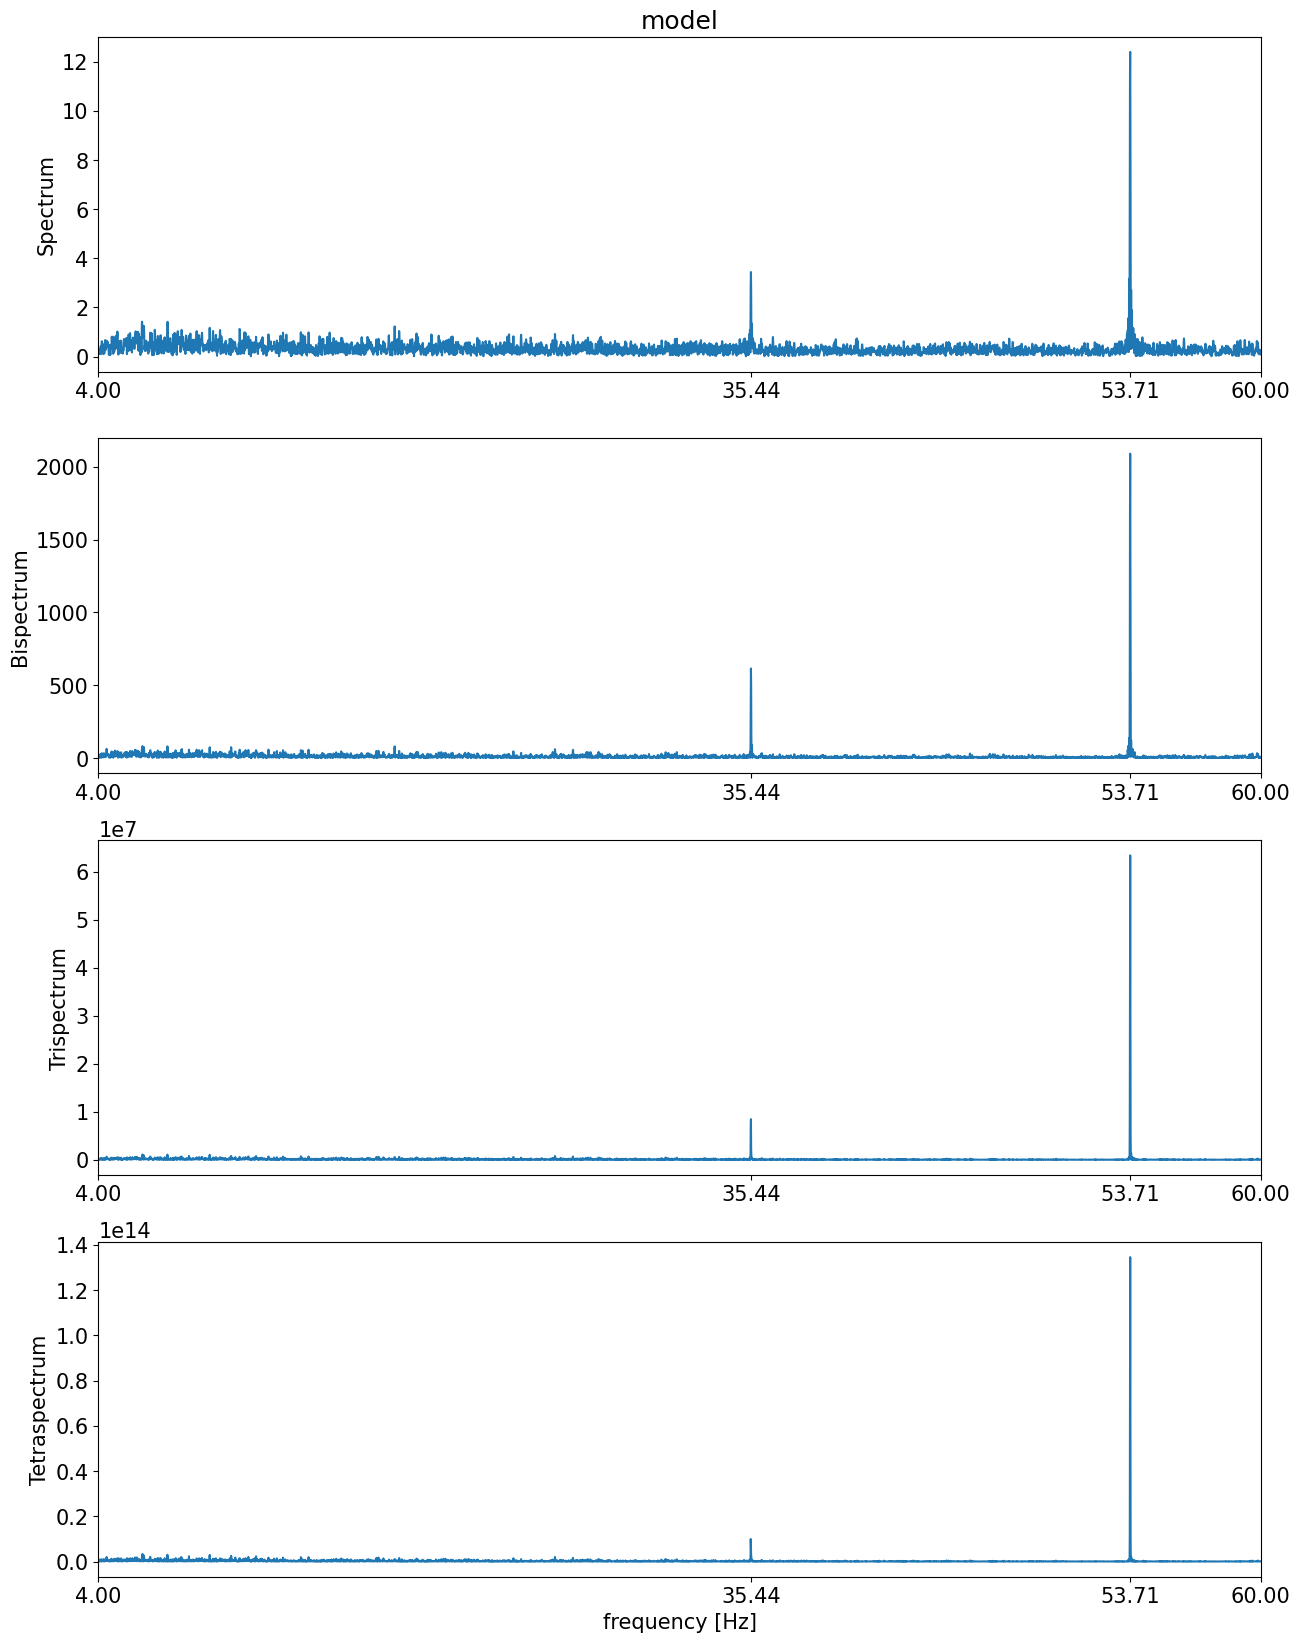

In [144]:
if hosa_df is not None:
    lim = (4, 60)
    ymin = float("Inf")
    ymax = float("-Inf")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    tdqs_data = {
        "signal": df_amps_signal,
        "model": df_amps_model
    }

    for name_data, data in tdqs_data.items():
        fig = plt.figure(figsize=(15,20))

        plt.subplot(411)
        plt.title(name_data)
        plt.plot(data.frequency, data.tds_amp)
        plt.ylabel("Spectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(412)
        plt.plot(data.frequency, data.tdbs_amp)
        plt.ylabel("Bispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(413)
        plt.plot(data.frequency, data.tdts_amp)
        plt.ylabel("Trispectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)
        plt.xlim([lim[0], lim[1]])

        plt.subplot(414)
        plt.plot(data.frequency, data.tdqs_amp)
        plt.ylabel("Tetraspectrum")
        plt.xticks(np.sort(np.append(np.linspace(lim[0], lim[1], 2), [53.71, 35.44])), fontsize=15)

        plt.xlabel("frequency [Hz]", fontsize=15)

        plt.xlim([lim[0], lim[1]])

        plt.savefig(
            f"hosa_{id_file}_{id_results}.jpg",
            format="jpg",
            bbox_inches='tight', 
            dpi=150
        )

        plt.show()
